# Ring resonator

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import meep as mp

from scipy.signal import find_peaks
from scipy.optimize import curve_fit

import scipy.constants
import math

from IPython.display import clear_output

import os
import fnmatch
import imageio

# %matplotlib qt5

## Design of the optical circuit

Design of the geometry of the optical component and set the simulation parameters.

In [2]:
# if plain is True no image will be saved during the simulation
plain = True
# give that plain is False, if animation is True the simulation will produce an .mp4 animation, otherwise it will produce .gif animation
animation = False

Find the resonance of the ring using the Harminv alghoritm, while using a source emitting a Gaussian wave.

In [3]:
n = 1.7    # Si is 3.5
w = 0.5
r = 2    # usually microrings are 5 um
dist = 0.4

pad = 4
dpml = 1
sxy = 2 * (r + w + dpml + pad) # size

In [4]:
print(f'FSR = {1 / (2*np.pi*r) / n} c/um')

m=15
# print(f'l_0 = {n * 2*np.pi*r / m} um')
print(f'f_0 = {1 / (n * 2*np.pi*r / m)} c/um for mode m={m}')

FSR = 0.04681027737996922 c/um
f_0 = 0.7021541606995383 c/um for mode m=15


     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)


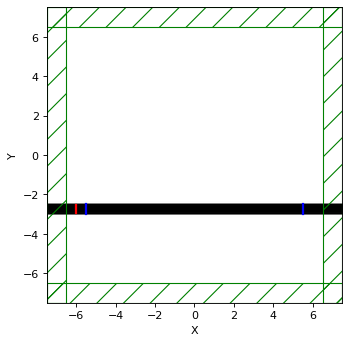

-----------
Initializing structure...
time for choose_chunkdivision = 0.00113511 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.15478 s
-----------


FloatProgress(value=0.0, description='0% done ', max=600.0)

Meep progress: 183.53125/600.0 = 30.6% done in 4.0s, 9.1s to go
on time step 5884 (time=183.875), 0.000679829 s/step
Meep progress: 368.28125/600.0 = 61.4% done in 8.0s, 5.0s to go
on time step 11798 (time=368.688), 0.00067641 s/step
Meep progress: 572.125/600.0 = 95.4% done in 12.0s, 0.6s to go
on time step 18323 (time=572.594), 0.000613116 s/step
run 0 finished at t = 600.0 (19200 timesteps)


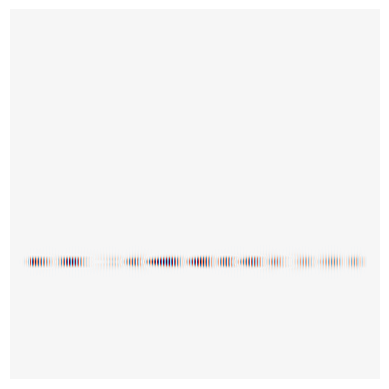

     cylinder, center = (0,0.4,0)
          radius 2.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
     cylinder, center = (0,0.4,0)
          radius 2, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)


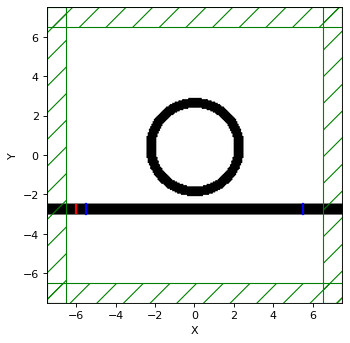

-----------
Initializing structure...
time for choose_chunkdivision = 0.000361919 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     cylinder, center = (0,0.4,0)
          radius 2.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
     cylinder, center = (0,0.4,0)
          radius 2, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.267658 s
-----------


FloatProgress(value=0.0, description='0% done ', max=600.0)

Meep progress: 206.03125/600.0 = 34.3% done in 4.0s, 7.6s to go
on time step 6607 (time=206.469), 0.000605466 s/step
Meep progress: 404.0/600.0 = 67.3% done in 8.0s, 3.9s to go
on time step 12938 (time=404.312), 0.000632106 s/step
Meep progress: 592.40625/600.0 = 98.7% done in 12.0s, 0.2s to go
on time step 18978 (time=593.062), 0.000662336 s/step
harminv0:, frequency, imag. freq., Q, |amp|, amplitude, error
harminv0:, 0.7028231561518103, -0.00048462503481265436, 725.1205629765976, 0.025596115707343138, -0.023579307541543974+0.00995878482371146i, 1.9258647576737472e-11+0.0i
run 0 finished at t = 600.0 (19200 timesteps)


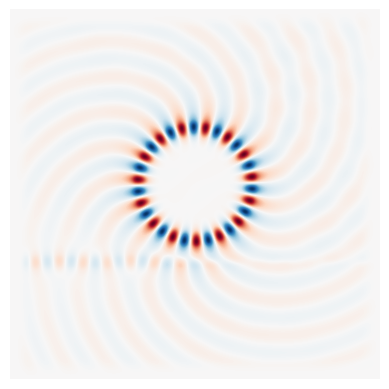

In [5]:
y_ring = dist
y_wg = -r-w-w/2

c1 = mp.Cylinder(radius = r + w, material = mp.Medium(index=n), center=mp.Vector3(0,y_ring,0))
c2 = mp.Cylinder(radius = r, material = mp.Medium(index=1.), center=mp.Vector3(0,y_ring,0))
guide = mp.Block(mp.Vector3(sxy, w, 0), center= mp.Vector3(0,y_wg,0), material = mp.Medium(index=n))

resolution = 16
runtime = 1000
gaussian_runtime = 400

fcen = 0.702
df = 0.05
nfreq = 2000

src = mp.Source(
    mp.GaussianSource(fcen, fwidth=df),
    mp.Ez,
    center=mp.Vector3(-sxy/2 + dpml + 0.5, y_wg, 0),
    size=mp.Vector3(0,0.8*w,0)
    )

# monitor
trans_fr = mp.FluxRegion(
                size=mp.Vector3(0 ,w, 0),
                center=mp.Vector3(sxy/2 - dpml - 1, y_wg, 0),
            )
refl_fr = mp.FluxRegion(
                size=mp.Vector3(0,w, 0),
                center=mp.Vector3(-sxy/2 + dpml + 1, y_wg, 0),
            )

for norma in ['Waveguide', 'Ring']:
    if (norma == 'Ring'):
        sim.reset_meep()
        geometry = [c1,c2,guide]
   
        if (not plain):
            f = plt.figure(dpi=600)
            animate = mp.Animate2D(sim, mp.Ez, f=f)
            plt.close()
    elif (norma == 'Waveguide'):
        geometry = [guide]
    
    sim = mp.Simulation(
        cell_size=mp.Vector3(sxy,sxy),
        geometry=geometry,
        sources=[src],
        resolution=resolution,
        boundary_layers=[mp.PML(dpml)]
        )

    tran = sim.add_flux(fcen, df, nfreq, trans_fr)
    refl = sim.add_flux(fcen, df, nfreq, refl_fr)

    plt.figure(dpi=80)
    sim.plot2D()
    plt.show()

    if (norma == 'Ring'):
        h=mp.Harminv(mp.Ez, mp.Vector3(r + 0.3*w, y_ring, 0), fcen, df)
        sim.load_minus_flux_data(refl, scatt_refl_data)
        if (plain):
            sim.run(mp.after_sources(h), until_after_sources=gaussian_runtime)
        else:
            if (animation):
                sim.run(mp.at_every(2, animate),
                        mp.after_sources(h), until_after_sources=gaussian_runtime)
                animate.to_mp4(15, './Ring.mp4')
            else:
                sim.run(mp.at_every(2, animate),
                        mp.after_sources(h), until_after_sources=gaussian_runtime)
                animate.to_gif(15, './Ring.gif')    
    elif (norma == 'Waveguide'):
        sim.run(until_after_sources=gaussian_runtime)
        
    if (norma == 'Ring'):
        scatt_refl_flux = mp.get_fluxes(refl)
        scatt_tran_flux = mp.get_fluxes(tran)
    elif (norma == 'Waveguide'):
        scatt_refl_data = sim.get_flux_data(refl)
        scatt_tran_flux_wg = mp.get_fluxes(tran)
    
    eps_data = sim.get_array(center=mp.Vector3(), size=mp.Vector3(sxy,sxy), component=mp.Dielectric)
    ez_data = sim.get_array(center=mp.Vector3(), size=mp.Vector3(sxy,sxy), component=mp.Ez)

    plt.figure()

    plt.imshow(np.flipud(np.fliplr(eps_data.transpose())), interpolation='spline36', cmap='binary')
    plt.imshow(np.flipud(np.fliplr(ez_data.transpose())), interpolation='spline36', cmap='RdBu', alpha=1)

    plt.axis('off')
    plt.show()

Plot the trasmission and reflection due to the ring.

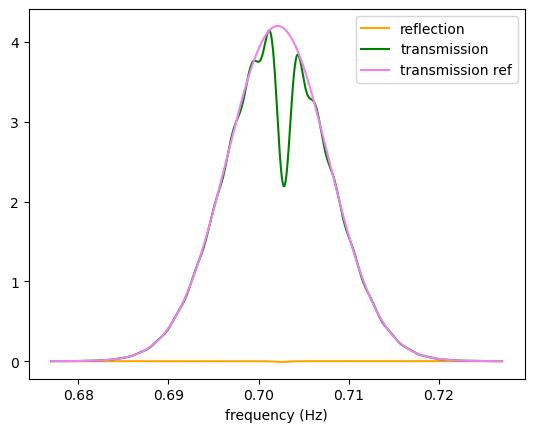

In [6]:
freqs = mp.get_flux_freqs(refl)

plt.figure()

plt.plot(freqs, scatt_refl_flux, label='reflection', color='orange')
plt.plot(freqs, scatt_tran_flux, label='transmission', color='green')
plt.plot(freqs, scatt_tran_flux_wg, label='transmission ref', color='violet')

plt.xlabel('frequency (Hz)')

plt.legend(loc="upper right")
plt.show()

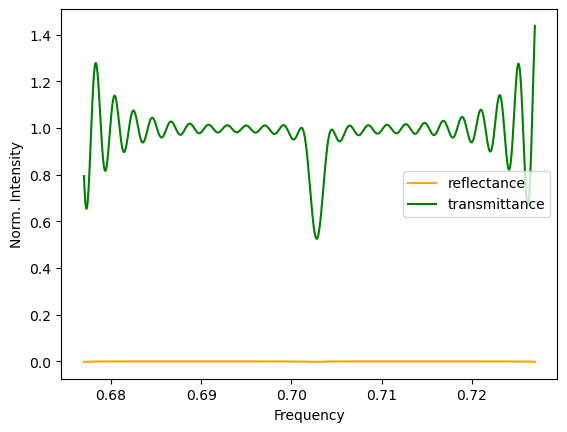

In [7]:
wl = []
Rs = []
Ts = []
Ref = []

for i in range(nfreq):
    wl = np.append(wl, freqs[i])
    Rs = np.append(Rs, scatt_refl_flux[i]/scatt_tran_flux_wg[i]) # il segno è legato all'orientazione del detector
    Ts = np.append(Ts, scatt_tran_flux[i]/scatt_tran_flux_wg[i])

plt.plot(wl, Rs, label='reflectance', color='orange')
plt.plot(wl, Ts, label='transmittance', color='green')
# plt.plot(wl[20:-20], Ts[20:-20], label='transmittance', color='green')

plt.xlabel('Frequency')
plt.ylabel('Norm. Intensity')

# plt.yscale("log")
plt.legend(loc='center right')
plt.show()

Modes found by Harminv (this alghoritm consider the fields as exponentially decaying)

In [8]:
h.modes

[Mode(freq=0.7028231561518103, decay=-0.00048462503481265436, Q=725.1205629765976, amp=(-0.023579307541543974+0.00995878482371146j), err=(1.9258647576737472e-11+0j))]

In [9]:
Q_factors = [data[2] for data in h.modes]
mode_amp = np.abs([data[3] for data in h.modes])
# ampiezze molto piccole possono essere artefatti numerici oppure h è stato posizionato in un punto sfigato
mode_freqs = [data[0] for data in h.modes]

<function matplotlib.pyplot.show(close=None, block=None)>

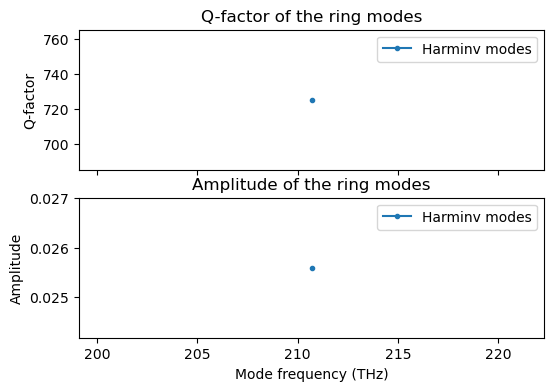

In [10]:
fig, ax = plt.subplots(2,1, figsize=(6,4))
ax[0].plot([ff*scipy.constants.c/10**6 for ff in mode_freqs], np.abs(Q_factors), '.-', label='Harminv modes')
ax[1].plot([ff*scipy.constants.c/10**6 for ff in mode_freqs], mode_amp, '.-', label='Harminv modes')

ax[0].set_title('Q-factor of the ring modes')
ax[0].set_ylabel('Q-factor')
ax[1].set_title('Amplitude of the ring modes')
ax[1].set_ylabel('Amplitude')

for axs in ax.flat:
    axs.set(xlabel='Mode frequency (THz)')
    axs.legend(loc='best')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for axs in ax.flat:
    axs.label_outer()

plt.show

In [11]:
res_freq = mode_freqs[np.where(mode_amp == max(mode_amp))[0][0]]
print(f'The frequency with the highest amplitude is {res_freq} c/um')
print(f'The frequency with the highest amplitude is {res_freq*scipy.constants.c/10**6} THz')

The frequency with the highest amplitude is 0.7028231561518103 c/um
The frequency with the highest amplitude is 210.70108152206905 THz


## Switching to a continuous source

     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)


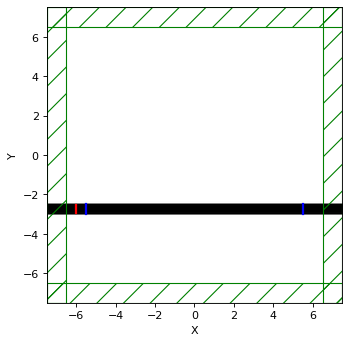

-----------
Initializing structure...
time for choose_chunkdivision = 0.000550032 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.134121 s
-----------


FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 83.375/1000.0 = 8.3% done in 4.0s, 44.0s to go
on time step 2678 (time=83.6875), 0.00149406 s/step
Meep progress: 177.75/1000.0 = 17.8% done in 8.0s, 37.0s to go
on time step 5697 (time=178.031), 0.001325 s/step
Meep progress: 276.28125/1000.0 = 27.6% done in 12.0s, 31.4s to go
on time step 8853 (time=276.656), 0.00126748 s/step
Meep progress: 370.90625/1000.0 = 37.1% done in 16.0s, 27.1s to go
on time step 11880 (time=371.25), 0.00132164 s/step
Meep progress: 465.3125/1000.0 = 46.5% done in 20.0s, 23.0s to go
on time step 14903 (time=465.719), 0.00132405 s/step
Meep progress: 557.40625/1000.0 = 55.7% done in 24.0s, 19.1s to go
on time step 17851 (time=557.844), 0.00135686 s/step
Meep progress: 649.53125/1000.0 = 65.0% done in 28.0s, 15.1s to go
on time step 20804 (time=650.125), 0.00135481 s/step
Meep progress: 741.8125/1000.0 = 74.2% done in 32.0s, 11.1s to go
on time step 23756 (time=742.375), 0.00135542 s/step
Meep progress: 835.625/1000.0 = 83.6% done in 36.0s, 7.1s

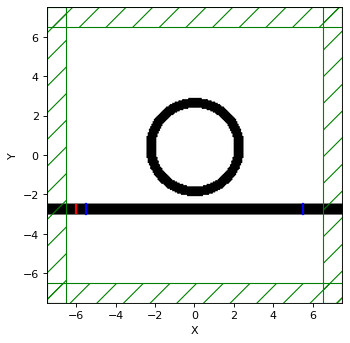

-----------
Initializing structure...
time for choose_chunkdivision = 0.000473022 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     cylinder, center = (0,0.4,0)
          radius 2.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
     cylinder, center = (0,0.4,0)
          radius 2, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.261058 s
-----------


FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 90.3125/1000.0 = 9.0% done in 4.0s, 40.3s to go
on time step 2896 (time=90.5), 0.00138142 s/step
Meep progress: 176.3125/1000.0 = 17.6% done in 8.0s, 37.4s to go
on time step 5651 (time=176.594), 0.00145236 s/step
Meep progress: 266.46875/1000.0 = 26.6% done in 12.0s, 33.0s to go
on time step 8537 (time=266.781), 0.00138631 s/step
Meep progress: 355.625/1000.0 = 35.6% done in 16.0s, 29.0s to go
on time step 11393 (time=356.031), 0.00140093 s/step
Meep progress: 447.375/1000.0 = 44.7% done in 20.0s, 24.7s to go
on time step 14327 (time=447.719), 0.00136367 s/step
Meep progress: 536.4375/1000.0 = 53.6% done in 24.0s, 20.7s to go
on time step 17183 (time=536.969), 0.00140091 s/step
Meep progress: 628.34375/1000.0 = 62.8% done in 28.0s, 16.6s to go
on time step 20122 (time=628.812), 0.00136174 s/step
Meep progress: 724.28125/1000.0 = 72.4% done in 32.0s, 12.2s to go
on time step 23194 (time=724.812), 0.00130234 s/step
Meep progress: 820.125/1000.0 = 82.0% done in 36.0s, 7.9s

In [12]:
src = mp.Source(
    mp.ContinuousSource(res_freq),
    mp.Ez,
    center=mp.Vector3(-sxy/2 + dpml + 0.5, y_wg, 0),
    size=mp.Vector3(0,0.8*w,0)
    )

for norma in ['Waveguide', 'Ring']:
    if (norma == 'Ring'):
        sim.reset_meep()
        geometry = [c1,c2,guide]
    elif (norma == 'Waveguide'):
        geometry = [guide]
    
    sim = mp.Simulation(
        cell_size=mp.Vector3(sxy,sxy),
        geometry=geometry,
        sources=[src],
        resolution=resolution,
        boundary_layers=[mp.PML(dpml)]
        )

    tran = sim.add_flux(res_freq, df, nfreq, trans_fr)
    refl = sim.add_flux(res_freq, df, nfreq, refl_fr)

    plt.figure(dpi=80)
    sim.plot2D()
    plt.show()

    if (norma == 'Ring'):
        sim.load_minus_flux_data(refl, scatt_refl_data)
        sim.run(until=runtime)
    elif (norma == 'Waveguide'):
        sim.run(until=runtime)
        
    if (norma == 'Ring'):
        scatt_refl_flux = mp.get_fluxes(refl)
        scatt_tran_flux = mp.get_fluxes(tran)
    elif (norma == 'Waveguide'):
        scatt_refl_data = sim.get_flux_data(refl)
        scatt_tran_flux_wg = mp.get_fluxes(tran)

In [13]:
def fit_sin(xx, A, w, p):
    return A * np.sin(w * xx + p)

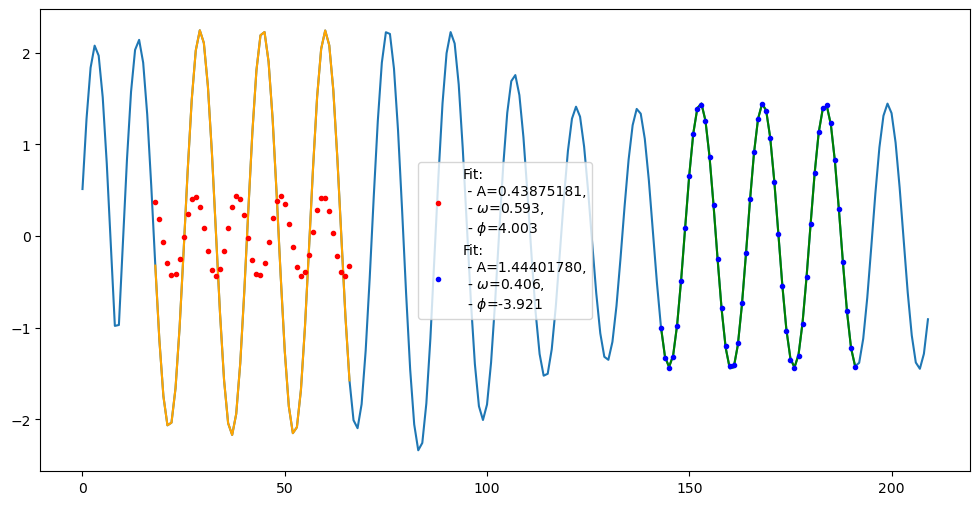

The phase difference is -7.924185174012784


In [14]:
ez_data = sim.get_array(center= mp.Vector3(0, y_wg, 0),
                        size=mp.Vector3(sxy-2*dpml, w),
                        component=mp.Ez)
ez_profile = np.sum(ez_data, axis=1)

outer_border=int(resolution*0.5 + 10)
inner_border=int(resolution*0.5 + 30)
before_start = outer_border
before_end = int(len(ez_profile)/2 - inner_border)
after_start = len(ez_profile) - before_end
after_end = len(ez_profile) - before_start

before_field = ez_profile[before_start:before_end]
after_field = ez_profile[after_start:after_end]

ft_before = np.fft.rfft(before_field)
ft_after = np.fft.rfft(after_field)
freq = np.fft.rfftfreq(len(before_field), d=1)

before_peak = np.argmax(np.abs(ft_before[1:])) + 1
after_peak = np.argmax(np.abs(ft_after[1:])) + 1

# fig, ax = plt.subplots(1, 1, figsize=(6,3))
# ax.plot(freq, np.abs(ft_before), 'b.')
# ax.plot(freq[before_peak], np.abs(ft_before)[before_peak], 'rx')

# plt.show()

popt_before, _ = curve_fit(fit_sin, np.arange(before_start, before_end), before_field, p0=[max(before_field)*1.5, 2*np.pi*freq[before_peak] , 0],
                           bounds=[[0,0,-np.inf], np.inf], maxfev=10000)
popt_after, _ = curve_fit(fit_sin, np.arange(after_start, after_end), after_field, p0=[max(after_field)*1.5, 2*np.pi*freq[after_peak], 0],
                          bounds=[[0,0,-np.inf], np.inf], maxfev=10000)

fig, ax = plt.subplots(1, 1, figsize=(12,6))

ax.plot(np.arange(len(ez_profile)), ez_profile)
ax.plot(np.arange(before_start, before_end),before_field, c='orange')
ax.plot(np.arange(after_start, after_end),after_field, c='green')
ax.plot(np.arange(before_start, before_end),fit_sin(np.arange(before_start, before_end), *popt_before), 'r.', 
        label='Fit:\n - A=%5.8f,\n - $\omega$=%5.3f,\n - $\phi$=%5.3f' % tuple(popt_before))
ax.plot(np.arange(after_start, after_end),fit_sin(np.arange(after_start, after_end), *popt_after), 'b.',
        label='Fit:\n - A=%5.8f,\n - $\omega$=%5.3f,\n - $\phi$=%5.3f' % tuple(popt_after))

plt.legend(loc='center')
plt.show()

print(f'The phase difference is {popt_after[2]-popt_before[2]}')



## Transmission spectrum of the ring resonator

The source has been switched to a continuous source to produce a scan in frequency and measuring the average power transmitted as a response at different frequency. This spectrum shows the behaviour of a notch filter.

In [15]:
def lorentzian (xx, A, gamma, x0, c):
    return  A/math.pi * gamma/2 / ((xx - x0)**2 + (gamma/2)**2) + c

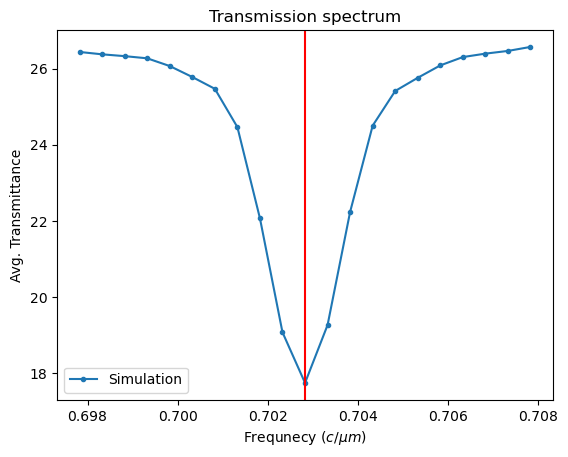

In [16]:
plot= False
nfreq_scan = 21
spectrum_runtime=600

print(f'The dimension of the simulation is {sxy}')
print(f'The risolution of the simulation is {resolution}')
print(f'The step of the simulation is {sxy*resolution}')

frequency = []
transmission_spectra = []
transmission_spectra_1 = []

for f in np.linspace(res_freq-0.005, res_freq+0.005, nfreq_scan):
    for norma in ['Waveguide', 'Ring']:
        if (norma == 'Ring'):
            geometry = [c1,c2,guide]
        elif (norma == 'Waveguide'):
            geometry = [guide]
        
        src = mp.Source(
        mp.ContinuousSource(f),
        mp.Ez,
        center=mp.Vector3(-sxy/2 + dpml + 0.5, y_wg, 0),
        size=mp.Vector3(0,w,0)
        )

        sim = mp.Simulation(
            cell_size=mp.Vector3(sxy,sxy),
            geometry=geometry,
            sources=[src],
            resolution=resolution,
            boundary_layers=[mp.PML(dpml)]
            )

        tran = sim.add_flux(res_freq, df, nfreq, trans_fr)
        refl = sim.add_flux(res_freq, df, nfreq, refl_fr)

        if (norma == 'Ring'):
            sim.load_minus_flux_data(refl, scatt_refl_data)
            sim.run(until=spectrum_runtime)
        elif (norma == 'Waveguide'):
            sim.run(until=spectrum_runtime)
            
        if (norma == 'Ring'):
            scatt_refl_flux = mp.get_fluxes(refl)
            scatt_tran_flux = mp.get_fluxes(tran)
        elif (norma == 'Waveguide'):
            scatt_refl_data = sim.get_flux_data(refl)
            # scatt_tran_flux_wg = mp.get_fluxes(tran)

    freqs = mp.get_flux_freqs(refl)

    if (plot):
        plt.plot(freqs, Ts, '.-', label='transmittance', color='green')

        plt.title(f'Source centerd in {f}Hz')
        plt.xlabel('frequency ($c / \mu m$)')
        plt.ylabel('Norm. Intensity')

        # plt.yscale("log")
        plt.legend(loc='center right')
        plt.show()
    else:
        clear_output()
        
    frequency += [f]
    transmission_spectra += [np.mean(scatt_tran_flux)]

    fig, ax = plt.subplots(1, 1)
    ax.plot(frequency, transmission_spectra, '.-', label='Simulation')
    ax.axvline(x=res_freq, c='r')

    ax.set_title('Transmission spectrum')
    ax.set_xlabel('Frequnecy ($c / \mu m$)')
    ax.set_ylabel('Avg. Transmittance')

    plt.legend()
    plt.show()

    sim.reset_meep()

## Phase difference as a function of the gap width

-----------
Initializing structure...
time for choose_chunkdivision = 0.000392914 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)


          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.163392 s
-----------


FloatProgress(value=0.0, description='0% done ', max=600.0)

Meep progress: 231.96875/600.0 = 38.7% done in 4.0s, 6.3s to go
on time step 7436 (time=232.375), 0.000537951 s/step
Meep progress: 468.90625/600.0 = 78.2% done in 8.0s, 2.2s to go
on time step 15022 (time=469.438), 0.000527309 s/step
run 0 finished at t = 600.0 (19200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000354052 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     cylinder, center = (0,0.08,0)
          radius 2.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
     cylinder, center = (0,0.08,0)
          radius 2, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.262343 s
-----------


FloatProgress(value=0.0, description='0% done ', max=600.0)

Meep progress: 239.53125/600.0 = 39.9% done in 4.0s, 6.0s to go
on time step 7687 (time=240.219), 0.000520439 s/step
Meep progress: 462.3125/600.0 = 77.1% done in 8.0s, 2.4s to go
on time step 14807 (time=462.719), 0.000561863 s/step
harminv0:, frequency, imag. freq., Q, |amp|, amplitude, error
harminv0:, 0.7046726149022925, -0.002222695633147857, 158.5175685760248, 0.043886456309569215, -0.00631148444372098+0.04343024535422746i, 2.3388528053098368e-11+0.0i
run 0 finished at t = 600.0 (19200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000372887 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.166882 s
-----------


FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 144.375/1000.0 = 14.4% done in 4.0s, 23.7s to go
on time step 4627 (time=144.594), 0.000864869 s/step
Meep progress: 289.15625/1000.0 = 28.9% done in 8.0s, 19.7s to go
on time step 9261 (time=289.406), 0.00086326 s/step
Meep progress: 436.40625/1000.0 = 43.6% done in 12.0s, 15.5s to go
on time step 13974 (time=436.688), 0.000848934 s/step
Meep progress: 578.09375/1000.0 = 57.8% done in 16.0s, 11.7s to go
on time step 18512 (time=578.5), 0.000881752 s/step
Meep progress: 716.53125/1000.0 = 71.7% done in 20.0s, 7.9s to go
on time step 22942 (time=716.938), 0.000903035 s/step
Meep progress: 857.0/1000.0 = 85.7% done in 24.0s, 4.0s to go
on time step 27436 (time=857.375), 0.000890136 s/step
Meep progress: 998.875/1000.0 = 99.9% done in 28.0s, 0.0s to go
on time step 31978 (time=999.312), 0.000881453 s/step
run 0 finished at t = 1000.0 (32000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000360012 s
Working in 2D dimensions.
Computational 

FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 141.96875/1000.0 = 14.2% done in 4.0s, 24.2s to go
on time step 4557 (time=142.406), 0.000877954 s/step
Meep progress: 284.96875/1000.0 = 28.5% done in 8.0s, 20.1s to go
on time step 9131 (time=285.344), 0.000874778 s/step
Meep progress: 430.78125/1000.0 = 43.1% done in 12.0s, 15.9s to go
on time step 13799 (time=431.219), 0.000856928 s/step
Meep progress: 575.875/1000.0 = 57.6% done in 16.0s, 11.8s to go
on time step 18444 (time=576.375), 0.000861227 s/step
Meep progress: 717.3125/1000.0 = 71.7% done in 20.0s, 7.9s to go
on time step 22970 (time=717.812), 0.0008842 s/step
Meep progress: 857.5625/1000.0 = 85.8% done in 24.0s, 4.0s to go
on time step 27455 (time=857.969), 0.000891913 s/step
run 0 finished at t = 1000.0 (32000 timesteps)


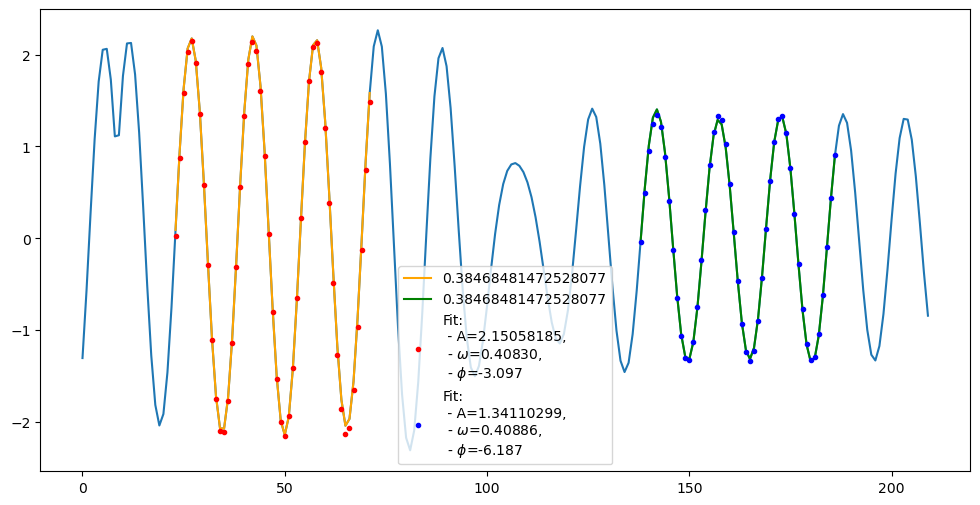

Plot


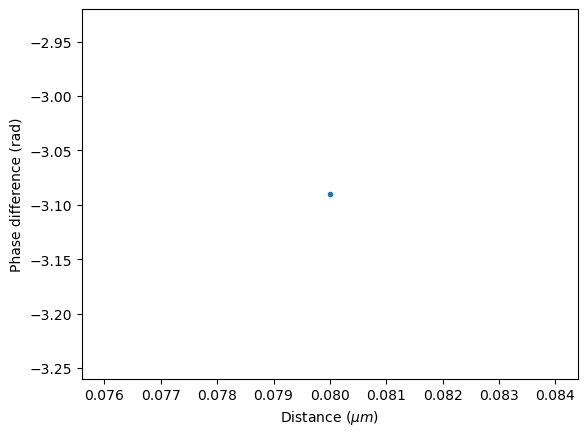

-----------
Initializing structure...
time for choose_chunkdivision = 0.000168085 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.063046 s
-----------


FloatProgress(value=0.0, description='0% done ', max=600.0)

Meep progress: 499.90625/600.0 = 83.3% done in 4.0s, 0.8s to go
on time step 16011 (time=500.344), 0.000249856 s/step
run 0 finished at t = 600.0 (19200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000172853 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     cylinder, center = (0,0.0869388,0)
          radius 2.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
     cylinder, center = (0,0.0869388,0)
          radius 2, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.116479 s
-----------


FloatProgress(value=0.0, description='0% done ', max=600.0)

Meep progress: 370.21875/600.0 = 61.7% done in 4.0s, 2.5s to go
on time step 11854 (time=370.438), 0.000337446 s/step
harminv0:, frequency, imag. freq., Q, |amp|, amplitude, error
harminv0:, 0.7045640963854944, -0.0021053294309063687, 167.32870543736507, 0.04539070722021567, -0.008871194714614714+0.044515370449842724i, 2.243188264013273e-11+0.0i
run 0 finished at t = 600.0 (19200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000379086 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.156282 s
-----------


FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 155.71875/1000.0 = 15.6% done in 4.0s, 21.7s to go
on time step 4990 (time=155.938), 0.000801698 s/step
Meep progress: 314.03125/1000.0 = 31.4% done in 8.0s, 17.5s to go
on time step 10057 (time=314.281), 0.000789502 s/step
Meep progress: 472.03125/1000.0 = 47.2% done in 12.0s, 13.4s to go
on time step 15115 (time=472.344), 0.000790842 s/step
Meep progress: 610.71875/1000.0 = 61.1% done in 16.0s, 10.2s to go
on time step 19555 (time=611.094), 0.000901008 s/step
Meep progress: 767.90625/1000.0 = 76.8% done in 20.0s, 6.0s to go
on time step 24586 (time=768.312), 0.000795151 s/step
Meep progress: 925.40625/1000.0 = 92.5% done in 24.0s, 1.9s to go
on time step 29627 (time=925.844), 0.00079359 s/step
run 0 finished at t = 1000.0 (32000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00031209 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     cylinder, center = (0,0.0869388,0)
          radius 2.5, height 1e

FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 154.71875/1000.0 = 15.5% done in 4.0s, 21.9s to go
on time step 4957 (time=154.906), 0.000807226 s/step
Meep progress: 307.875/1000.0 = 30.8% done in 8.0s, 18.0s to go
on time step 9859 (time=308.094), 0.000816154 s/step
Meep progress: 466.03125/1000.0 = 46.6% done in 12.0s, 13.8s to go
on time step 14922 (time=466.312), 0.000790142 s/step
Meep progress: 671.15625/1000.0 = 67.1% done in 16.0s, 7.8s to go
on time step 21495 (time=671.719), 0.000608629 s/step
Meep progress: 904.96875/1000.0 = 90.5% done in 20.0s, 2.1s to go
on time step 28978 (time=905.562), 0.000534662 s/step
run 0 finished at t = 1000.0 (32000 timesteps)


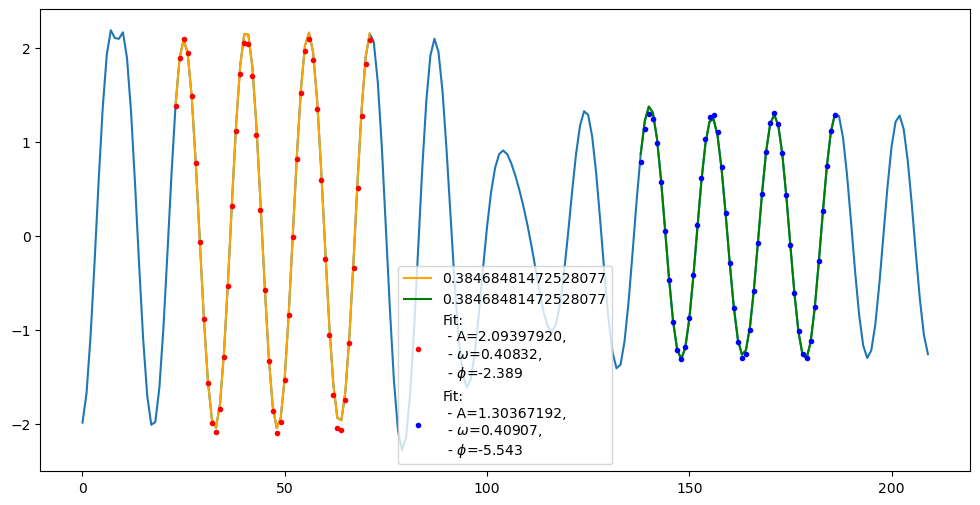

Plot


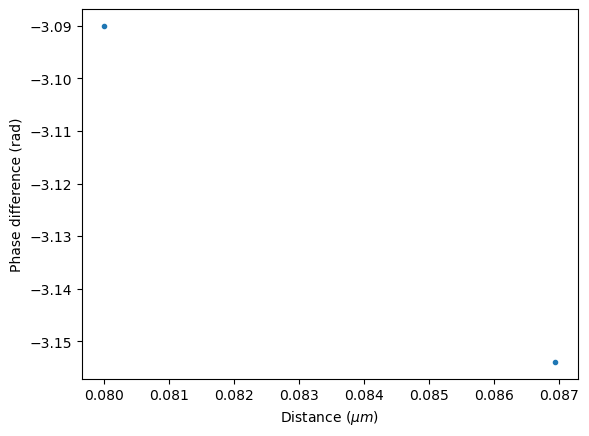

-----------
Initializing structure...
time for choose_chunkdivision = 0.000328064 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.156835 s
-----------


FloatProgress(value=0.0, description='0% done ', max=600.0)

Meep progress: 233.6875/600.0 = 38.9% done in 4.0s, 6.3s to go
on time step 7500 (time=234.375), 0.000533401 s/step
Meep progress: 471.3125/600.0 = 78.6% done in 8.0s, 2.2s to go
on time step 15111 (time=472.219), 0.000525626 s/step
run 0 finished at t = 600.0 (19200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000354052 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     cylinder, center = (0,0.0938776,0)
          radius 2.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
     cylinder, center = (0,0.0938776,0)
          radius 2, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.26194 s
-----------


FloatProgress(value=0.0, description='0% done ', max=600.0)

Meep progress: 228.125/600.0 = 38.0% done in 4.0s, 6.5s to go
on time step 7311 (time=228.469), 0.000547191 s/step
Meep progress: 456.25/600.0 = 76.0% done in 8.0s, 2.5s to go
on time step 14615 (time=456.719), 0.000547655 s/step
harminv0:, frequency, imag. freq., Q, |amp|, amplitude, error
harminv0:, 0.7044705986165747, -0.001991859376308525, 176.83743315307646, 0.046857437858470415, -0.011243742703336359+0.0454884351531418i, 5.392103970732002e-11+0.0i
run 0 finished at t = 600.0 (19200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.0003829 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.178441 s
-----------


FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 140.625/1000.0 = 14.1% done in 4.0s, 24.4s to go
on time step 4505 (time=140.781), 0.000888042 s/step
Meep progress: 278.21875/1000.0 = 27.8% done in 8.0s, 20.8s to go
on time step 8911 (time=278.469), 0.000908125 s/step
Meep progress: 417.65625/1000.0 = 41.8% done in 12.0s, 16.7s to go
on time step 13375 (time=417.969), 0.000896215 s/step
Meep progress: 551.0625/1000.0 = 55.1% done in 16.0s, 13.0s to go
on time step 17642 (time=551.312), 0.00093744 s/step
Meep progress: 701.21875/1000.0 = 70.1% done in 20.0s, 8.5s to go
on time step 22458 (time=701.812), 0.000830592 s/step
Meep progress: 922.6875/1000.0 = 92.3% done in 24.0s, 2.0s to go
on time step 29545 (time=923.281), 0.000564431 s/step
run 0 finished at t = 1000.0 (32000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000206947 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     cylinder, center = (0,0.0938776,0)
          radius 2.5, height 1e+20,

FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 215.59375/1000.0 = 21.6% done in 4.0s, 14.6s to go
on time step 6909 (time=215.906), 0.000578999 s/step
Meep progress: 435.125/1000.0 = 43.5% done in 8.0s, 10.4s to go
on time step 13936 (time=435.5), 0.000569301 s/step
Meep progress: 654.84375/1000.0 = 65.5% done in 12.0s, 6.3s to go
on time step 20965 (time=655.156), 0.000569076 s/step
Meep progress: 875.5625/1000.0 = 87.6% done in 16.0s, 2.3s to go
on time step 28036 (time=876.125), 0.000565711 s/step
run 0 finished at t = 1000.0 (32000 timesteps)


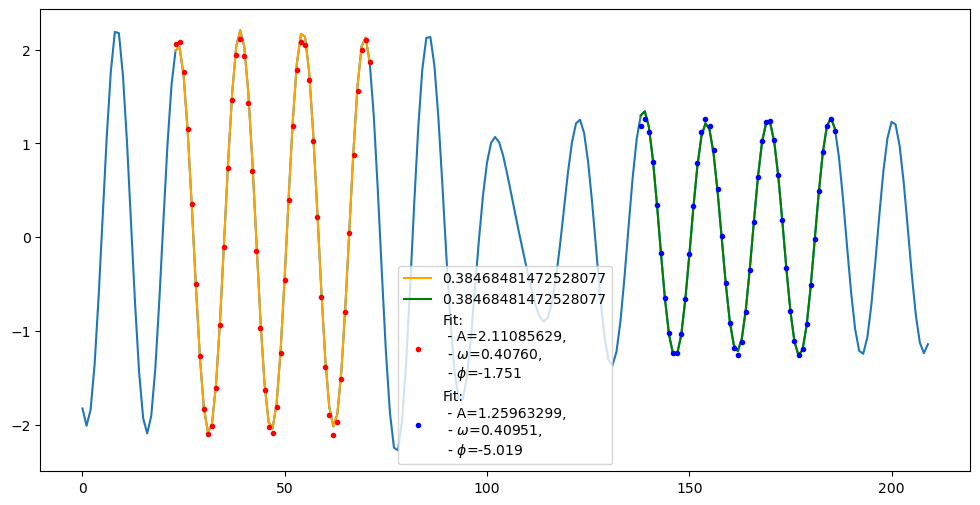

Plot


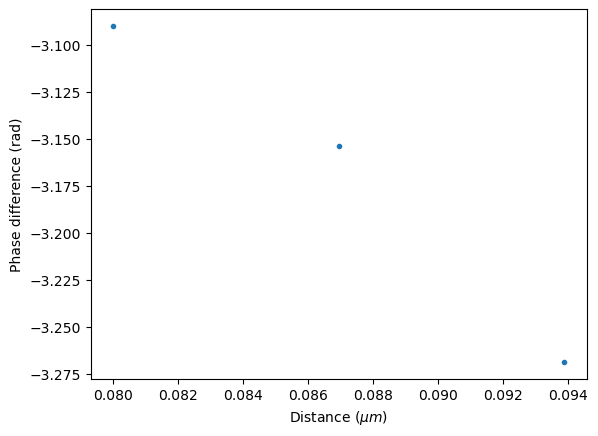

-----------
Initializing structure...
time for choose_chunkdivision = 0.000193834 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.077457 s
-----------


FloatProgress(value=0.0, description='0% done ', max=600.0)

Meep progress: 422.75/600.0 = 70.5% done in 4.0s, 1.7s to go
on time step 13537 (time=423.031), 0.000295502 s/step
run 0 finished at t = 600.0 (19200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000193119 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     cylinder, center = (0,0.100816,0)
          radius 2.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
     cylinder, center = (0,0.100816,0)
          radius 2, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.14773 s
-----------


FloatProgress(value=0.0, description='0% done ', max=600.0)

Meep progress: 405.8125/600.0 = 67.6% done in 4.0s, 1.9s to go
on time step 13006 (time=406.438), 0.000307575 s/step
harminv0:, frequency, imag. freq., Q, |amp|, amplitude, error
harminv0:, 0.7043774434458434, -0.001891011905652047, 186.24352425823685, 0.048174726911808345, -0.01370453297065797+0.046184305657695664i, 2.3969902739875622e-11+0.0i
run 0 finished at t = 600.0 (19200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000226974 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.106568 s
-----------


FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 221.46875/1000.0 = 22.1% done in 4.0s, 14.1s to go
on time step 7089 (time=221.531), 0.000564301 s/step
Meep progress: 442.40625/1000.0 = 44.2% done in 8.0s, 10.1s to go
on time step 14159 (time=442.469), 0.000565823 s/step
Meep progress: 662.84375/1000.0 = 66.3% done in 12.0s, 6.1s to go
on time step 21219 (time=663.094), 0.000566597 s/step
Meep progress: 854.25/1000.0 = 85.4% done in 16.0s, 2.7s to go
on time step 27342 (time=854.438), 0.000653282 s/step
run 0 finished at t = 1000.0 (32000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     cylinder, center = (0,0.100816,0)
          radius 2.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
     cylinder, center = (0,0.100816,0)
          radius 2, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, c

FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 201.40625/1000.0 = 20.1% done in 4.0s, 15.9s to go
on time step 6454 (time=201.688), 0.000619819 s/step
Meep progress: 433.34375/1000.0 = 43.3% done in 8.0s, 10.5s to go
on time step 13879 (time=433.719), 0.00053881 s/step
Meep progress: 674.28125/1000.0 = 67.4% done in 12.0s, 5.8s to go
on time step 21590 (time=674.688), 0.000518747 s/step
Meep progress: 916.21875/1000.0 = 91.6% done in 16.0s, 1.5s to go
on time step 29333 (time=916.656), 0.000516629 s/step
run 0 finished at t = 1000.0 (32000 timesteps)


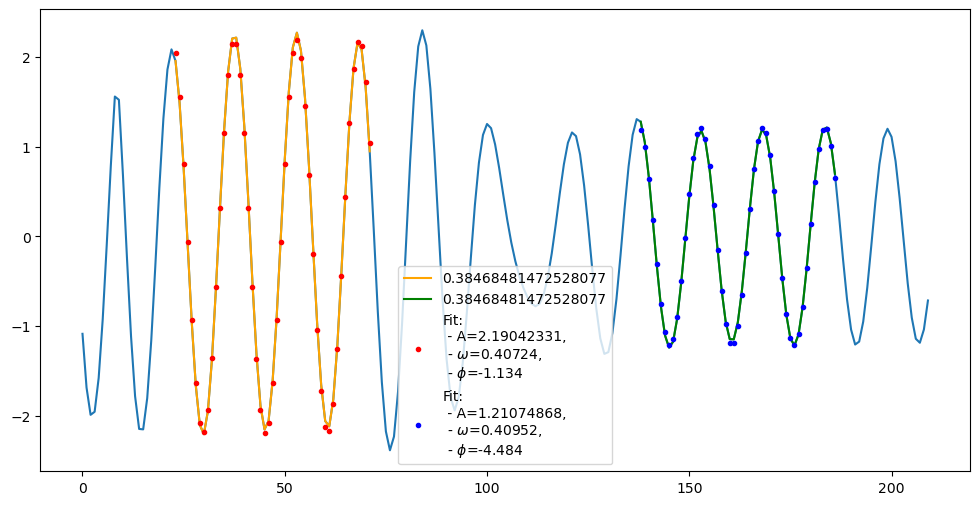

Plot


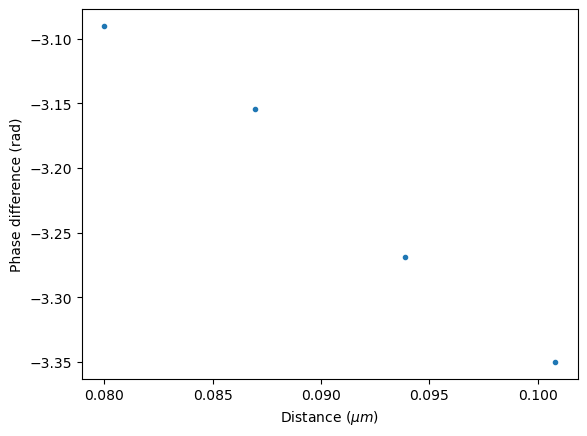

-----------
Initializing structure...
time for choose_chunkdivision = 0.000169992 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.0624549 s
-----------


FloatProgress(value=0.0, description='0% done ', max=600.0)

Meep progress: 519.5/600.0 = 86.6% done in 4.0s, 0.6s to go
on time step 16641 (time=520.031), 0.00024037 s/step
run 0 finished at t = 600.0 (19200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000169039 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     cylinder, center = (0,0.107755,0)
          radius 2.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
     cylinder, center = (0,0.107755,0)
          radius 2, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.11769 s
-----------


FloatProgress(value=0.0, description='0% done ', max=600.0)

Meep progress: 463.1875/600.0 = 77.2% done in 4.0s, 1.2s to go
on time step 14830 (time=463.438), 0.000269754 s/step
harminv0:, frequency, imag. freq., Q, |amp|, amplitude, error
harminv0:, 0.7042948060803313, -0.0017969126477164882, 195.973579176302, 0.04946972218307755, -0.015987850294079696+0.04681497683268647i, 1.8165512717079688e-10+0.0i
run 0 finished at t = 600.0 (19200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000242949 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.169978 s
-----------


FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 262.96875/1000.0 = 26.3% done in 4.0s, 11.2s to go
on time step 8419 (time=263.094), 0.000475155 s/step
Meep progress: 433.65625/1000.0 = 43.4% done in 8.0s, 10.4s to go
on time step 13883 (time=433.844), 0.000732105 s/step
Meep progress: 604.375/1000.0 = 60.4% done in 12.0s, 7.9s to go
on time step 19347 (time=604.594), 0.000732183 s/step
Meep progress: 776.65625/1000.0 = 77.7% done in 16.0s, 4.6s to go
on time step 24862 (time=776.938), 0.000725412 s/step
Meep progress: 949.875/1000.0 = 95.0% done in 20.0s, 1.1s to go
on time step 30407 (time=950.219), 0.000721483 s/step
run 0 finished at t = 1000.0 (32000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00040102 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     cylinder, center = (0,0.107755,0)
          radius 2.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
     cylinder, center = (0,0.107755,0)
 

FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 165.375/1000.0 = 16.5% done in 4.0s, 20.2s to go
on time step 5300 (time=165.625), 0.000754848 s/step
Meep progress: 328.28125/1000.0 = 32.8% done in 8.0s, 16.4s to go
on time step 10516 (time=328.625), 0.000766929 s/step
Meep progress: 531.0625/1000.0 = 53.1% done in 12.0s, 10.6s to go
on time step 17014 (time=531.688), 0.000615608 s/step
Meep progress: 792.625/1000.0 = 79.3% done in 16.0s, 4.2s to go
on time step 25384 (time=793.25), 0.000477919 s/step
run 0 finished at t = 1000.0 (32000 timesteps)


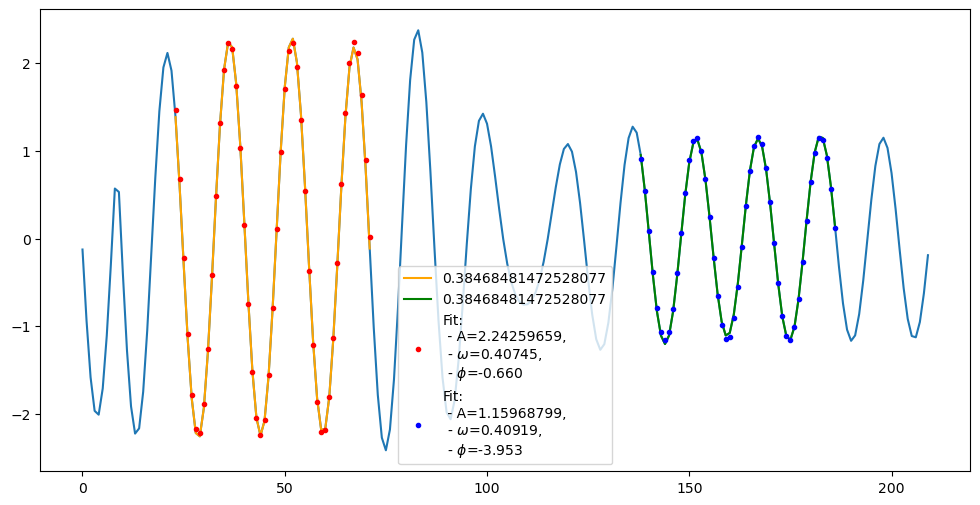

Plot


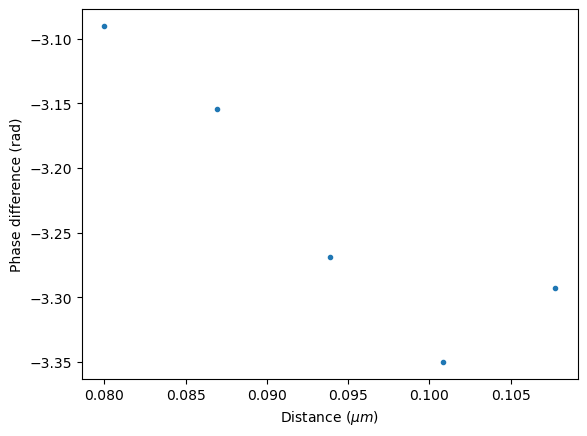

-----------
Initializing structure...
time for choose_chunkdivision = 0.000160933 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.0778859 s
-----------


FloatProgress(value=0.0, description='0% done ', max=600.0)

Meep progress: 494.28125/600.0 = 82.4% done in 4.0s, 0.9s to go
on time step 15837 (time=494.906), 0.000252585 s/step
run 0 finished at t = 600.0 (19200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000173092 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     cylinder, center = (0,0.114694,0)
          radius 2.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
     cylinder, center = (0,0.114694,0)
          radius 2, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.118281 s
-----------


FloatProgress(value=0.0, description='0% done ', max=600.0)

Meep progress: 412.0625/600.0 = 68.7% done in 4.0s, 1.8s to go
on time step 13201 (time=412.531), 0.000303027 s/step
harminv0:, frequency, imag. freq., Q, |amp|, amplitude, error
harminv0:, 0.7042208350472121, -0.001708811971229429, 206.0556828088436, 0.050752125628038214, -0.018098789904227294+0.0474153146121252i, 3.076313671422088e-10+0.0i
run 0 finished at t = 600.0 (19200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000197887 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.10815 s
-----------


FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 209.25/1000.0 = 20.9% done in 4.0s, 15.1s to go
on time step 6709 (time=209.656), 0.000596231 s/step
Meep progress: 434.875/1000.0 = 43.5% done in 8.0s, 10.4s to go
on time step 13931 (time=435.344), 0.000553917 s/step
Meep progress: 672.1875/1000.0 = 67.2% done in 12.0s, 5.9s to go
on time step 21525 (time=672.656), 0.000526772 s/step
Meep progress: 912.1875/1000.0 = 91.2% done in 16.0s, 1.5s to go
on time step 29208 (time=912.75), 0.000520661 s/step
run 0 finished at t = 1000.0 (32000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00018692 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     cylinder, center = (0,0.114694,0)
          radius 2.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
     cylinder, center = (0,0.114694,0)
          radius 2, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center 

FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 239.21875/1000.0 = 23.9% done in 4.0s, 12.7s to go
on time step 7663 (time=239.469), 0.00052204 s/step
Meep progress: 479.5625/1000.0 = 48.0% done in 8.0s, 8.7s to go
on time step 15355 (time=479.844), 0.000520124 s/step
Meep progress: 718.28125/1000.0 = 71.8% done in 12.0s, 4.7s to go
on time step 22997 (time=718.656), 0.000523502 s/step
Meep progress: 951.21875/1000.0 = 95.1% done in 16.0s, 0.8s to go
on time step 30450 (time=951.562), 0.00053672 s/step
run 0 finished at t = 1000.0 (32000 timesteps)


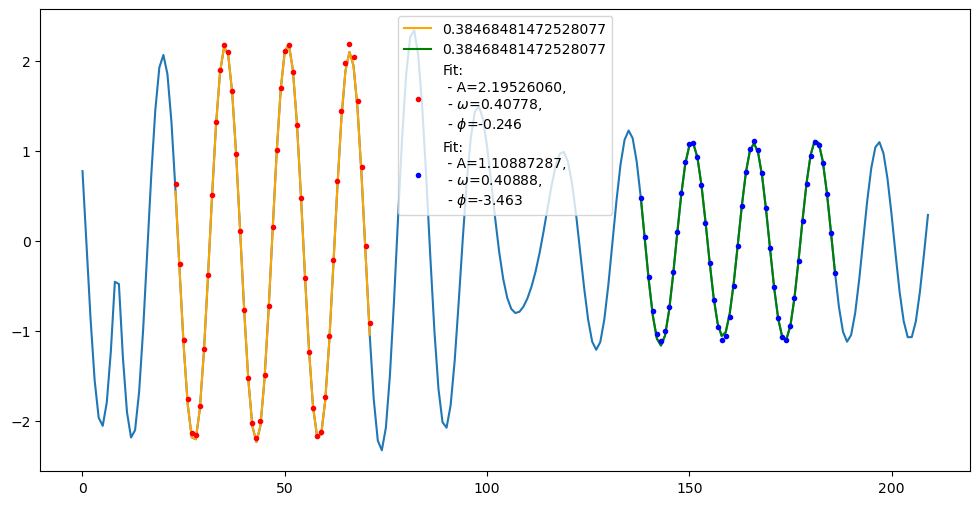

Plot


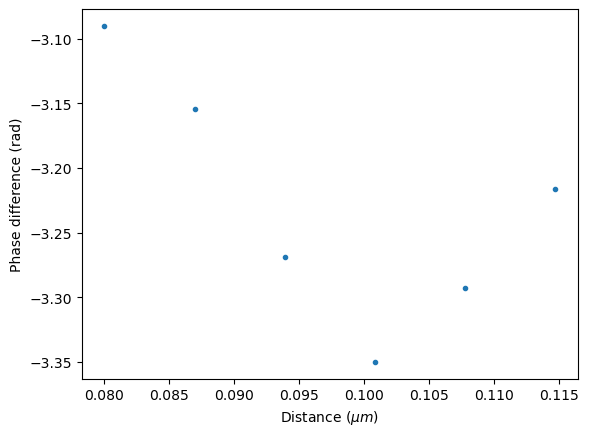

-----------
Initializing structure...
time for choose_chunkdivision = 0.000154018 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.06707 s
-----------


FloatProgress(value=0.0, description='0% done ', max=600.0)

Meep progress: 523.84375/600.0 = 87.3% done in 4.0s, 0.6s to go
on time step 16776 (time=524.25), 0.000238448 s/step
run 0 finished at t = 600.0 (19200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00018692 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     cylinder, center = (0,0.121633,0)
          radius 2.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
     cylinder, center = (0,0.121633,0)
          radius 2, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.116124 s
-----------


FloatProgress(value=0.0, description='0% done ', max=600.0)

Meep progress: 461.28125/600.0 = 76.9% done in 4.0s, 1.2s to go
on time step 14778 (time=461.812), 0.000270688 s/step
harminv0:, frequency, imag. freq., Q, |amp|, amplitude, error
harminv0:, 0.7041476946718205, -0.001627002617309609, 216.39414933338898, 0.05201258920680526, -0.020229202328003168+0.047917520899652i, 2.77159426881216e-10+0.0i
run 0 finished at t = 600.0 (19200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000381947 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.160365 s
-----------


FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 161.375/1000.0 = 16.1% done in 4.0s, 20.8s to go
on time step 5170 (time=161.562), 0.000773708 s/step
Meep progress: 324.65625/1000.0 = 32.5% done in 8.0s, 16.6s to go
on time step 10397 (time=324.906), 0.000765367 s/step
Meep progress: 487.4375/1000.0 = 48.7% done in 12.0s, 12.6s to go
on time step 15607 (time=487.719), 0.00076777 s/step
Meep progress: 650.59375/1000.0 = 65.1% done in 16.0s, 8.6s to go
on time step 20831 (time=650.969), 0.000765824 s/step
Meep progress: 810.78125/1000.0 = 81.1% done in 20.0s, 4.7s to go
on time step 25959 (time=811.219), 0.000780172 s/step
Meep progress: 976.0/1000.0 = 97.6% done in 24.0s, 0.6s to go
on time step 31247 (time=976.469), 0.000756576 s/step
run 0 finished at t = 1000.0 (32000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000312805 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     cylinder, center = (0,0.121633,0)
          radius 2.5, height 1e+20, axi

FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 162.25/1000.0 = 16.2% done in 4.0s, 20.7s to go
on time step 5198 (time=162.438), 0.000769649 s/step
Meep progress: 324.75/1000.0 = 32.5% done in 8.0s, 16.6s to go
on time step 10400 (time=325), 0.000769065 s/step
Meep progress: 479.375/1000.0 = 47.9% done in 12.0s, 13.0s to go
on time step 15350 (time=479.688), 0.000808112 s/step
Meep progress: 639.875/1000.0 = 64.0% done in 16.0s, 9.0s to go
on time step 20487 (time=640.219), 0.000778769 s/step
Meep progress: 814.03125/1000.0 = 81.4% done in 20.0s, 4.6s to go
on time step 26070 (time=814.688), 0.000716529 s/step
run 0 finished at t = 1000.0 (32000 timesteps)


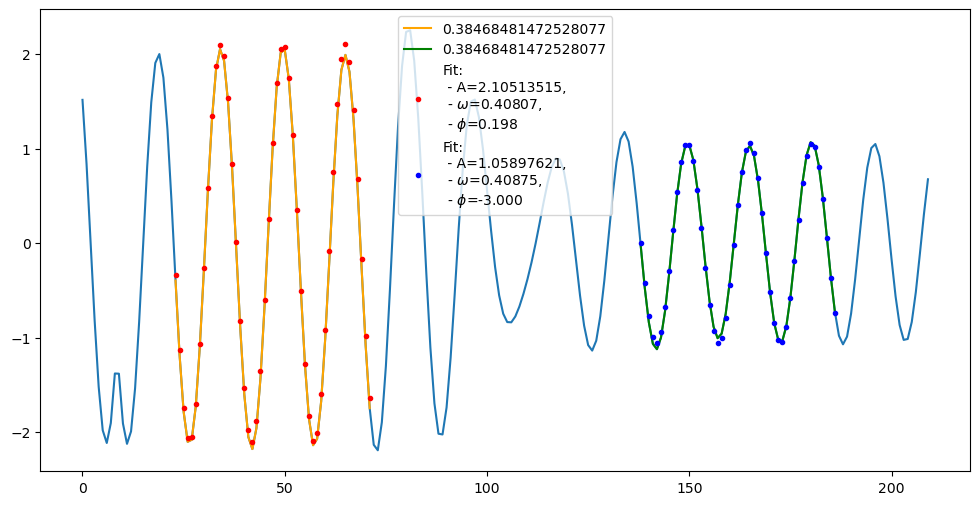

Plot


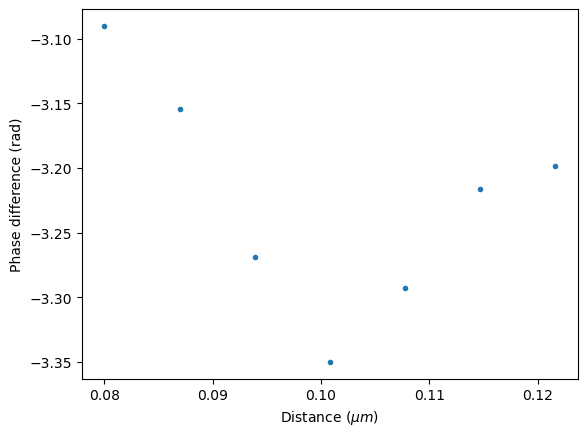

-----------
Initializing structure...
time for choose_chunkdivision = 0.000228882 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.0645881 s
-----------


FloatProgress(value=0.0, description='0% done ', max=600.0)

Meep progress: 512.90625/600.0 = 85.5% done in 4.0s, 0.7s to go
on time step 16433 (time=513.531), 0.000243418 s/step
run 0 finished at t = 600.0 (19200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000172853 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     cylinder, center = (0,0.128571,0)
          radius 2.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
     cylinder, center = (0,0.128571,0)
          radius 2, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.120519 s
-----------


FloatProgress(value=0.0, description='0% done ', max=600.0)

Meep progress: 479.9375/600.0 = 80.0% done in 4.0s, 1.0s to go
on time step 15371 (time=480.344), 0.000260238 s/step
harminv0:, frequency, imag. freq., Q, |amp|, amplitude, error
harminv0:, 0.7040716105656911, -0.0015512285722560195, 226.9399955487311, 0.05269821507345563, -0.022251943378822307+0.04776979053537782i, 1.520261338235919e-10+0.0i
run 0 finished at t = 600.0 (19200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000197887 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.115622 s
-----------


FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 245.3125/1000.0 = 24.5% done in 4.0s, 12.3s to go
on time step 7863 (time=245.719), 0.000508774 s/step
Meep progress: 499.25/1000.0 = 49.9% done in 8.0s, 8.0s to go
on time step 15991 (time=499.719), 0.000492172 s/step
Meep progress: 745.09375/1000.0 = 74.5% done in 12.0s, 4.1s to go
on time step 23857 (time=745.531), 0.000508527 s/step
Meep progress: 991.21875/1000.0 = 99.1% done in 16.0s, 0.1s to go
on time step 31739 (time=991.844), 0.000507518 s/step
run 0 finished at t = 1000.0 (32000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000220776 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     cylinder, center = (0,0.128571,0)
          radius 2.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
     cylinder, center = (0,0.128571,0)
          radius 2, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, cen

FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 238.5625/1000.0 = 23.9% done in 4.0s, 12.8s to go
on time step 7642 (time=238.812), 0.000523435 s/step
Meep progress: 478.0625/1000.0 = 47.8% done in 8.0s, 8.7s to go
on time step 15304 (time=478.25), 0.00052208 s/step
Meep progress: 720.3125/1000.0 = 72.0% done in 12.0s, 4.7s to go
on time step 23060 (time=720.625), 0.000515793 s/step
Meep progress: 910.78125/1000.0 = 91.1% done in 16.0s, 1.6s to go
on time step 29156 (time=911.125), 0.000656204 s/step
run 0 finished at t = 1000.0 (32000 timesteps)


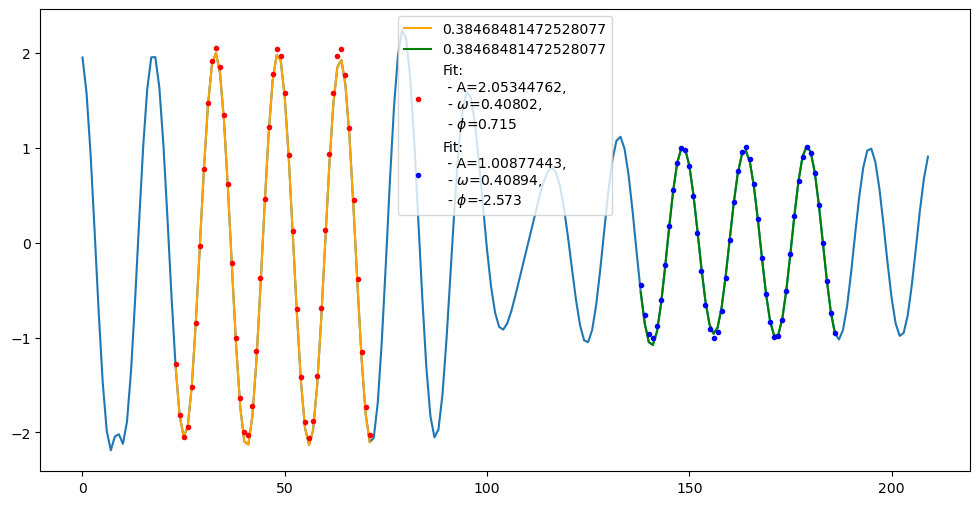

Plot


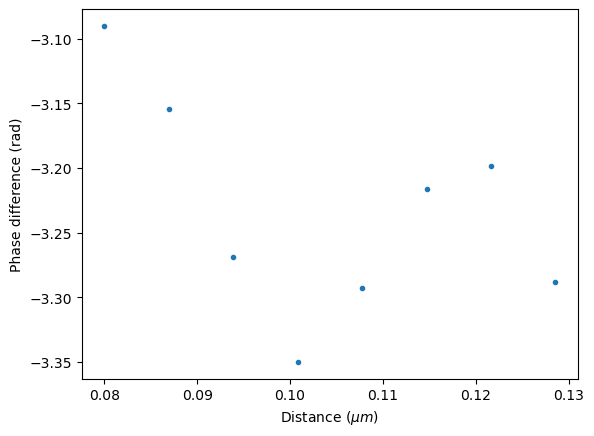

-----------
Initializing structure...
time for choose_chunkdivision = 0.000257015 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.137028 s
-----------


FloatProgress(value=0.0, description='0% done ', max=600.0)

Meep progress: 454.125/600.0 = 75.7% done in 4.0s, 1.3s to go
on time step 14544 (time=454.5), 0.000275058 s/step
run 0 finished at t = 600.0 (19200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000167847 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     cylinder, center = (0,0.13551,0)
          radius 2.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
     cylinder, center = (0,0.13551,0)
          radius 2, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.191895 s
-----------


FloatProgress(value=0.0, description='0% done ', max=600.0)

Meep progress: 478.5625/600.0 = 79.8% done in 4.0s, 1.0s to go
on time step 15343 (time=479.469), 0.000260711 s/step
harminv0:, frequency, imag. freq., Q, |amp|, amplitude, error
harminv0:, 0.7039931437927366, -0.0014807037672008598, 237.7224801432003, 0.052840515511814956, -0.024170461096407633+0.04698839101247671i, 3.853983673406534e-11+0.0i
run 0 finished at t = 600.0 (19200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000298023 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.171346 s
-----------


FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 243.125/1000.0 = 24.3% done in 4.0s, 12.5s to go
on time step 7792 (time=243.5), 0.000513432 s/step
Meep progress: 489.3125/1000.0 = 48.9% done in 8.0s, 8.4s to go
on time step 15668 (time=489.625), 0.000507934 s/step
Meep progress: 743.0625/1000.0 = 74.3% done in 12.0s, 4.1s to go
on time step 23791 (time=743.469), 0.000492448 s/step
Meep progress: 998.59375/1000.0 = 99.9% done in 16.0s, 0.0s to go
on time step 31972 (time=999.125), 0.000488957 s/step
run 0 finished at t = 1000.0 (32000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000213146 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     cylinder, center = (0,0.13551,0)
          radius 2.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
     cylinder, center = (0,0.13551,0)
          radius 2, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center 

FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 252.46875/1000.0 = 25.2% done in 4.0s, 11.8s to go
on time step 8087 (time=252.719), 0.000494624 s/step
Meep progress: 493.4375/1000.0 = 49.3% done in 8.0s, 8.2s to go
on time step 15802 (time=493.812), 0.000518481 s/step
Meep progress: 738.6875/1000.0 = 73.9% done in 12.0s, 4.2s to go
on time step 23645 (time=738.906), 0.000510077 s/step
Meep progress: 945.25/1000.0 = 94.5% done in 16.0s, 0.9s to go
on time step 30259 (time=945.594), 0.000604818 s/step
run 0 finished at t = 1000.0 (32000 timesteps)


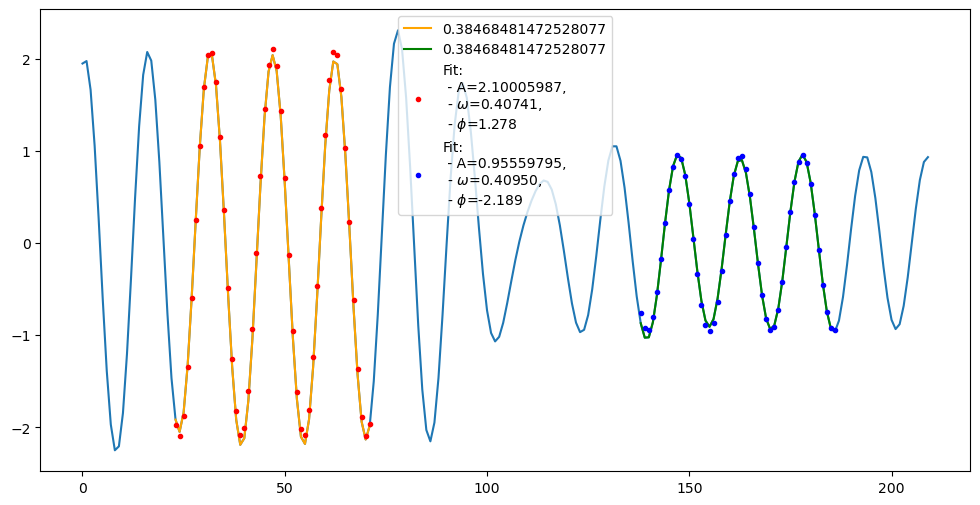

Plot


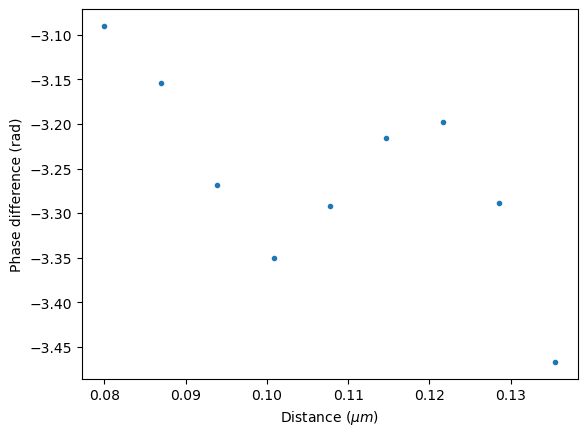

-----------
Initializing structure...
time for choose_chunkdivision = 0.000324965 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.0949349 s
-----------


FloatProgress(value=0.0, description='0% done ', max=600.0)

Meep progress: 529.84375/600.0 = 88.3% done in 4.0s, 0.5s to go
on time step 16980 (time=530.625), 0.000235589 s/step
run 0 finished at t = 600.0 (19200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000360966 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     cylinder, center = (0,0.142449,0)
          radius 2.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
     cylinder, center = (0,0.142449,0)
          radius 2, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.121925 s
-----------


FloatProgress(value=0.0, description='0% done ', max=600.0)

Meep progress: 448.28125/600.0 = 74.7% done in 4.0s, 1.4s to go
on time step 14358 (time=448.688), 0.00027866 s/step
harminv0:, frequency, imag. freq., Q, |amp|, amplitude, error
harminv0:, 0.7039169269145611, -0.0014139867923335103, 248.91212942409564, 0.05297247484510211, -0.02607243909846104+0.04611194000117558i, 2.9453415941846e-11+0.0i
run 0 finished at t = 600.0 (19200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000335932 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.167446 s
-----------


FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 162.5/1000.0 = 16.2% done in 4.0s, 20.6s to go
on time step 5206 (time=162.688), 0.000768387 s/step
Meep progress: 327.84375/1000.0 = 32.8% done in 8.0s, 16.4s to go
on time step 10499 (time=328.094), 0.000755897 s/step
Meep progress: 491.46875/1000.0 = 49.1% done in 12.0s, 12.4s to go
on time step 15735 (time=491.719), 0.000764041 s/step
Meep progress: 655.03125/1000.0 = 65.5% done in 16.0s, 8.4s to go
on time step 20972 (time=655.375), 0.000764036 s/step
Meep progress: 817.8125/1000.0 = 81.8% done in 20.0s, 4.5s to go
on time step 26183 (time=818.219), 0.000767684 s/step
Meep progress: 975.15625/1000.0 = 97.5% done in 24.0s, 0.6s to go
on time step 31221 (time=975.656), 0.000794067 s/step
run 0 finished at t = 1000.0 (32000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000309944 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     cylinder, center = (0,0.142449,0)
          radius 2.5, height 1e+20, 

FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 158.3125/1000.0 = 15.8% done in 4.0s, 21.3s to go
on time step 5073 (time=158.531), 0.000788691 s/step
Meep progress: 343.71875/1000.0 = 34.4% done in 8.0s, 15.3s to go
on time step 11016 (time=344.25), 0.000673071 s/step
Meep progress: 602.65625/1000.0 = 60.3% done in 12.0s, 7.9s to go
on time step 19301 (time=603.156), 0.000482809 s/step
Meep progress: 860.3125/1000.0 = 86.0% done in 16.0s, 2.6s to go
on time step 27549 (time=860.906), 0.000485028 s/step
run 0 finished at t = 1000.0 (32000 timesteps)


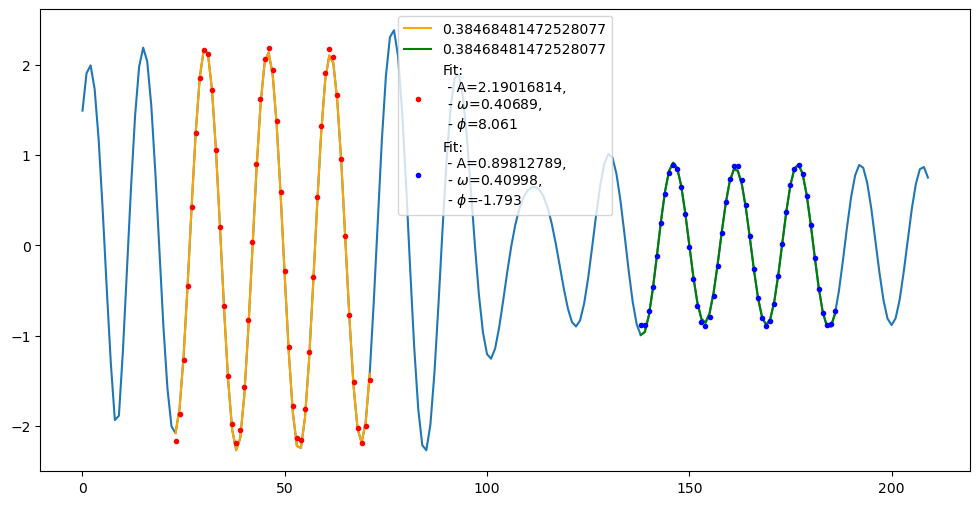

up shift in phase
Plot


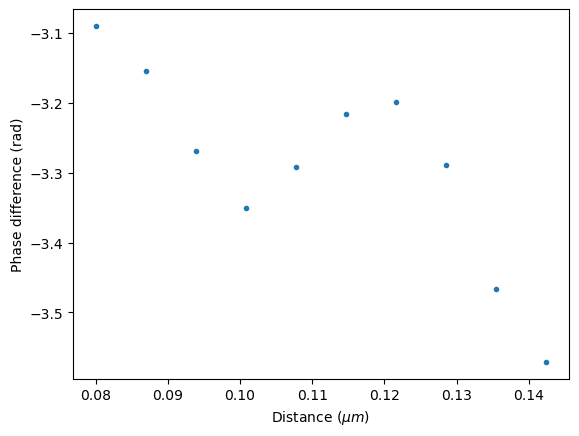

-----------
Initializing structure...
time for choose_chunkdivision = 0.000157118 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.0905218 s
-----------


FloatProgress(value=0.0, description='0% done ', max=600.0)

Meep progress: 496.6875/600.0 = 82.8% done in 4.0s, 0.8s to go
on time step 15914 (time=497.312), 0.000251363 s/step
run 0 finished at t = 600.0 (19200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000168085 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     cylinder, center = (0,0.149388,0)
          radius 2.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
     cylinder, center = (0,0.149388,0)
          radius 2, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.116974 s
-----------


FloatProgress(value=0.0, description='0% done ', max=600.0)

Meep progress: 502.21875/600.0 = 83.7% done in 4.0s, 0.8s to go
on time step 16093 (time=502.906), 0.00024857 s/step
harminv0:, frequency, imag. freq., Q, |amp|, amplitude, error
harminv0:, 0.7038510724201991, -0.0013494442587314026, 260.79294045160543, 0.053104562719493244, -0.027761686194370975+0.045270115542970106i, 9.808176625433198e-12+0.0i
run 0 finished at t = 600.0 (19200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000240803 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.128406 s
-----------


FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 249.90625/1000.0 = 25.0% done in 4.0s, 12.0s to go
on time step 8004 (time=250.125), 0.000499782 s/step
Meep progress: 505.34375/1000.0 = 50.5% done in 8.0s, 7.8s to go
on time step 16180 (time=505.625), 0.000489263 s/step
Meep progress: 759.46875/1000.0 = 75.9% done in 12.0s, 3.8s to go
on time step 24316 (time=759.875), 0.000491688 s/step
run 0 finished at t = 1000.0 (32000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.0001688 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     cylinder, center = (0,0.149388,0)
          radius 2.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
     cylinder, center = (0,0.149388,0)
          radius 2, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant eps

FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 247.65625/1000.0 = 24.8% done in 4.0s, 12.2s to go
on time step 7931 (time=247.844), 0.000504354 s/step
Meep progress: 497.5625/1000.0 = 49.8% done in 8.0s, 8.1s to go
on time step 15929 (time=497.781), 0.00050013 s/step
Meep progress: 741.875/1000.0 = 74.2% done in 12.0s, 4.2s to go
on time step 23753 (time=742.281), 0.000511315 s/step
Meep progress: 993.84375/1000.0 = 99.4% done in 16.0s, 0.1s to go
on time step 31817 (time=994.281), 0.00049606 s/step
run 0 finished at t = 1000.0 (32000 timesteps)


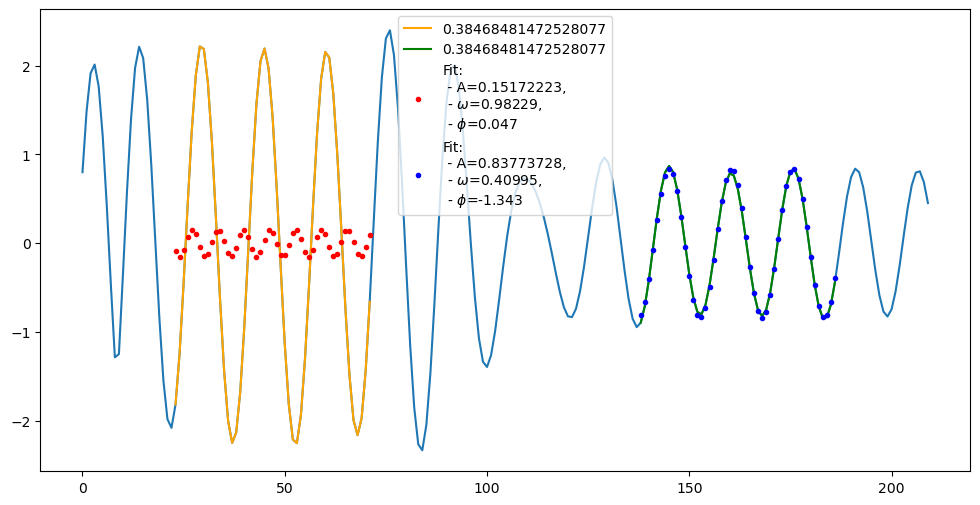

Plot


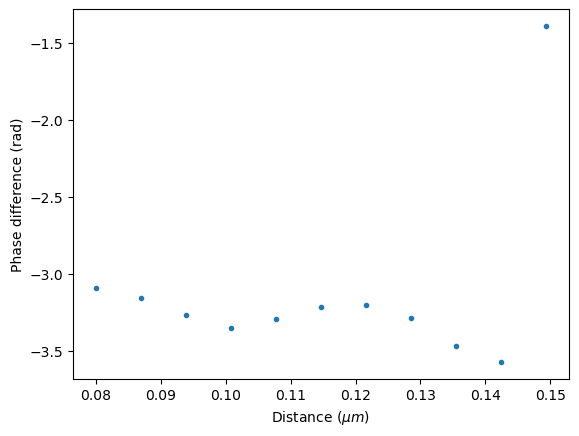

-----------
Initializing structure...
time for choose_chunkdivision = 0.000260115 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.088326 s
-----------


FloatProgress(value=0.0, description='0% done ', max=600.0)

Meep progress: 485.5625/600.0 = 80.9% done in 4.0s, 0.9s to go
on time step 15550 (time=485.938), 0.000257243 s/step
run 0 finished at t = 600.0 (19200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000163078 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     cylinder, center = (0,0.156327,0)
          radius 2.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
     cylinder, center = (0,0.156327,0)
          radius 2, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.166621 s
-----------


FloatProgress(value=0.0, description='0% done ', max=600.0)

Meep progress: 413.34375/600.0 = 68.9% done in 4.0s, 1.8s to go
on time step 13248 (time=414), 0.00030194 s/step
harminv0:, frequency, imag. freq., Q, |amp|, amplitude, error
harminv0:, 0.7037964342117331, -0.0012872064652181226, 273.3813312895658, 0.053212505619267964, -0.029166045733934384+0.044507443540678364i, 3.827906263866499e-11+0.0i
run 0 finished at t = 600.0 (19200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000363111 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.131511 s
-----------


FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 195.0/1000.0 = 19.5% done in 4.0s, 16.5s to go
on time step 6249 (time=195.281), 0.000640116 s/step
Meep progress: 443.375/1000.0 = 44.3% done in 8.0s, 10.0s to go
on time step 14200 (time=443.75), 0.000503105 s/step
Meep progress: 691.375/1000.0 = 69.1% done in 12.0s, 5.4s to go
on time step 22137 (time=691.781), 0.000504028 s/step
Meep progress: 930.25/1000.0 = 93.0% done in 16.0s, 1.2s to go
on time step 29782 (time=930.688), 0.000523266 s/step
run 0 finished at t = 1000.0 (32000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000191927 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     cylinder, center = (0,0.156327,0)
          radius 2.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
     cylinder, center = (0,0.156327,0)
          radius 2, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (

FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 238.84375/1000.0 = 23.9% done in 4.0s, 12.7s to go
on time step 7648 (time=239), 0.000523025 s/step
Meep progress: 484.0625/1000.0 = 48.4% done in 8.0s, 8.5s to go
on time step 15498 (time=484.312), 0.000509563 s/step
Meep progress: 731.75/1000.0 = 73.2% done in 12.0s, 4.4s to go
on time step 23427 (time=732.094), 0.000504624 s/step
Meep progress: 984.21875/1000.0 = 98.4% done in 16.0s, 0.3s to go
on time step 31505 (time=984.531), 0.000495241 s/step
run 0 finished at t = 1000.0 (32000 timesteps)


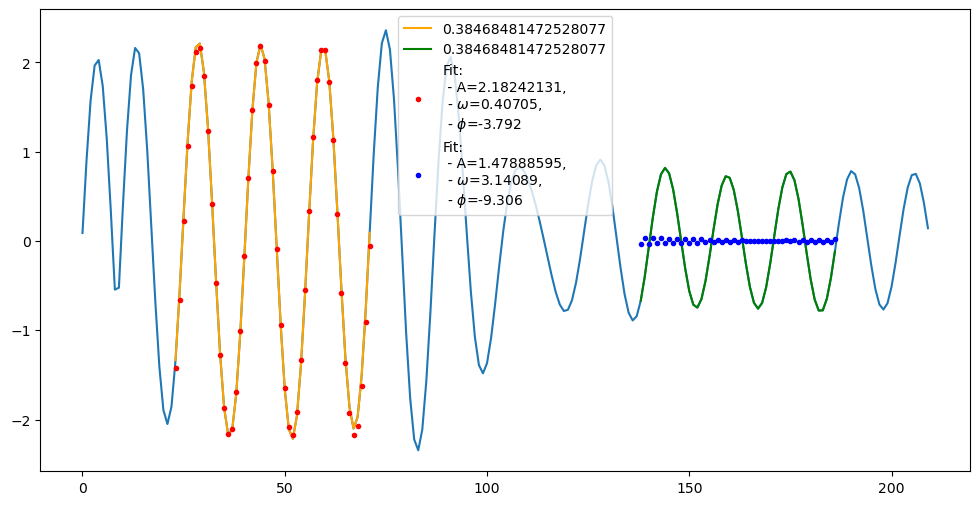

up shift in phase
Plot


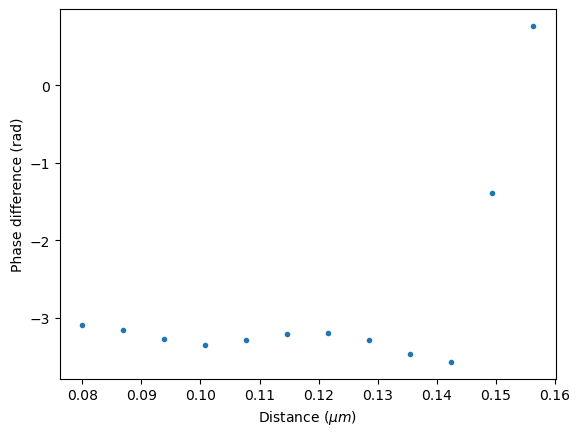

-----------
Initializing structure...
time for choose_chunkdivision = 0.000169992 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.0929561 s
-----------


FloatProgress(value=0.0, description='0% done ', max=600.0)

Meep progress: 503.53125/600.0 = 83.9% done in 4.0s, 0.8s to go
on time step 16130 (time=504.062), 0.000247994 s/step
run 0 finished at t = 600.0 (19200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000176907 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     cylinder, center = (0,0.163265,0)
          radius 2.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
     cylinder, center = (0,0.163265,0)
          radius 2, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.121815 s
-----------


FloatProgress(value=0.0, description='0% done ', max=600.0)

Meep progress: 489.15625/600.0 = 81.5% done in 4.0s, 0.9s to go
on time step 15675 (time=489.844), 0.000255215 s/step
harminv0:, frequency, imag. freq., Q, |amp|, amplitude, error
harminv0:, 0.70374123236167, -0.0012319087860510726, 285.6304136840916, 0.053251275782832994, -0.03053414901381357+0.04362756143198429i, 1.6842519774917674e-11+0.0i
run 0 finished at t = 600.0 (19200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00024581 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.124557 s
-----------


FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 191.71875/1000.0 = 19.2% done in 4.0s, 16.9s to go
on time step 6141 (time=191.906), 0.000651425 s/step
Meep progress: 354.15625/1000.0 = 35.4% done in 8.0s, 14.6s to go
on time step 11341 (time=354.406), 0.000769463 s/step
Meep progress: 508.0625/1000.0 = 50.8% done in 12.0s, 11.6s to go
on time step 16266 (time=508.312), 0.000812238 s/step
Meep progress: 669.84375/1000.0 = 67.0% done in 16.0s, 7.9s to go
on time step 21443 (time=670.094), 0.000772731 s/step
Meep progress: 833.1875/1000.0 = 83.3% done in 20.0s, 4.0s to go
on time step 26674 (time=833.562), 0.000764726 s/step
Meep progress: 998.8125/1000.0 = 99.9% done in 24.0s, 0.0s to go
on time step 31975 (time=999.219), 0.000754655 s/step
run 0 finished at t = 1000.0 (32000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000354052 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     cylinder, center = (0,0.163265,0)
          radius 2.5, height 1e+20

FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 161.03125/1000.0 = 16.1% done in 4.0s, 20.8s to go
on time step 5159 (time=161.219), 0.000775398 s/step
Meep progress: 401.0/1000.0 = 40.1% done in 8.0s, 12.0s to go
on time step 12844 (time=401.375), 0.000520518 s/step
Meep progress: 654.1875/1000.0 = 65.4% done in 12.0s, 6.3s to go
on time step 20948 (time=654.625), 0.000493683 s/step
Meep progress: 890.4375/1000.0 = 89.0% done in 16.0s, 2.0s to go
on time step 28509 (time=890.906), 0.000529059 s/step
run 0 finished at t = 1000.0 (32000 timesteps)


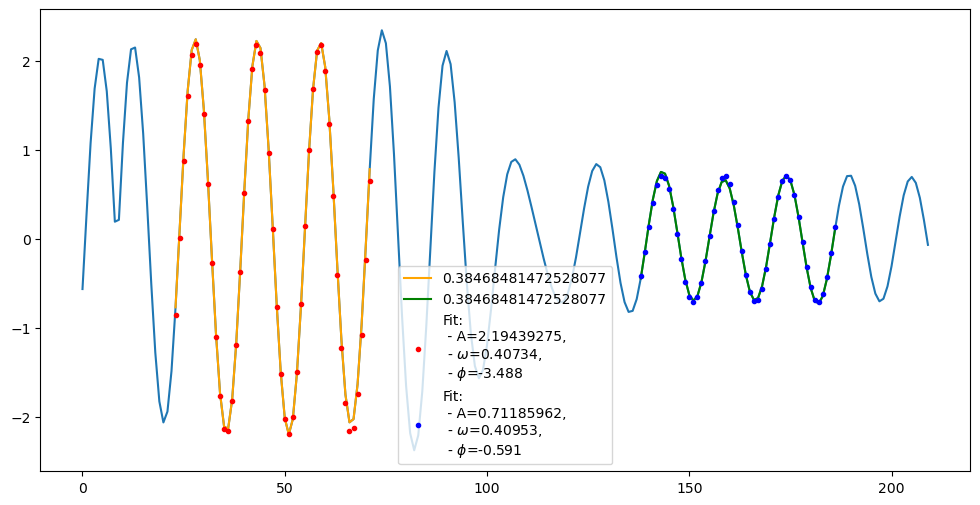

down shift in phase
Plot


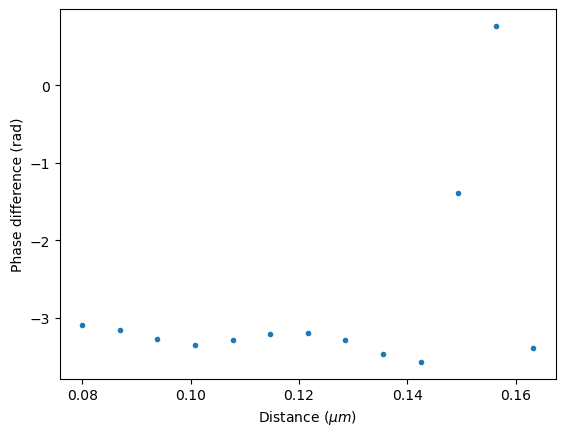

-----------
Initializing structure...
time for choose_chunkdivision = 0.000164986 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.0982449 s
-----------


FloatProgress(value=0.0, description='0% done ', max=600.0)

Meep progress: 469.34375/600.0 = 78.2% done in 4.0s, 1.1s to go
on time step 15041 (time=470.031), 0.000265947 s/step
run 0 finished at t = 600.0 (19200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     cylinder, center = (0,0.170204,0)
          radius 2.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
     cylinder, center = (0,0.170204,0)
          radius 2, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.129503 s
-----------


FloatProgress(value=0.0, description='0% done ', max=600.0)

Meep progress: 364.9375/600.0 = 60.8% done in 4.0s, 2.6s to go
on time step 11690 (time=365.312), 0.000342184 s/step
harminv0:, frequency, imag. freq., Q, |amp|, amplitude, error
harminv0:, 0.703694364616794, -0.0011801080406994094, 298.148279796373, 0.05331607253942513, -0.03168805025681691+0.0428773956992573i, 1.0725109338166001e-11+0.0i
run 0 finished at t = 600.0 (19200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000204086 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.125029 s
-----------


FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 142.625/1000.0 = 14.3% done in 4.0s, 24.0s to go
on time step 4567 (time=142.719), 0.000876039 s/step
Meep progress: 289.875/1000.0 = 29.0% done in 8.0s, 19.6s to go
on time step 9284 (time=290.125), 0.000848093 s/step
Meep progress: 453.65625/1000.0 = 45.4% done in 12.0s, 14.5s to go
on time step 14524 (time=453.875), 0.000763416 s/step
Meep progress: 602.84375/1000.0 = 60.3% done in 16.0s, 10.5s to go
on time step 19300 (time=603.125), 0.000837633 s/step
Meep progress: 765.0625/1000.0 = 76.5% done in 20.0s, 6.1s to go
on time step 24495 (time=765.469), 0.000770076 s/step
Meep progress: 930.1875/1000.0 = 93.0% done in 24.0s, 1.8s to go
on time step 29780 (time=930.625), 0.000756862 s/step
run 0 finished at t = 1000.0 (32000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000339031 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     cylinder, center = (0,0.170204,0)
          radius 2.5, height 1e+20, a

FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 207.1875/1000.0 = 20.7% done in 4.0s, 15.3s to go
on time step 6647 (time=207.719), 0.000601813 s/step
Meep progress: 464.3125/1000.0 = 46.4% done in 8.0s, 9.2s to go
on time step 14877 (time=464.906), 0.00048605 s/step
Meep progress: 703.5625/1000.0 = 70.4% done in 12.0s, 5.1s to go
on time step 22536 (time=704.25), 0.000522322 s/step
Meep progress: 936.15625/1000.0 = 93.6% done in 16.0s, 1.1s to go
on time step 29982 (time=936.938), 0.000537272 s/step
run 0 finished at t = 1000.0 (32000 timesteps)


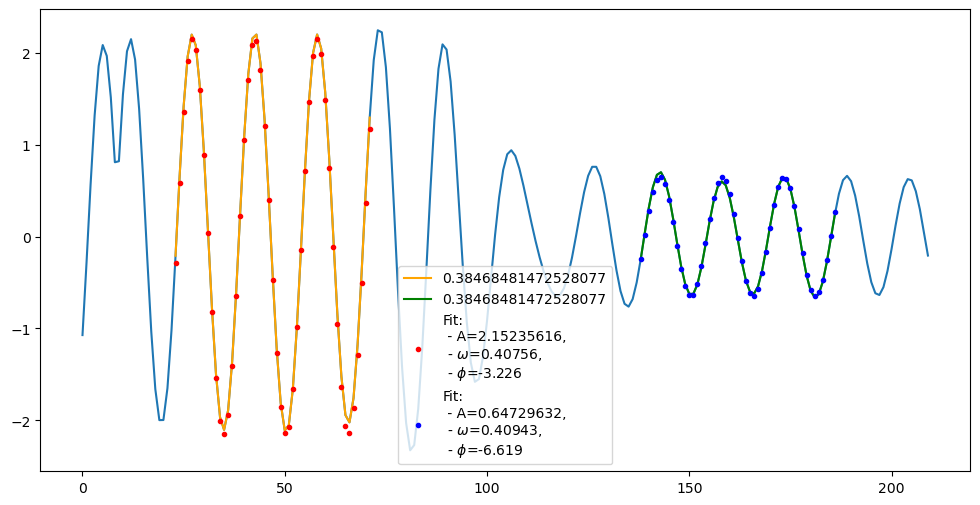

Plot


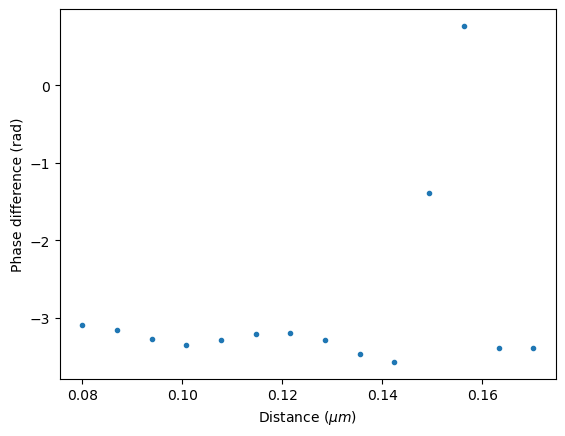

-----------
Initializing structure...
time for choose_chunkdivision = 0.000169039 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.108112 s
-----------


FloatProgress(value=0.0, description='0% done ', max=600.0)

Meep progress: 435.4375/600.0 = 72.6% done in 4.0s, 1.5s to go
on time step 13944 (time=435.75), 0.000286904 s/step
run 0 finished at t = 600.0 (19200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000169039 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     cylinder, center = (0,0.177143,0)
          radius 2.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
     cylinder, center = (0,0.177143,0)
          radius 2, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.125223 s
-----------


FloatProgress(value=0.0, description='0% done ', max=600.0)

Meep progress: 443.3125/600.0 = 73.9% done in 4.0s, 1.4s to go
on time step 14201 (time=443.781), 0.000281707 s/step
harminv0:, frequency, imag. freq., Q, |amp|, amplitude, error
harminv0:, 0.7036538009450001, -0.0011314322894545078, 310.95709725778175, 0.05340949435169586, -0.032663856429620046+0.04225691150627316i, 2.2350753142892413e-12+0.0i
run 0 finished at t = 600.0 (19200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000350952 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.160126 s
-----------


FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 143.625/1000.0 = 14.4% done in 4.0s, 23.9s to go
on time step 4603 (time=143.844), 0.000869106 s/step
Meep progress: 294.4375/1000.0 = 29.4% done in 8.0s, 19.2s to go
on time step 9430 (time=294.688), 0.000828827 s/step
Meep progress: 444.96875/1000.0 = 44.5% done in 12.0s, 15.0s to go
on time step 14248 (time=445.25), 0.000830377 s/step
Meep progress: 595.8125/1000.0 = 59.6% done in 16.0s, 10.9s to go
on time step 19079 (time=596.219), 0.000828138 s/step
Meep progress: 745.4375/1000.0 = 74.5% done in 20.0s, 6.8s to go
on time step 23867 (time=745.844), 0.000835577 s/step
Meep progress: 890.65625/1000.0 = 89.1% done in 24.0s, 2.9s to go
on time step 28518 (time=891.188), 0.000860064 s/step
run 0 finished at t = 1000.0 (32000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000175953 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     cylinder, center = (0,0.177143,0)
          radius 2.5, height 1e+20, a

FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 227.59375/1000.0 = 22.8% done in 4.0s, 13.6s to go
on time step 7289 (time=227.781), 0.000548801 s/step
Meep progress: 452.8125/1000.0 = 45.3% done in 8.0s, 9.7s to go
on time step 14496 (time=453), 0.000555028 s/step
Meep progress: 684.6875/1000.0 = 68.5% done in 12.0s, 5.5s to go
on time step 21917 (time=684.906), 0.000539061 s/step
Meep progress: 915.1875/1000.0 = 91.5% done in 16.0s, 1.5s to go
on time step 29295 (time=915.469), 0.00054216 s/step
run 0 finished at t = 1000.0 (32000 timesteps)


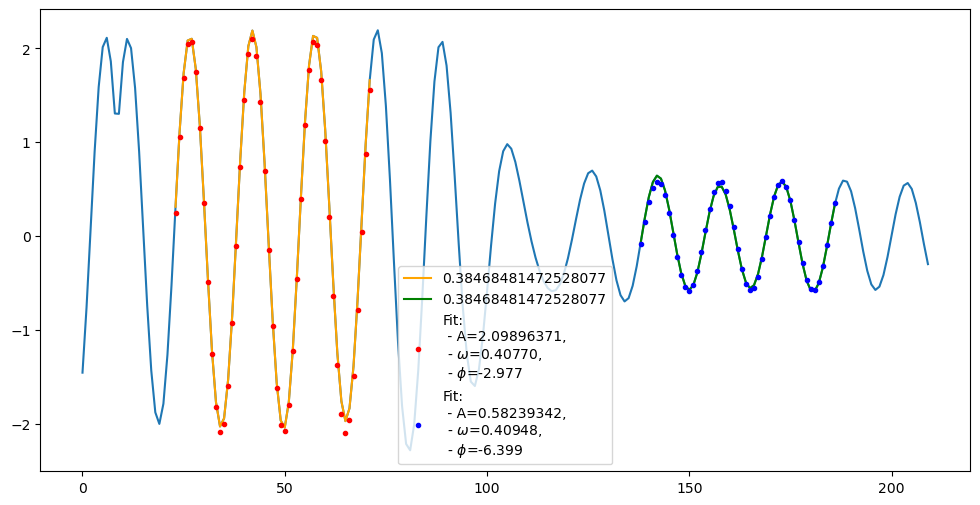

Plot


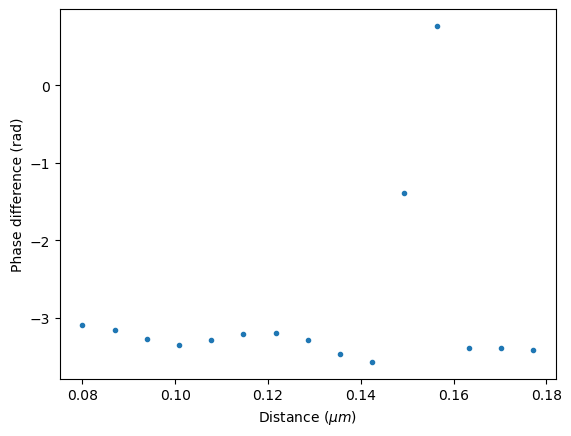

-----------
Initializing structure...
time for choose_chunkdivision = 0.000211954 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.096349 s
-----------


FloatProgress(value=0.0, description='0% done ', max=600.0)

Meep progress: 488.46875/600.0 = 81.4% done in 4.0s, 0.9s to go
on time step 15655 (time=489.219), 0.000255523 s/step
run 0 finished at t = 600.0 (19200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.0001688 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     cylinder, center = (0,0.184082,0)
          radius 2.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
     cylinder, center = (0,0.184082,0)
          radius 2, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.12495 s
-----------


FloatProgress(value=0.0, description='0% done ', max=600.0)

Meep progress: 445.21875/600.0 = 74.2% done in 4.0s, 1.4s to go
on time step 14254 (time=445.438), 0.000280648 s/step
harminv0:, frequency, imag. freq., Q, |amp|, amplitude, error
harminv0:, 0.703611821465359, -0.0010861124410141843, 323.9129738760492, 0.05352615917642427, -0.0336486950728311+0.04162709497521464i, 7.084861594527262e-12+0.0i
run 0 finished at t = 600.0 (19200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000375986 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.177536 s
-----------


FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 153.0625/1000.0 = 15.3% done in 4.0s, 22.1s to go
on time step 4904 (time=153.25), 0.00081581 s/step
Meep progress: 303.34375/1000.0 = 30.3% done in 8.0s, 18.4s to go
on time step 9714 (time=303.562), 0.00083173 s/step
Meep progress: 455.28125/1000.0 = 45.5% done in 12.0s, 14.4s to go
on time step 14580 (time=455.625), 0.000822126 s/step
Meep progress: 608.21875/1000.0 = 60.8% done in 16.0s, 10.3s to go
on time step 19473 (time=608.531), 0.000817573 s/step
Meep progress: 763.5625/1000.0 = 76.4% done in 20.0s, 6.2s to go
on time step 24448 (time=764), 0.000804198 s/step
Meep progress: 917.34375/1000.0 = 91.7% done in 24.0s, 2.2s to go
on time step 29370 (time=917.812), 0.00081275 s/step
run 0 finished at t = 1000.0 (32000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000201941 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     cylinder, center = (0,0.184082,0)
          radius 2.5, height 1e+20, axis 

FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 229.1875/1000.0 = 22.9% done in 4.0s, 13.5s to go
on time step 7341 (time=229.406), 0.000544899 s/step
Meep progress: 461.71875/1000.0 = 46.2% done in 8.0s, 9.3s to go
on time step 14787 (time=462.094), 0.00053731 s/step
Meep progress: 694.3125/1000.0 = 69.4% done in 12.0s, 5.3s to go
on time step 22230 (time=694.688), 0.000537511 s/step
Meep progress: 935.125/1000.0 = 93.5% done in 16.0s, 1.1s to go
on time step 29937 (time=935.531), 0.000519096 s/step
run 0 finished at t = 1000.0 (32000 timesteps)


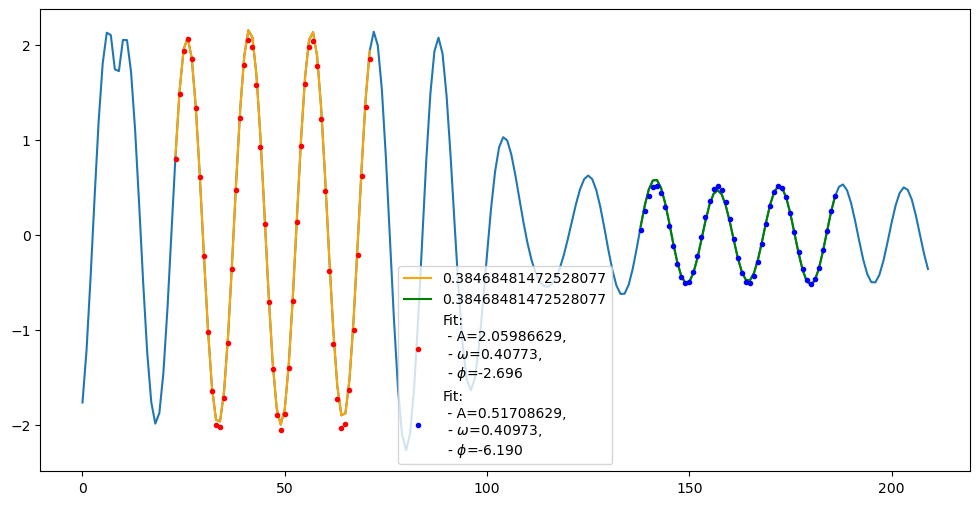

Plot


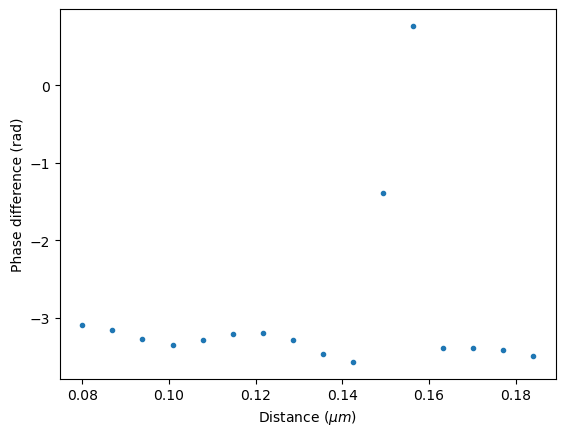

-----------
Initializing structure...
time for choose_chunkdivision = 0.000197887 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.0917249 s
-----------


FloatProgress(value=0.0, description='0% done ', max=600.0)

Meep progress: 483.1875/600.0 = 80.5% done in 4.0s, 1.0s to go
on time step 15480 (time=483.75), 0.000258421 s/step
run 0 finished at t = 600.0 (19200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000169039 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     cylinder, center = (0,0.19102,0)
          radius 2.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
     cylinder, center = (0,0.19102,0)
          radius 2, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.125358 s
-----------


FloatProgress(value=0.0, description='0% done ', max=600.0)

Meep progress: 451.34375/600.0 = 75.2% done in 4.0s, 1.3s to go
on time step 14468 (time=452.125), 0.000276481 s/step
harminv0:, frequency, imag. freq., Q, |amp|, amplitude, error
harminv0:, 0.7035647164041531, -0.0010440448109019984, 336.94181947818464, 0.053118514965125936, -0.034382933381984004+0.04048938779668517i, 1.2829570149801711e-12+0.0i
run 0 finished at t = 600.0 (19200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.12756 s
-----------


FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 228.65625/1000.0 = 22.9% done in 4.0s, 13.5s to go
on time step 7320 (time=228.75), 0.000546537 s/step
Meep progress: 457.3125/1000.0 = 45.7% done in 8.0s, 9.5s to go
on time step 14641 (time=457.531), 0.000546586 s/step
Meep progress: 691.09375/1000.0 = 69.1% done in 12.0s, 5.4s to go
on time step 22126 (time=691.438), 0.000534496 s/step
Meep progress: 924.3125/1000.0 = 92.4% done in 16.0s, 1.3s to go
on time step 29591 (time=924.719), 0.000535849 s/step
run 0 finished at t = 1000.0 (32000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00052309 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     cylinder, center = (0,0.19102,0)
          radius 2.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
     cylinder, center = (0,0.19102,0)
          radius 2, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, cente

FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 234.21875/1000.0 = 23.4% done in 4.0s, 13.1s to go
on time step 7502 (time=234.438), 0.000533235 s/step
Meep progress: 472.65625/1000.0 = 47.3% done in 8.0s, 8.9s to go
on time step 15133 (time=472.906), 0.000524181 s/step
Meep progress: 703.65625/1000.0 = 70.4% done in 12.0s, 5.1s to go
on time step 22526 (time=703.938), 0.00054114 s/step
Meep progress: 936.5625/1000.0 = 93.7% done in 16.0s, 1.1s to go
on time step 29985 (time=937.031), 0.000536329 s/step
run 0 finished at t = 1000.0 (32000 timesteps)


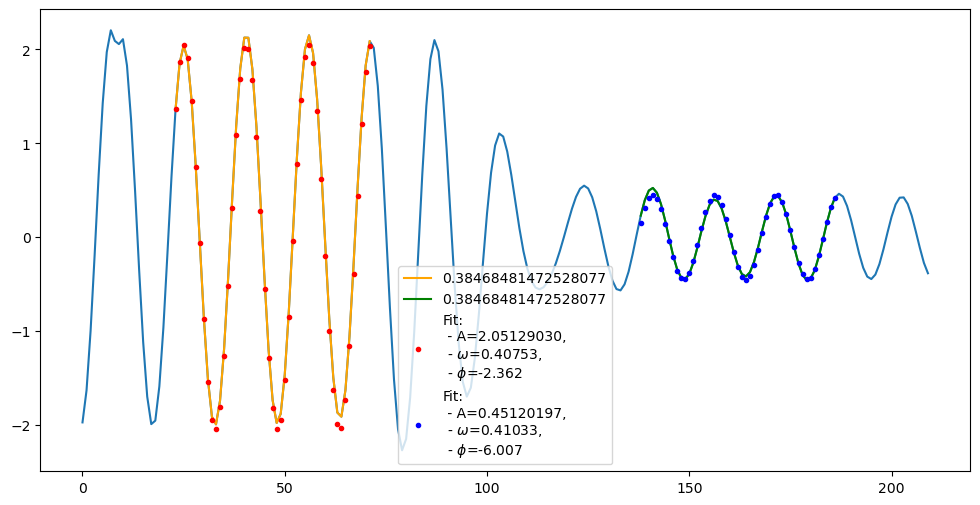

Plot


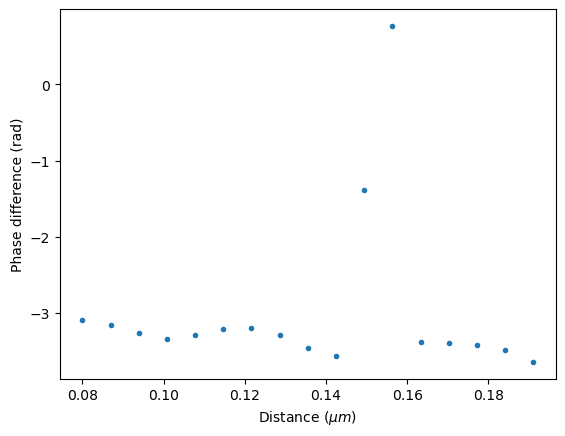

-----------
Initializing structure...
time for choose_chunkdivision = 0.000292063 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.0947411 s
-----------


FloatProgress(value=0.0, description='0% done ', max=600.0)

Meep progress: 493.1875/600.0 = 82.2% done in 4.0s, 0.9s to go
on time step 15800 (time=493.75), 0.000253181 s/step
run 0 finished at t = 600.0 (19200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000174046 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     cylinder, center = (0,0.197959,0)
          radius 2.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
     cylinder, center = (0,0.197959,0)
          radius 2, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.128915 s
-----------


FloatProgress(value=0.0, description='0% done ', max=600.0)

Meep progress: 475.46875/600.0 = 79.2% done in 4.0s, 1.0s to go
on time step 15225 (time=475.781), 0.000262742 s/step
harminv0:, frequency, imag. freq., Q, |amp|, amplitude, error
harminv0:, 0.7035129584592075, -0.0010048302836627913, 350.0655632584904, 0.052232625969738725, -0.03490272748968969+0.03885932101150358i, 3.729616884358054e-12+0.0i
run 0 finished at t = 600.0 (19200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00027895 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.135704 s
-----------


FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 231.46875/1000.0 = 23.1% done in 4.0s, 13.3s to go
on time step 7432 (time=232.25), 0.000538222 s/step
Meep progress: 444.75/1000.0 = 44.5% done in 8.0s, 10.0s to go
on time step 14252 (time=445.375), 0.000586644 s/step
Meep progress: 602.40625/1000.0 = 60.2% done in 12.0s, 7.9s to go
on time step 19297 (time=603.031), 0.000792932 s/step
Meep progress: 762.34375/1000.0 = 76.2% done in 16.0s, 5.0s to go
on time step 24415 (time=762.969), 0.000781696 s/step
Meep progress: 923.1875/1000.0 = 92.3% done in 20.0s, 1.7s to go
on time step 29568 (time=924), 0.00077634 s/step
run 0 finished at t = 1000.0 (32000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000375032 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     cylinder, center = (0,0.197959,0)
          radius 2.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
     cylinder, center = (0,0.197959,0)
      

FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 154.09375/1000.0 = 15.4% done in 4.0s, 22.0s to go
on time step 4937 (time=154.281), 0.000810338 s/step
Meep progress: 310.25/1000.0 = 31.0% done in 8.0s, 17.8s to go
on time step 9937 (time=310.531), 0.000800111 s/step
Meep progress: 467.375/1000.0 = 46.7% done in 12.0s, 13.7s to go
on time step 14967 (time=467.719), 0.000795321 s/step
Meep progress: 707.8125/1000.0 = 70.8% done in 16.0s, 6.6s to go
on time step 22668 (time=708.375), 0.00051946 s/step
Meep progress: 957.25/1000.0 = 95.7% done in 20.0s, 0.9s to go
on time step 30656 (time=958), 0.00050089 s/step
run 0 finished at t = 1000.0 (32000 timesteps)


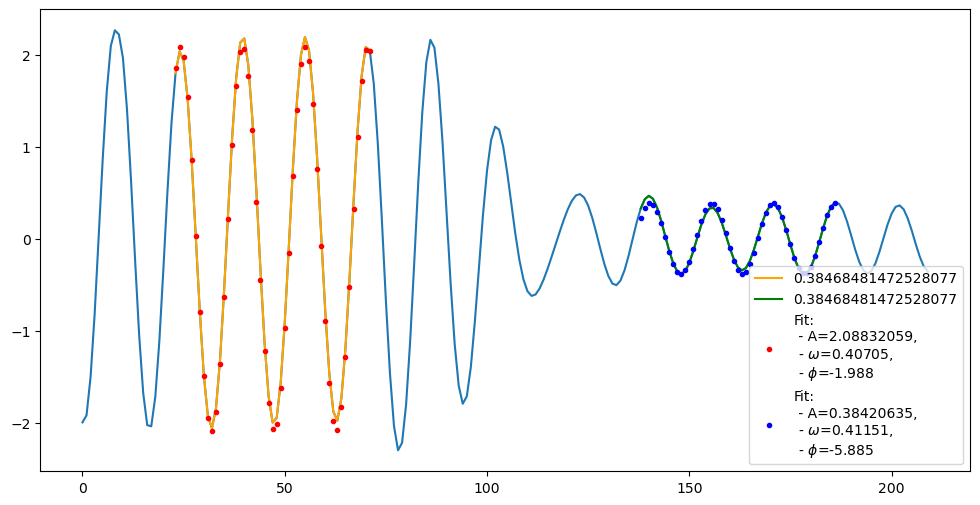

Plot


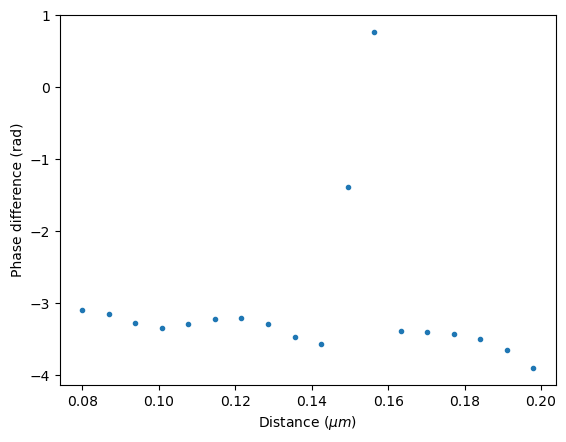

-----------
Initializing structure...
time for choose_chunkdivision = 0.000265121 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.0721519 s
-----------


FloatProgress(value=0.0, description='0% done ', max=600.0)

Meep progress: 508.59375/600.0 = 84.8% done in 4.0s, 0.7s to go
on time step 16290 (time=509.062), 0.000245551 s/step
run 0 finished at t = 600.0 (19200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000169039 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     cylinder, center = (0,0.204898,0)
          radius 2.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
     cylinder, center = (0,0.204898,0)
          radius 2, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.123933 s
-----------


FloatProgress(value=0.0, description='0% done ', max=600.0)

Meep progress: 480.90625/600.0 = 80.2% done in 4.0s, 1.0s to go
on time step 15401 (time=481.281), 0.00025973 s/step
harminv0:, frequency, imag. freq., Q, |amp|, amplitude, error
harminv0:, 0.7034610665353781, -0.0009676759033041608, 363.479685777742, 0.05141020449187075, -0.035449819607256995+0.03723331056606308i, 5.44857071174832e-12+0.0i
run 0 finished at t = 600.0 (19200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.165796 s
-----------


FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 204.84375/1000.0 = 20.5% done in 4.0s, 15.5s to go
on time step 6568 (time=205.25), 0.000609034 s/step
Meep progress: 411.40625/1000.0 = 41.1% done in 8.0s, 11.4s to go
on time step 13180 (time=411.875), 0.000605056 s/step
Meep progress: 623.15625/1000.0 = 62.3% done in 12.0s, 7.3s to go
on time step 19957 (time=623.656), 0.000590297 s/step
Meep progress: 830.6875/1000.0 = 83.1% done in 16.0s, 3.3s to go
on time step 26598 (time=831.188), 0.000602346 s/step
run 0 finished at t = 1000.0 (32000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000181198 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     cylinder, center = (0,0.204898,0)
          radius 2.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
     cylinder, center = (0,0.204898,0)
          radius 2, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, 

FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 187.53125/1000.0 = 18.8% done in 4.0s, 17.3s to go
on time step 6008 (time=187.75), 0.000665795 s/step
Meep progress: 364.0/1000.0 = 36.4% done in 8.0s, 14.0s to go
on time step 11657 (time=364.281), 0.000708164 s/step
Meep progress: 552.96875/1000.0 = 55.3% done in 12.0s, 9.7s to go
on time step 17705 (time=553.281), 0.000661413 s/step
Meep progress: 735.78125/1000.0 = 73.6% done in 16.0s, 5.7s to go
on time step 23554 (time=736.062), 0.000683884 s/step
Meep progress: 938.21875/1000.0 = 93.8% done in 20.0s, 1.3s to go
on time step 30035 (time=938.594), 0.000617206 s/step
run 0 finished at t = 1000.0 (32000 timesteps)


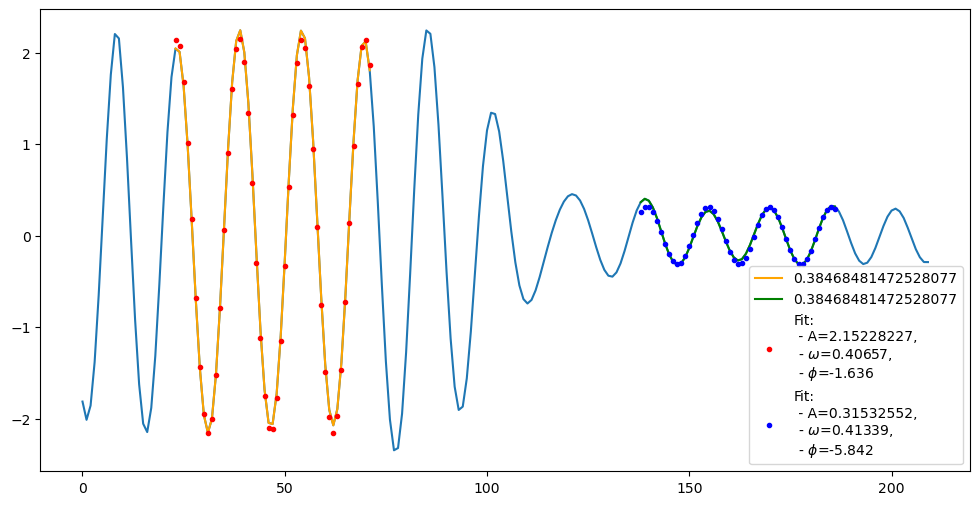

Plot


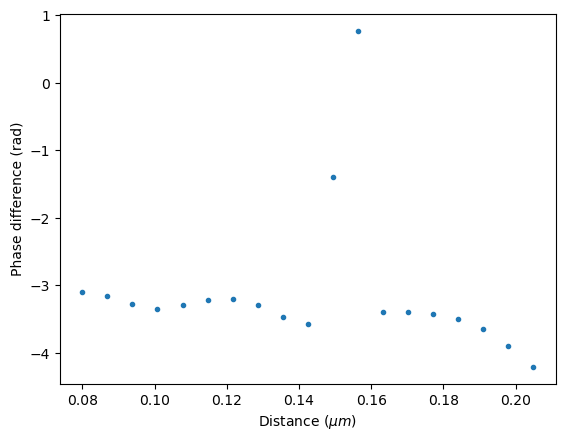

-----------
Initializing structure...
time for choose_chunkdivision = 0.000187159 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.134769 s
-----------


FloatProgress(value=0.0, description='0% done ', max=600.0)

Meep progress: 368.34375/600.0 = 61.4% done in 4.0s, 2.5s to go
on time step 11805 (time=368.906), 0.000338847 s/step
run 0 finished at t = 600.0 (19200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000180006 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     cylinder, center = (0,0.211837,0)
          radius 2.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
     cylinder, center = (0,0.211837,0)
          radius 2, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.144786 s
-----------


FloatProgress(value=0.0, description='0% done ', max=600.0)

Meep progress: 299.28125/600.0 = 49.9% done in 4.0s, 4.0s to go
on time step 9590 (time=299.688), 0.000417138 s/step
harminv0:, frequency, imag. freq., Q, |amp|, amplitude, error
harminv0:, 0.7034171877202864, -0.0009316638166305319, 377.5059067251719, 0.05064783905730695, -0.035863031689493195+0.03576376041768083i, 2.3807136897433228e-11+0.0i
run 0 finished at t = 600.0 (19200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000259161 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.146886 s
-----------


FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 179.375/1000.0 = 17.9% done in 4.0s, 18.3s to go
on time step 5747 (time=179.594), 0.000696026 s/step
Meep progress: 357.125/1000.0 = 35.7% done in 8.0s, 14.4s to go
on time step 11437 (time=357.406), 0.000703058 s/step
Meep progress: 527.15625/1000.0 = 52.7% done in 12.0s, 10.8s to go
on time step 16880 (time=527.5), 0.00073494 s/step
Meep progress: 721.84375/1000.0 = 72.2% done in 16.0s, 6.2s to go
on time step 23110 (time=722.188), 0.00064208 s/step
Meep progress: 901.96875/1000.0 = 90.2% done in 20.0s, 2.2s to go
on time step 28879 (time=902.469), 0.000693437 s/step
run 0 finished at t = 1000.0 (32000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000192881 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     cylinder, center = (0,0.211837,0)
          radius 2.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
     cylinder, center = (0,0.211837,0)
   

FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 170.0625/1000.0 = 17.0% done in 4.0s, 19.5s to go
on time step 5451 (time=170.344), 0.000733868 s/step
Meep progress: 344.4375/1000.0 = 34.4% done in 8.0s, 15.2s to go
on time step 11034 (time=344.812), 0.000716532 s/step
Meep progress: 518.3125/1000.0 = 51.8% done in 12.0s, 11.2s to go
on time step 16602 (time=518.812), 0.000718464 s/step
Meep progress: 701.03125/1000.0 = 70.1% done in 16.0s, 6.8s to go
on time step 22444 (time=701.375), 0.000684727 s/step
Meep progress: 890.0625/1000.0 = 89.0% done in 20.0s, 2.5s to go
on time step 28502 (time=890.688), 0.000660327 s/step
run 0 finished at t = 1000.0 (32000 timesteps)


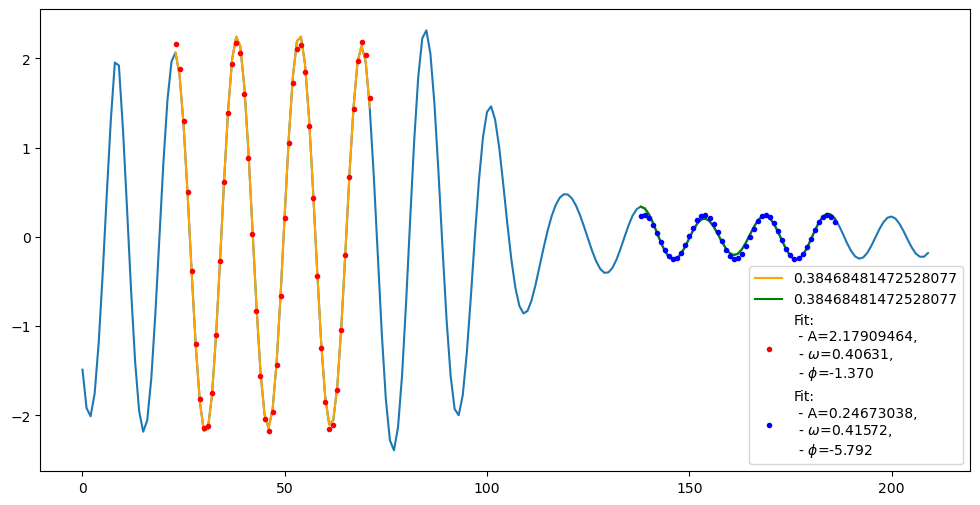

Plot


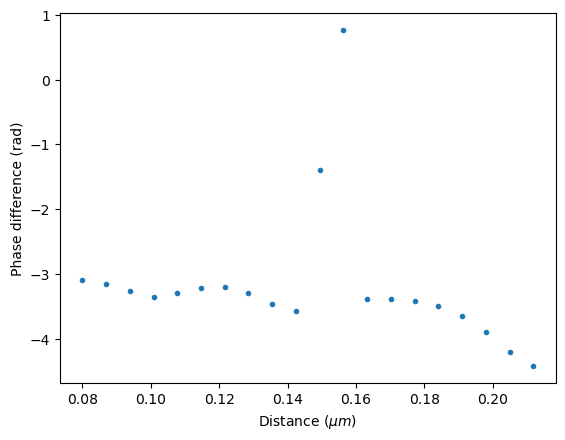

-----------
Initializing structure...
time for choose_chunkdivision = 0.000210047 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.142667 s
-----------


FloatProgress(value=0.0, description='0% done ', max=600.0)

Meep progress: 360.125/600.0 = 60.0% done in 4.0s, 2.7s to go
on time step 11550 (time=360.938), 0.00034633 s/step
run 0 finished at t = 600.0 (19200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000200987 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     cylinder, center = (0,0.218776,0)
          radius 2.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
     cylinder, center = (0,0.218776,0)
          radius 2, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.149962 s
-----------


FloatProgress(value=0.0, description='0% done ', max=600.0)

Meep progress: 406.75/600.0 = 67.8% done in 4.0s, 1.9s to go
on time step 13037 (time=407.406), 0.000306825 s/step
harminv0:, frequency, imag. freq., Q, |amp|, amplitude, error
harminv0:, 0.7033829250303454, -0.0008968740309960026, 392.13027734185806, 0.049918473023111434, -0.03607919871170302+0.034498483579435066i, 6.833445814540015e-11+0.0i
run 0 finished at t = 600.0 (19200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.139431 s
-----------


FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 234.9375/1000.0 = 23.5% done in 4.0s, 13.0s to go
on time step 7523 (time=235.094), 0.000531704 s/step
Meep progress: 441.625/1000.0 = 44.2% done in 8.0s, 10.1s to go
on time step 14138 (time=441.812), 0.000604732 s/step
Meep progress: 659.40625/1000.0 = 65.9% done in 12.0s, 6.2s to go
on time step 21109 (time=659.656), 0.000573878 s/step
Meep progress: 870.09375/1000.0 = 87.0% done in 16.0s, 2.4s to go
on time step 27852 (time=870.375), 0.000593254 s/step
run 0 finished at t = 1000.0 (32000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000168085 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     cylinder, center = (0,0.218776,0)
          radius 2.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
     cylinder, center = (0,0.218776,0)
          radius 2, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, c

FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 209.21875/1000.0 = 20.9% done in 4.0s, 15.1s to go
on time step 6709 (time=209.656), 0.000596268 s/step
Meep progress: 439.90625/1000.0 = 44.0% done in 8.0s, 10.2s to go
on time step 14094 (time=440.438), 0.000541683 s/step
Meep progress: 644.84375/1000.0 = 64.5% done in 12.0s, 6.6s to go
on time step 20654 (time=645.438), 0.000609798 s/step
Meep progress: 885.5625/1000.0 = 88.6% done in 16.0s, 2.1s to go
on time step 28360 (time=886.25), 0.000519131 s/step
run 0 finished at t = 1000.0 (32000 timesteps)


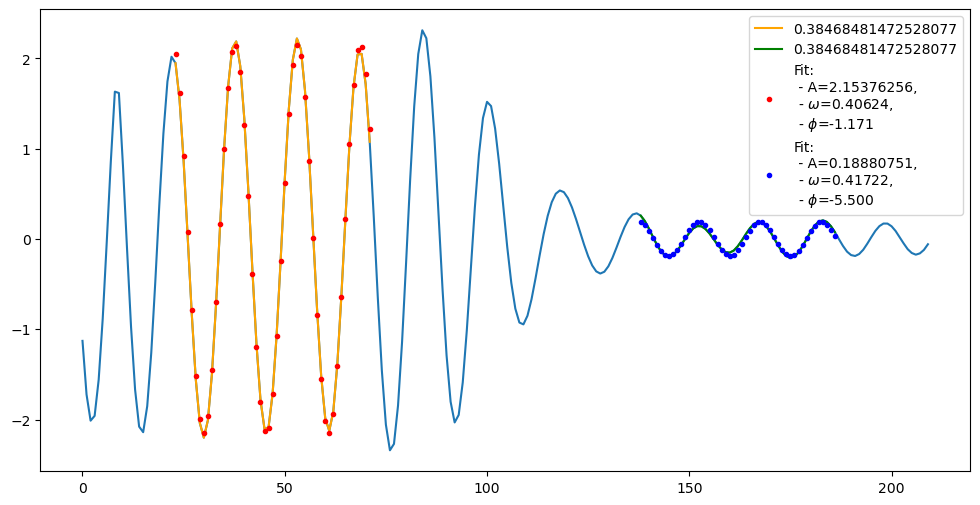

Plot


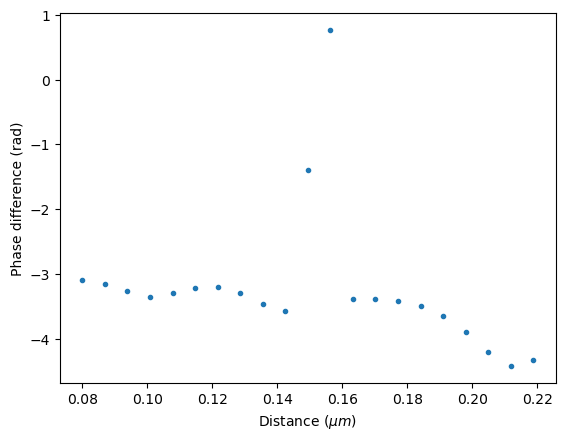

-----------
Initializing structure...
time for choose_chunkdivision = 0.000191212 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.10065 s
-----------


FloatProgress(value=0.0, description='0% done ', max=600.0)

Meep progress: 513.09375/600.0 = 85.5% done in 4.0s, 0.7s to go
on time step 16436 (time=513.625), 0.000243382 s/step
run 0 finished at t = 600.0 (19200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000179052 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     cylinder, center = (0,0.225714,0)
          radius 2.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
     cylinder, center = (0,0.225714,0)
          radius 2, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.122584 s
-----------


FloatProgress(value=0.0, description='0% done ', max=600.0)

Meep progress: 497.1875/600.0 = 82.9% done in 4.0s, 0.8s to go
on time step 15928 (time=497.75), 0.000251186 s/step
harminv0:, frequency, imag. freq., Q, |amp|, amplitude, error
harminv0:, 0.7033479894132811, -0.0008660963562263015, 406.0448842423625, 0.04920536388996543, -0.036286166169741396+0.03323374761061155i, 1.8553382640663014e-11+0.0i
run 0 finished at t = 600.0 (19200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000249863 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.14474 s
-----------


FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 141.4375/1000.0 = 14.1% done in 4.0s, 24.3s to go
on time step 4537 (time=141.781), 0.00088168 s/step
Meep progress: 288.65625/1000.0 = 28.9% done in 8.0s, 19.7s to go
on time step 9252 (time=289.125), 0.000848543 s/step
Meep progress: 449.09375/1000.0 = 44.9% done in 12.0s, 14.7s to go
on time step 14384 (time=449.5), 0.000779474 s/step
Meep progress: 611.625/1000.0 = 61.2% done in 16.0s, 10.2s to go
on time step 19589 (time=612.156), 0.000768583 s/step
Meep progress: 777.375/1000.0 = 77.7% done in 20.0s, 5.7s to go
on time step 24897 (time=778.031), 0.000753671 s/step
Meep progress: 942.09375/1000.0 = 94.2% done in 24.0s, 1.5s to go
on time step 30168 (time=942.75), 0.000759046 s/step
run 0 finished at t = 1000.0 (32000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000320911 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     cylinder, center = (0,0.225714,0)
          radius 2.5, height 1e+20, axis

FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 160.3125/1000.0 = 16.0% done in 4.0s, 21.0s to go
on time step 5138 (time=160.562), 0.000778577 s/step
Meep progress: 320.59375/1000.0 = 32.1% done in 8.0s, 17.0s to go
on time step 10268 (time=320.875), 0.000779821 s/step
Meep progress: 503.21875/1000.0 = 50.3% done in 12.0s, 11.8s to go
on time step 16121 (time=503.781), 0.000683489 s/step
Meep progress: 760.4375/1000.0 = 76.0% done in 16.0s, 5.0s to go
on time step 24354 (time=761.062), 0.000485852 s/step
run 0 finished at t = 1000.0 (32000 timesteps)


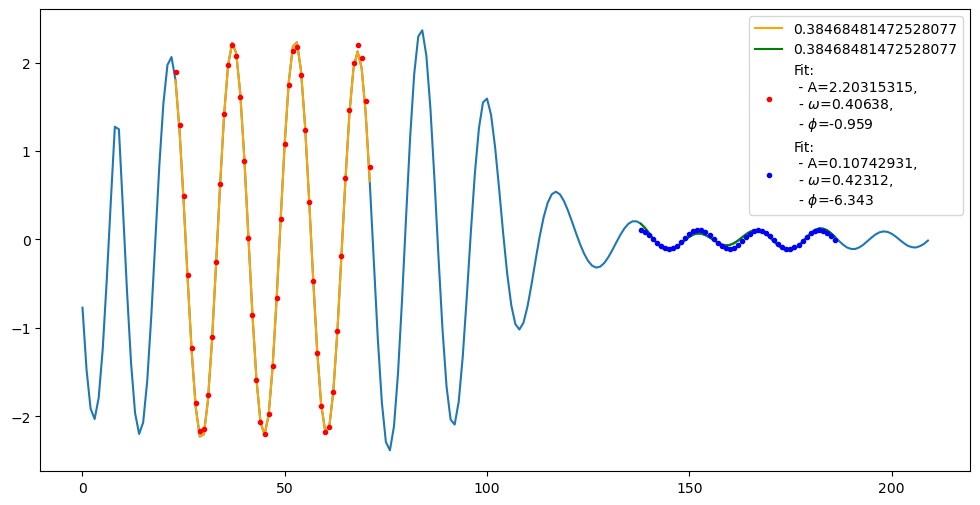

up shift in phase
Plot


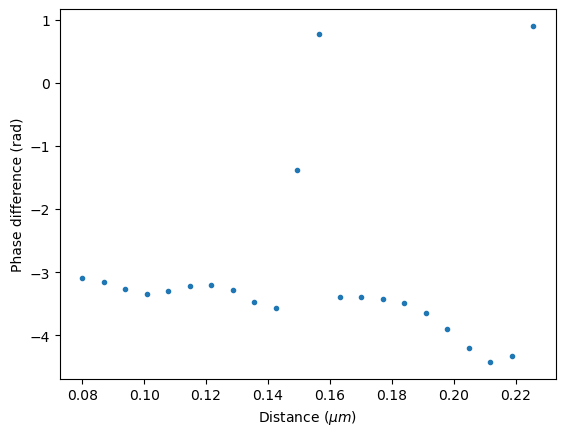

-----------
Initializing structure...
time for choose_chunkdivision = 0.000157118 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.102199 s
-----------


FloatProgress(value=0.0, description='0% done ', max=600.0)

Meep progress: 418.75/600.0 = 69.8% done in 4.0s, 1.7s to go
on time step 13425 (time=419.531), 0.000297979 s/step
run 0 finished at t = 600.0 (19200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000170946 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     cylinder, center = (0,0.232653,0)
          radius 2.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
     cylinder, center = (0,0.232653,0)
          radius 2, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.117573 s
-----------


FloatProgress(value=0.0, description='0% done ', max=600.0)

Meep progress: 491.53125/600.0 = 81.9% done in 4.0s, 0.9s to go
on time step 15744 (time=492), 0.000254066 s/step
harminv0:, frequency, imag. freq., Q, |amp|, amplitude, error
harminv0:, 0.7033205469348496, -0.0008372296016538783, 420.0284757881814, 0.04856651650769171, -0.0363704123775648+0.032185394656237674i, 5.946564065866963e-12+0.0i
run 0 finished at t = 600.0 (19200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000242949 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.127261 s
-----------


FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 244.625/1000.0 = 24.5% done in 4.0s, 12.4s to go
on time step 7838 (time=244.938), 0.000510363 s/step
Meep progress: 497.4375/1000.0 = 49.7% done in 8.0s, 8.1s to go
on time step 15930 (time=497.812), 0.00049436 s/step
Meep progress: 747.4375/1000.0 = 74.7% done in 12.0s, 4.1s to go
on time step 23931 (time=747.844), 0.000499963 s/step
Meep progress: 990.5625/1000.0 = 99.1% done in 16.0s, 0.2s to go
on time step 31711 (time=990.969), 0.000514153 s/step
run 0 finished at t = 1000.0 (32000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000188828 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     cylinder, center = (0,0.232653,0)
          radius 2.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
     cylinder, center = (0,0.232653,0)
          radius 2, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, cente

FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 230.03125/1000.0 = 23.0% done in 4.0s, 13.4s to go
on time step 7375 (time=230.469), 0.000542452 s/step
Meep progress: 480.65625/1000.0 = 48.1% done in 8.0s, 8.6s to go
on time step 15397 (time=481.156), 0.000498685 s/step
Meep progress: 735.75/1000.0 = 73.6% done in 12.0s, 4.3s to go
on time step 23565 (time=736.406), 0.000489758 s/step
Meep progress: 941.21875/1000.0 = 94.1% done in 16.0s, 1.0s to go
on time step 30133 (time=941.656), 0.000609046 s/step
run 0 finished at t = 1000.0 (32000 timesteps)


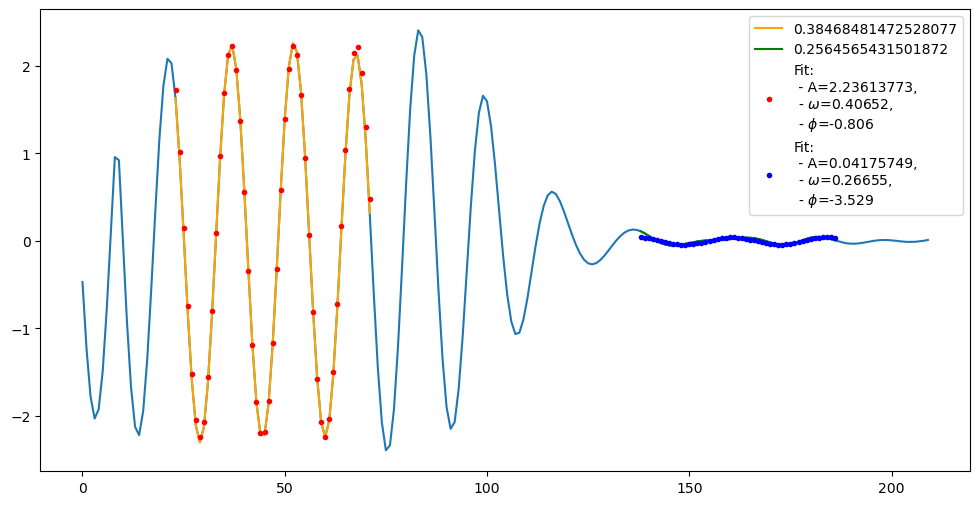

Plot


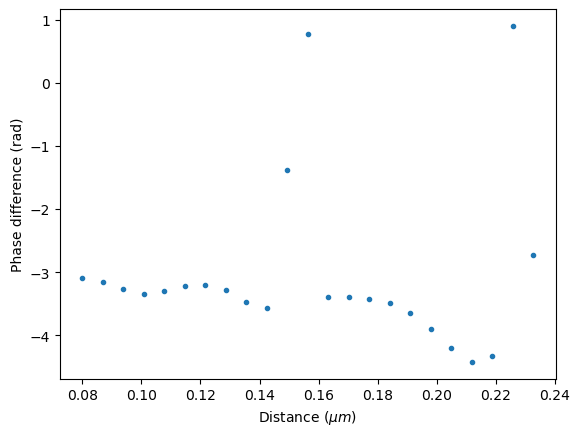

-----------
Initializing structure...
time for choose_chunkdivision = 0.000236034 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.127787 s
-----------


FloatProgress(value=0.0, description='0% done ', max=600.0)

Meep progress: 353.0625/600.0 = 58.8% done in 4.0s, 2.8s to go
on time step 11314 (time=353.562), 0.000353549 s/step
run 0 finished at t = 600.0 (19200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000218868 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     cylinder, center = (0,0.239592,0)
          radius 2.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
     cylinder, center = (0,0.239592,0)
          radius 2, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.167046 s
-----------


FloatProgress(value=0.0, description='0% done ', max=600.0)

Meep progress: 357.09375/600.0 = 59.5% done in 4.0s, 2.7s to go
on time step 11439 (time=357.469), 0.000349681 s/step
harminv0:, frequency, imag. freq., Q, |amp|, amplitude, error
harminv0:, 0.7032984491202185, -0.0008100528756921974, 434.1065072568527, 0.047995905137623855, -0.036362533472981115+0.03132687455534171i, 3.4659654768348678e-12+0.0i
run 0 finished at t = 600.0 (19200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.137188 s
-----------


FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 175.90625/1000.0 = 17.6% done in 4.0s, 18.7s to go
on time step 5636 (time=176.125), 0.000709818 s/step
Meep progress: 350.40625/1000.0 = 35.0% done in 8.0s, 14.8s to go
on time step 11221 (time=350.656), 0.000716305 s/step
Meep progress: 521.46875/1000.0 = 52.1% done in 12.0s, 11.0s to go
on time step 16697 (time=521.781), 0.000730474 s/step
Meep progress: 701.125/1000.0 = 70.1% done in 16.0s, 6.8s to go
on time step 22451 (time=701.594), 0.000695248 s/step
Meep progress: 927.21875/1000.0 = 92.7% done in 20.0s, 1.6s to go
on time step 29688 (time=927.75), 0.000552795 s/step
run 0 finished at t = 1000.0 (32000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00022006 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     cylinder, center = (0,0.239592,0)
          radius 2.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
     cylinder, center = (0,0.239592,0)

FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 243.0625/1000.0 = 24.3% done in 4.0s, 12.5s to go
on time step 7790 (time=243.438), 0.000513485 s/step
Meep progress: 461.375/1000.0 = 46.1% done in 8.0s, 9.3s to go
on time step 14772 (time=461.625), 0.000573024 s/step
Meep progress: 700.875/1000.0 = 70.1% done in 12.0s, 5.1s to go
on time step 22443 (time=701.344), 0.000521519 s/step
Meep progress: 951.5/1000.0 = 95.2% done in 16.0s, 0.8s to go
on time step 30463 (time=951.969), 0.000498779 s/step
run 0 finished at t = 1000.0 (32000 timesteps)


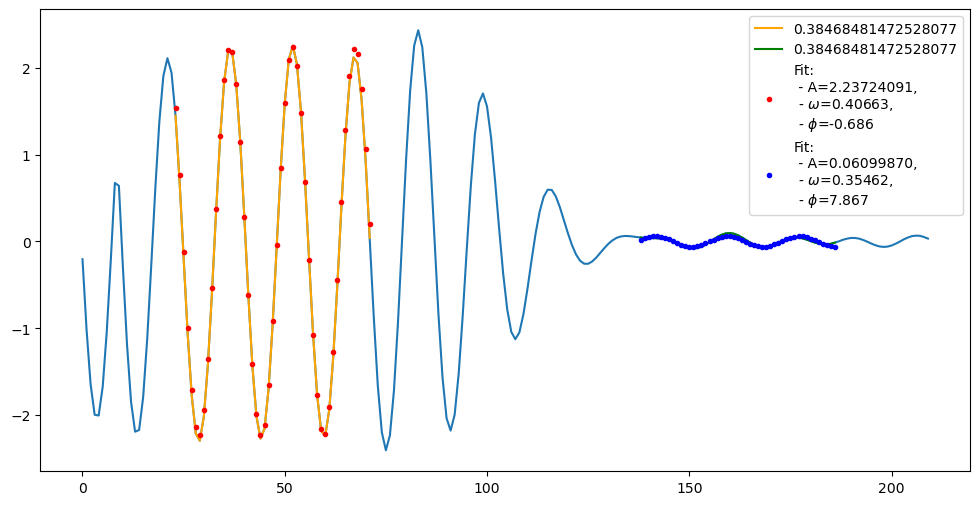

down shift in phase
down shift in phase
Plot


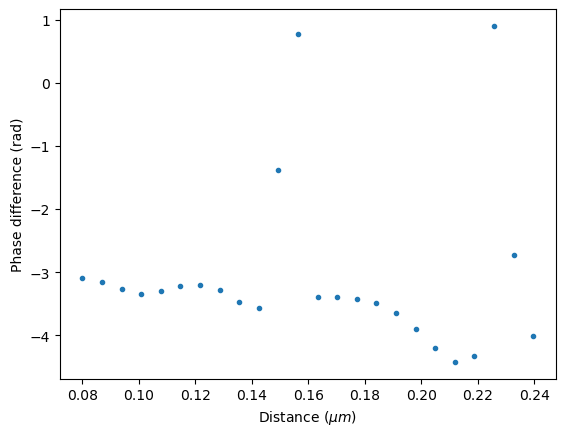

-----------
Initializing structure...
time for choose_chunkdivision = 0.000159979 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.102266 s
-----------


FloatProgress(value=0.0, description='0% done ', max=600.0)

Meep progress: 501.375/600.0 = 83.6% done in 4.0s, 0.8s to go
on time step 16065 (time=502.031), 0.000249037 s/step
run 0 finished at t = 600.0 (19200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000207186 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     cylinder, center = (0,0.246531,0)
          radius 2.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
     cylinder, center = (0,0.246531,0)
          radius 2, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.119669 s
-----------


FloatProgress(value=0.0, description='0% done ', max=600.0)

Meep progress: 488.375/600.0 = 81.4% done in 4.0s, 0.9s to go
on time step 15644 (time=488.875), 0.000255695 s/step
harminv0:, frequency, imag. freq., Q, |amp|, amplitude, error
harminv0:, 0.7032740170832947, -0.000784695680336938, 448.11895535178564, 0.04748797311360475, -0.03640268987137442-0.030495110437035355i, 3.1878631729731404e-12+0.0i
run 0 finished at t = 600.0 (19200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000244856 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.126322 s
-----------


FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 229.6875/1000.0 = 23.0% done in 4.0s, 13.4s to go
on time step 7354 (time=229.812), 0.000543981 s/step
Meep progress: 386.03125/1000.0 = 38.6% done in 8.0s, 12.7s to go
on time step 12360 (time=386.25), 0.000799163 s/step
Meep progress: 548.40625/1000.0 = 54.8% done in 12.0s, 9.9s to go
on time step 17557 (time=548.656), 0.000769868 s/step
Meep progress: 704.84375/1000.0 = 70.5% done in 16.0s, 6.7s to go
on time step 22565 (time=705.156), 0.000798844 s/step
Meep progress: 866.59375/1000.0 = 86.7% done in 20.0s, 3.1s to go
on time step 27744 (time=867), 0.00077251 s/step
run 0 finished at t = 1000.0 (32000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000313997 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     cylinder, center = (0,0.246531,0)
          radius 2.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
     cylinder, center = (0,0.246531,0)
   

FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 144.71875/1000.0 = 14.5% done in 4.0s, 23.6s to go
on time step 4638 (time=144.938), 0.000862701 s/step
Meep progress: 304.875/1000.0 = 30.5% done in 8.0s, 18.2s to go
on time step 9765 (time=305.156), 0.000780336 s/step
Meep progress: 464.375/1000.0 = 46.4% done in 12.0s, 13.8s to go
on time step 14871 (time=464.719), 0.000783481 s/step
Meep progress: 616.28125/1000.0 = 61.6% done in 16.0s, 10.0s to go
on time step 19732 (time=616.625), 0.000822883 s/step
Meep progress: 777.46875/1000.0 = 77.7% done in 20.0s, 5.7s to go
on time step 24892 (time=777.875), 0.000775268 s/step
Meep progress: 937.6875/1000.0 = 93.8% done in 24.0s, 1.6s to go
on time step 30017 (time=938.031), 0.0007806 s/step
run 0 finished at t = 1000.0 (32000 timesteps)


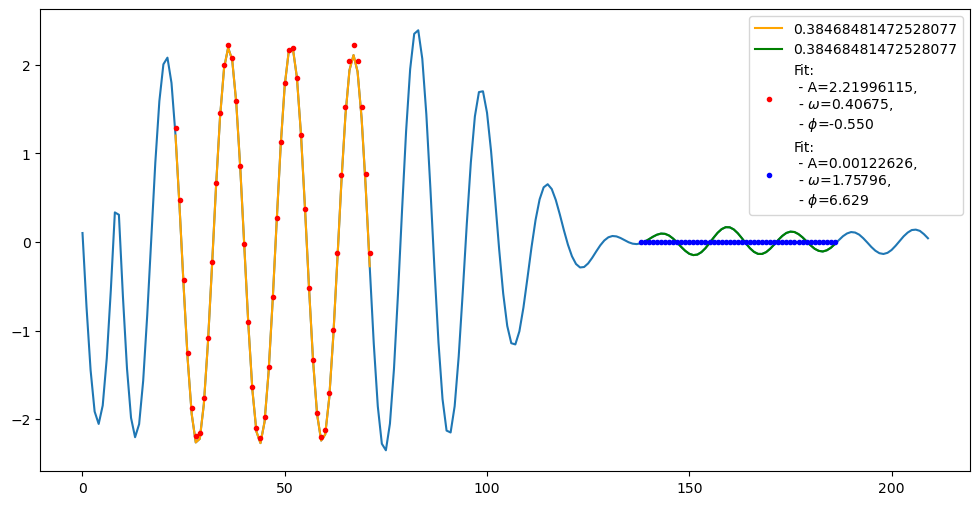

down shift in phase
Plot


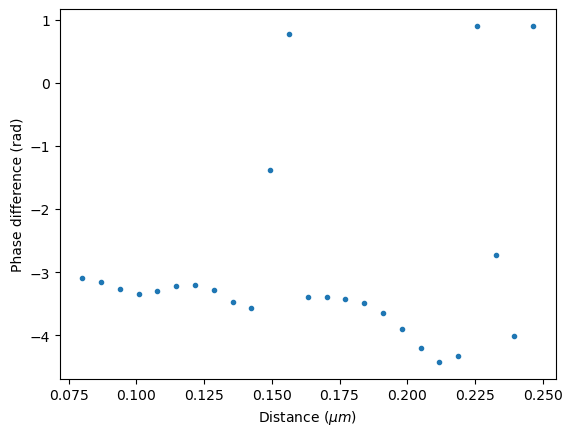

-----------
Initializing structure...
time for choose_chunkdivision = 0.000185013 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.0772328 s
-----------


FloatProgress(value=0.0, description='0% done ', max=600.0)

Meep progress: 505.96875/600.0 = 84.3% done in 4.0s, 0.7s to go
on time step 16212 (time=506.625), 0.000246736 s/step
run 0 finished at t = 600.0 (19200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000169039 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     cylinder, center = (0,0.253469,0)
          radius 2.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
     cylinder, center = (0,0.253469,0)
          radius 2, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.128544 s
-----------


FloatProgress(value=0.0, description='0% done ', max=600.0)

Meep progress: 503.375/600.0 = 83.9% done in 4.0s, 0.8s to go
on time step 16119 (time=503.719), 0.000248158 s/step
harminv0:, frequency, imag. freq., Q, |amp|, amplitude, error
harminv0:, 0.7032434160635737, -0.0007610865427084924, 461.99963906925, 0.04656802649495606, -0.036192494484621404+0.0293033178090055i, 3.677919571417075e-12+0.0i
run 0 finished at t = 600.0 (19200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00019598 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.124099 s
-----------


FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 227.375/1000.0 = 22.7% done in 4.0s, 13.6s to go
on time step 7286 (time=227.688), 0.000549001 s/step
Meep progress: 472.78125/1000.0 = 47.3% done in 8.0s, 8.9s to go
on time step 15142 (time=473.188), 0.000509214 s/step
Meep progress: 715.59375/1000.0 = 71.6% done in 12.0s, 4.8s to go
on time step 22913 (time=716.031), 0.000514802 s/step
Meep progress: 954.78125/1000.0 = 95.5% done in 16.0s, 0.8s to go
on time step 30564 (time=955.125), 0.000522861 s/step
run 0 finished at t = 1000.0 (32000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00019002 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     cylinder, center = (0,0.253469,0)
          radius 2.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
     cylinder, center = (0,0.253469,0)
          radius 2, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, ce

FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 245.21875/1000.0 = 24.5% done in 4.0s, 12.3s to go
on time step 7859 (time=245.594), 0.000508972 s/step
Meep progress: 488.25/1000.0 = 48.8% done in 8.0s, 8.4s to go
on time step 15635 (time=488.594), 0.000514504 s/step
Meep progress: 726.4375/1000.0 = 72.6% done in 12.0s, 4.5s to go
on time step 23260 (time=726.875), 0.000524626 s/step
Meep progress: 980.15625/1000.0 = 98.0% done in 16.0s, 0.3s to go
on time step 31384 (time=980.75), 0.000492405 s/step
run 0 finished at t = 1000.0 (32000 timesteps)


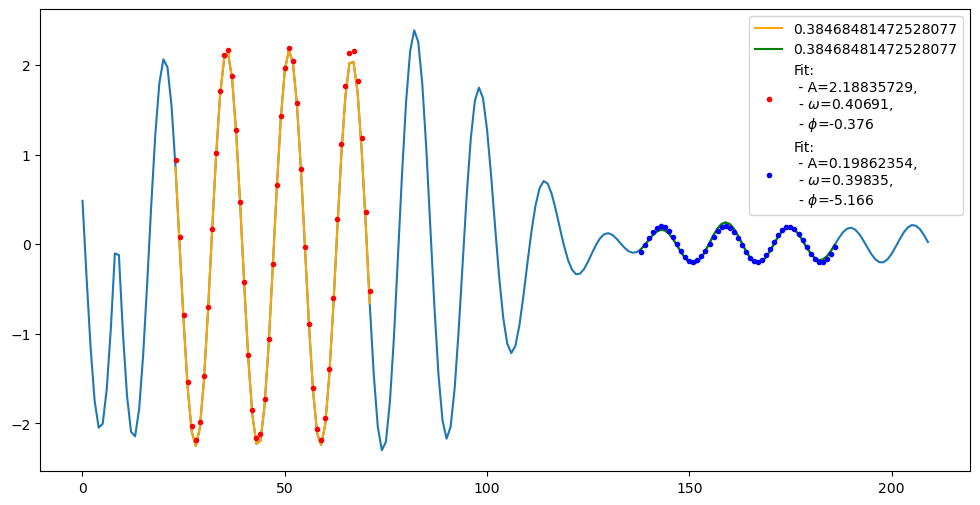

up shift in phase
Plot


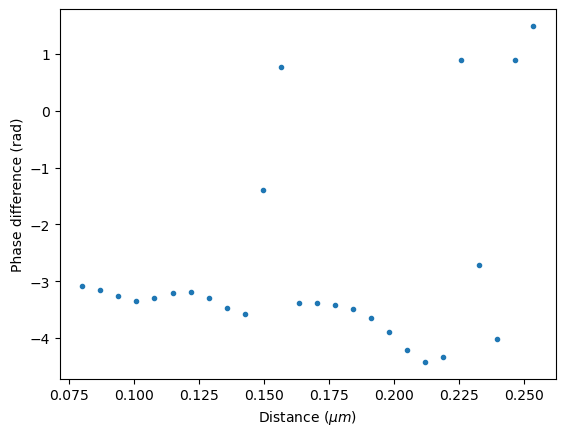

-----------
Initializing structure...
time for choose_chunkdivision = 0.000216007 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.121443 s
-----------


FloatProgress(value=0.0, description='0% done ', max=600.0)

Meep progress: 420.40625/600.0 = 70.1% done in 4.0s, 1.7s to go
on time step 13475 (time=421.094), 0.000296868 s/step
run 0 finished at t = 600.0 (19200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000170946 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     cylinder, center = (0,0.260408,0)
          radius 2.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
     cylinder, center = (0,0.260408,0)
          radius 2, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.121411 s
-----------


FloatProgress(value=0.0, description='0% done ', max=600.0)

Meep progress: 430.25/600.0 = 71.7% done in 4.0s, 1.6s to go
on time step 13788 (time=430.875), 0.000290111 s/step
harminv0:, frequency, imag. freq., Q, |amp|, amplitude, error
harminv0:, 0.7032070487270365, -0.0007389975630594845, 475.7844165383486, 0.04527632036802256, -0.03577259909070481+0.027753672556321624i, 4.650226624808741e-12+0.0i
run 0 finished at t = 600.0 (19200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000359058 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.166305 s
-----------


FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 143.5/1000.0 = 14.3% done in 4.0s, 23.9s to go
on time step 4599 (time=143.719), 0.000869978 s/step
Meep progress: 291.875/1000.0 = 29.2% done in 8.0s, 19.4s to go
on time step 9347 (time=292.094), 0.000842603 s/step
Meep progress: 436.65625/1000.0 = 43.7% done in 12.0s, 15.5s to go
on time step 13978 (time=436.812), 0.000863784 s/step
Meep progress: 588.125/1000.0 = 58.8% done in 16.0s, 11.2s to go
on time step 18831 (time=588.469), 0.000824295 s/step
Meep progress: 728.1875/1000.0 = 72.8% done in 20.0s, 7.5s to go
on time step 23314 (time=728.562), 0.000892312 s/step
Meep progress: 866.5/1000.0 = 86.7% done in 24.0s, 3.7s to go
on time step 27737 (time=866.781), 0.00090442 s/step
run 0 finished at t = 1000.0 (32000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000183105 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     cylinder, center = (0,0.260408,0)
          radius 2.5, height 1e+20, axis (0, 

FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 219.75/1000.0 = 22.0% done in 4.0s, 14.2s to go
on time step 7041 (time=220.031), 0.000568218 s/step
Meep progress: 437.1875/1000.0 = 43.7% done in 8.0s, 10.3s to go
on time step 14000 (time=437.5), 0.000574872 s/step
Meep progress: 652.5/1000.0 = 65.2% done in 12.0s, 6.4s to go
on time step 20893 (time=652.906), 0.00058031 s/step
Meep progress: 847.4375/1000.0 = 84.7% done in 16.0s, 2.9s to go
on time step 27128 (time=847.75), 0.00064156 s/step
run 0 finished at t = 1000.0 (32000 timesteps)


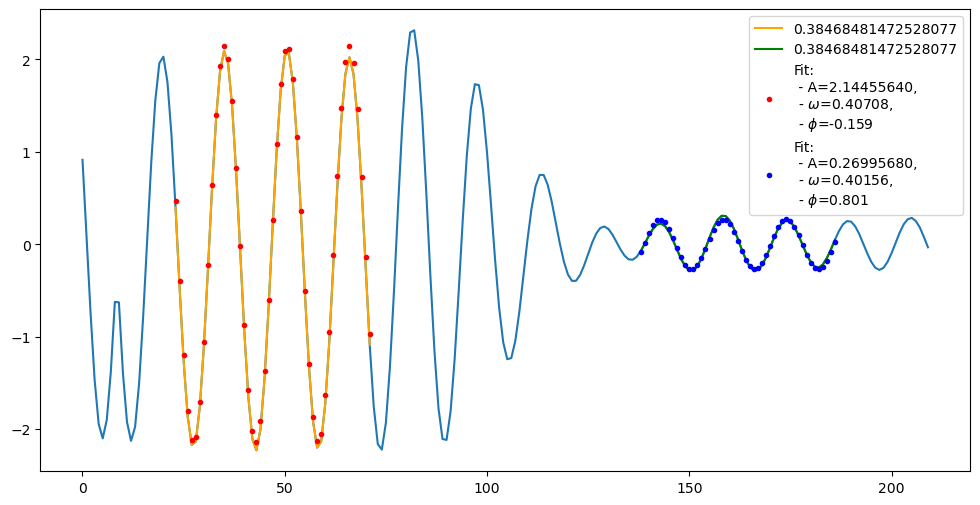

Plot


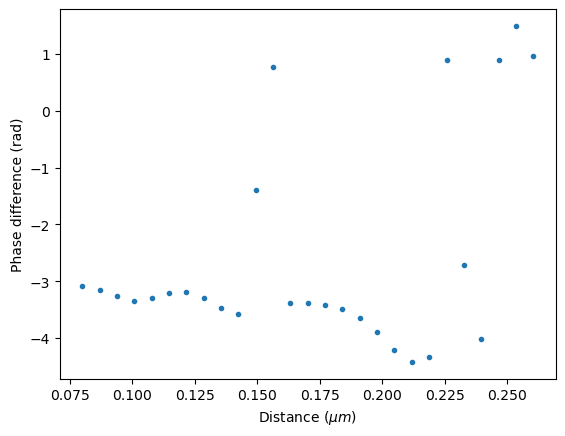

-----------
Initializing structure...
time for choose_chunkdivision = 0.000249147 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.071537 s
-----------


FloatProgress(value=0.0, description='0% done ', max=600.0)

Meep progress: 449.71875/600.0 = 75.0% done in 4.0s, 1.3s to go
on time step 14410 (time=450.312), 0.000277612 s/step
run 0 finished at t = 600.0 (19200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000172138 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     cylinder, center = (0,0.267347,0)
          radius 2.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
     cylinder, center = (0,0.267347,0)
          radius 2, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.122717 s
-----------


FloatProgress(value=0.0, description='0% done ', max=600.0)

Meep progress: 347.4375/600.0 = 57.9% done in 4.0s, 2.9s to go
on time step 11132 (time=347.875), 0.000359331 s/step
harminv0:, frequency, imag. freq., Q, |amp|, amplitude, error
harminv0:, 0.7031692871081527, -0.0007179502839703467, 489.7061139244536, 0.0440913995557797, -0.035437672161479625+0.026234002869613752i, 7.166833552086417e-12+0.0i
run 0 finished at t = 600.0 (19200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.142554 s
-----------


FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 147.15625/1000.0 = 14.7% done in 4.0s, 23.2s to go
on time step 4713 (time=147.281), 0.000848809 s/step
Meep progress: 283.34375/1000.0 = 28.3% done in 8.0s, 20.2s to go
on time step 9074 (time=283.562), 0.00091737 s/step
Meep progress: 411.3125/1000.0 = 41.1% done in 12.0s, 17.2s to go
on time step 13171 (time=411.594), 0.000976479 s/step
Meep progress: 551.09375/1000.0 = 55.1% done in 16.0s, 13.0s to go
on time step 17646 (time=551.438), 0.00089391 s/step
Meep progress: 687.53125/1000.0 = 68.8% done in 20.0s, 9.1s to go
on time step 22013 (time=687.906), 0.000915968 s/step
Meep progress: 834.9375/1000.0 = 83.5% done in 24.0s, 4.7s to go
on time step 26734 (time=835.438), 0.000847401 s/step
Meep progress: 990.09375/1000.0 = 99.0% done in 28.0s, 0.3s to go
on time step 31698 (time=990.562), 0.000805864 s/step
run 0 finished at t = 1000.0 (32000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000478029 s
Working in 2D dimensions.
Computa

FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 152.625/1000.0 = 15.3% done in 4.0s, 22.2s to go
on time step 4897 (time=153.031), 0.000816924 s/step
Meep progress: 293.78125/1000.0 = 29.4% done in 8.0s, 19.2s to go
on time step 9416 (time=294.25), 0.000885329 s/step
Meep progress: 432.09375/1000.0 = 43.2% done in 12.0s, 15.8s to go
on time step 13840 (time=432.5), 0.000904367 s/step
Meep progress: 572.59375/1000.0 = 57.3% done in 16.0s, 11.9s to go
on time step 18338 (time=573.062), 0.000889307 s/step
Meep progress: 747.8125/1000.0 = 74.8% done in 20.0s, 6.7s to go
on time step 23957 (time=748.656), 0.000712015 s/step
Meep progress: 979.4375/1000.0 = 97.9% done in 24.0s, 0.5s to go
on time step 31367 (time=980.219), 0.000539816 s/step
run 0 finished at t = 1000.0 (32000 timesteps)


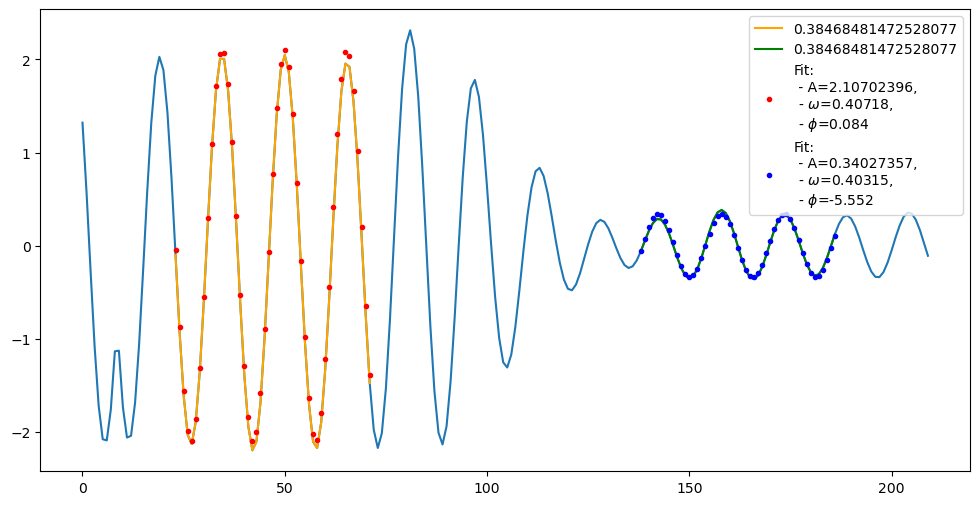

up shift in phase
Plot


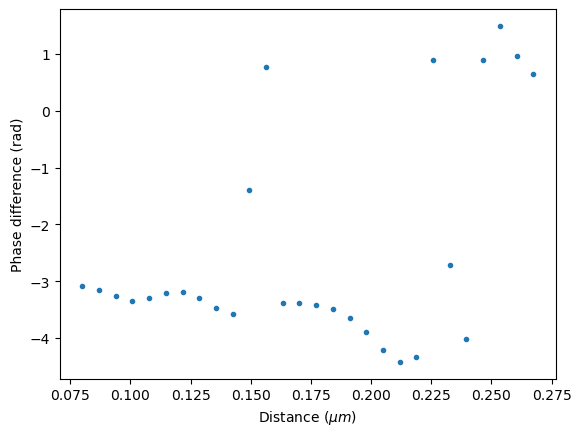

-----------
Initializing structure...
time for choose_chunkdivision = 0.000166178 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.0724831 s
-----------


FloatProgress(value=0.0, description='0% done ', max=600.0)

Meep progress: 477.53125/600.0 = 79.6% done in 4.0s, 1.0s to go
on time step 15305 (time=478.281), 0.000261365 s/step
run 0 finished at t = 600.0 (19200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000344038 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     cylinder, center = (0,0.274286,0)
          radius 2.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
     cylinder, center = (0,0.274286,0)
          radius 2, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.18318 s
-----------


FloatProgress(value=0.0, description='0% done ', max=600.0)

Meep progress: 450.03125/600.0 = 75.0% done in 4.0s, 1.3s to go
on time step 14412 (time=450.375), 0.000277553 s/step
harminv0:, frequency, imag. freq., Q, |amp|, amplitude, error
harminv0:, 0.7031382571970135, -0.000697390594961988, 504.1208343477437, 0.04300196322605291, -0.03506624791436344+0.02489030129394195i, 2.915774692088323e-11+0.0i
run 0 finished at t = 600.0 (19200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000200987 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.11426 s
-----------


FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 163.3125/1000.0 = 16.3% done in 4.0s, 20.5s to go
on time step 5229 (time=163.406), 0.000765152 s/step
Meep progress: 311.625/1000.0 = 31.2% done in 8.0s, 17.7s to go
on time step 9977 (time=311.781), 0.000842684 s/step
Meep progress: 465.0625/1000.0 = 46.5% done in 12.0s, 13.8s to go
on time step 14889 (time=465.281), 0.000814416 s/step
Meep progress: 615.84375/1000.0 = 61.6% done in 16.0s, 10.0s to go
on time step 19714 (time=616.062), 0.000829114 s/step
Meep progress: 760.0/1000.0 = 76.0% done in 20.0s, 6.3s to go
on time step 24329 (time=760.281), 0.000866879 s/step
Meep progress: 909.9375/1000.0 = 91.0% done in 24.0s, 2.4s to go
on time step 29130 (time=910.312), 0.00083322 s/step
run 0 finished at t = 1000.0 (32000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000335932 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     cylinder, center = (0,0.274286,0)
          radius 2.5, height 1e+20, axis 

FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 148.34375/1000.0 = 14.8% done in 4.0s, 23.0s to go
on time step 4755 (time=148.594), 0.000841275 s/step
Meep progress: 299.59375/1000.0 = 30.0% done in 8.0s, 18.7s to go
on time step 9595 (time=299.844), 0.000826472 s/step
Meep progress: 455.4375/1000.0 = 45.5% done in 12.0s, 14.3s to go
on time step 14588 (time=455.875), 0.000801206 s/step
Meep progress: 692.59375/1000.0 = 69.3% done in 16.0s, 7.1s to go
on time step 22178 (time=693.062), 0.000527076 s/step
Meep progress: 929.25/1000.0 = 92.9% done in 20.0s, 1.5s to go
on time step 29756 (time=929.875), 0.000527884 s/step
run 0 finished at t = 1000.0 (32000 timesteps)


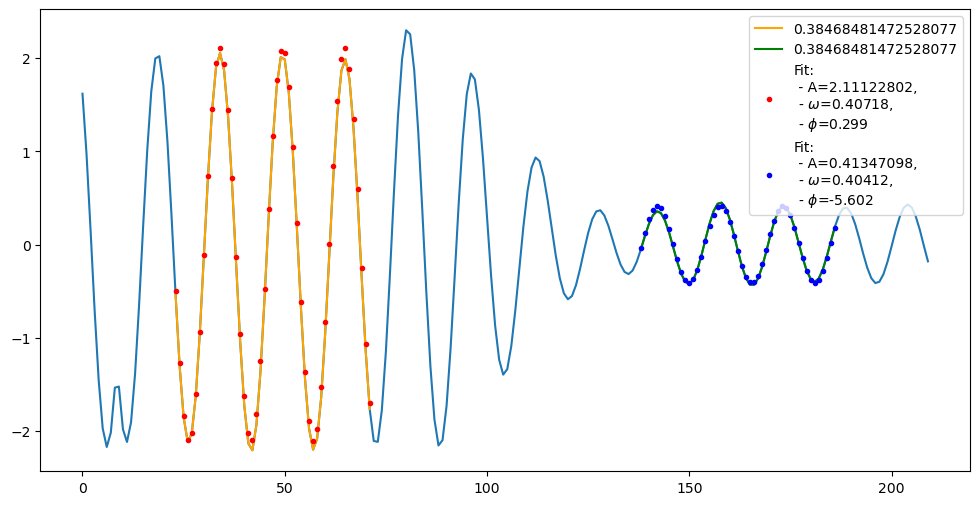

up shift in phase
Plot


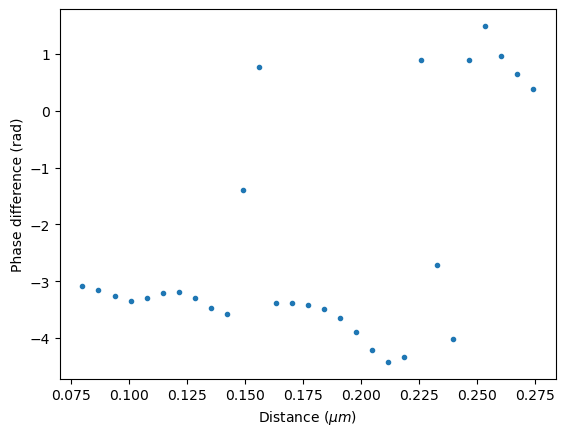

-----------
Initializing structure...
time for choose_chunkdivision = 0.000267029 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.092412 s
-----------


FloatProgress(value=0.0, description='0% done ', max=600.0)

Meep progress: 481.375/600.0 = 80.2% done in 4.0s, 1.0s to go
on time step 15431 (time=482.219), 0.00025924 s/step
run 0 finished at t = 600.0 (19200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000185013 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     cylinder, center = (0,0.281224,0)
          radius 2.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
     cylinder, center = (0,0.281224,0)
          radius 2, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.119365 s
-----------


FloatProgress(value=0.0, description='0% done ', max=600.0)

Meep progress: 424.5625/600.0 = 70.8% done in 4.0s, 1.7s to go
on time step 13595 (time=424.844), 0.000294247 s/step
harminv0:, frequency, imag. freq., Q, |amp|, amplitude, error
harminv0:, 0.7031159695770285, -0.0006774085484956401, 518.9748277745227, 0.04197964086926146, -0.03460355730221912+0.02376728990743802i, 4.9661834085244735e-11+0.0i
run 0 finished at t = 600.0 (19200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000249863 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.123582 s
-----------


FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 203.0/1000.0 = 20.3% done in 4.0s, 15.7s to go
on time step 6502 (time=203.188), 0.000615223 s/step
Meep progress: 365.5/1000.0 = 36.5% done in 8.0s, 13.9s to go
on time step 11702 (time=365.688), 0.000769329 s/step
Meep progress: 512.15625/1000.0 = 51.2% done in 12.0s, 11.4s to go
on time step 16397 (time=512.406), 0.000852167 s/step
Meep progress: 660.0/1000.0 = 66.0% done in 16.0s, 8.2s to go
on time step 21129 (time=660.281), 0.000845321 s/step
Meep progress: 801.1875/1000.0 = 80.1% done in 20.0s, 5.0s to go
on time step 25650 (time=801.562), 0.000884904 s/step
Meep progress: 943.1875/1000.0 = 94.3% done in 24.0s, 1.4s to go
on time step 30194 (time=943.562), 0.000880309 s/step
run 0 finished at t = 1000.0 (32000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000307083 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     cylinder, center = (0,0.281224,0)
          radius 2.5, height 1e+20, axis (0, 

FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 136.75/1000.0 = 13.7% done in 4.0s, 25.3s to go
on time step 4382 (time=136.938), 0.000913076 s/step
Meep progress: 278.53125/1000.0 = 27.9% done in 8.0s, 20.7s to go
on time step 8926 (time=278.938), 0.000880327 s/step
Meep progress: 464.03125/1000.0 = 46.4% done in 12.0s, 13.9s to go
on time step 14863 (time=464.469), 0.000673787 s/step
Meep progress: 670.625/1000.0 = 67.1% done in 16.0s, 7.9s to go
on time step 21473 (time=671.031), 0.000605233 s/step
Meep progress: 854.5625/1000.0 = 85.5% done in 20.0s, 3.4s to go
on time step 27362 (time=855.062), 0.00067928 s/step
run 0 finished at t = 1000.0 (32000 timesteps)


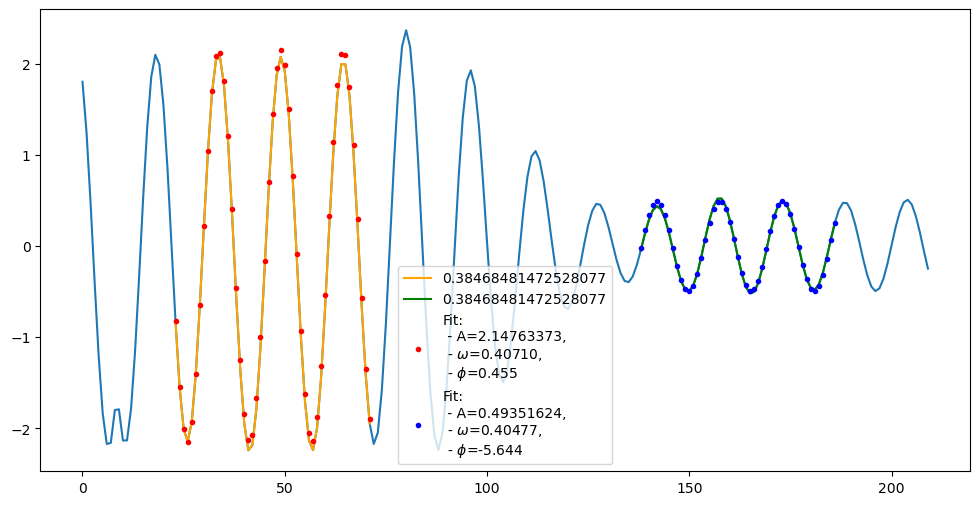

up shift in phase
Plot


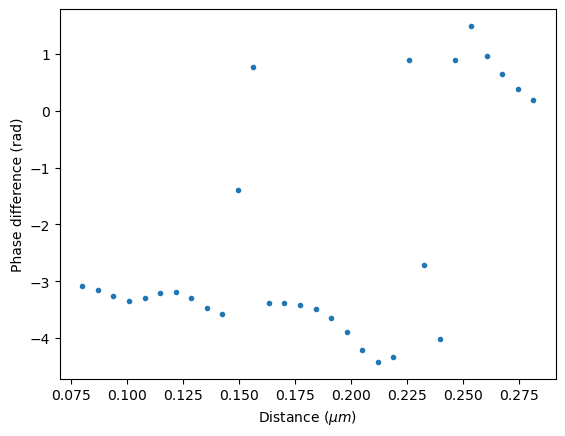

-----------
Initializing structure...
time for choose_chunkdivision = 0.000216007 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.0666621 s
-----------


FloatProgress(value=0.0, description='0% done ', max=600.0)

Meep progress: 419.78125/600.0 = 70.0% done in 4.0s, 1.7s to go
on time step 13450 (time=420.312), 0.000297399 s/step
run 0 finished at t = 600.0 (19200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000208139 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     cylinder, center = (0,0.288163,0)
          radius 2.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
     cylinder, center = (0,0.288163,0)
          radius 2, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.140098 s
-----------


FloatProgress(value=0.0, description='0% done ', max=600.0)

Meep progress: 361.71875/600.0 = 60.3% done in 4.0s, 2.6s to go
on time step 11590 (time=362.188), 0.000345127 s/step
harminv0:, frequency, imag. freq., Q, |amp|, amplitude, error
harminv0:, 0.7030929668320316, -0.0006599207223566384, 532.7101748837505, 0.04101567745229595, -0.03417345463685988+0.022681728220161235i, 1.3522113127722849e-11+0.0i
run 0 finished at t = 600.0 (19200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000358105 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.181029 s
-----------


FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 142.6875/1000.0 = 14.3% done in 4.0s, 24.0s to go
on time step 4573 (time=142.906), 0.000874801 s/step
Meep progress: 281.0/1000.0 = 28.1% done in 8.0s, 20.5s to go
on time step 8999 (time=281.219), 0.000904004 s/step
Meep progress: 422.0/1000.0 = 42.2% done in 12.0s, 16.4s to go
on time step 13512 (time=422.25), 0.000886373 s/step
Meep progress: 559.75/1000.0 = 56.0% done in 16.0s, 12.6s to go
on time step 17921 (time=560.031), 0.000907247 s/step
Meep progress: 703.53125/1000.0 = 70.4% done in 20.0s, 8.4s to go
on time step 22520 (time=703.75), 0.000869807 s/step
Meep progress: 864.6875/1000.0 = 86.5% done in 24.0s, 3.8s to go
on time step 27690 (time=865.312), 0.000773864 s/step
run 0 finished at t = 1000.0 (32000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000242949 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     cylinder, center = (0,0.288163,0)
          radius 2.5, height 1e+20, axis (0, 0

FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 239.59375/1000.0 = 24.0% done in 4.0s, 12.7s to go
on time step 7675 (time=239.844), 0.000521223 s/step
Meep progress: 478.46875/1000.0 = 47.8% done in 8.0s, 8.7s to go
on time step 15321 (time=478.781), 0.000523293 s/step
Meep progress: 716.75/1000.0 = 71.7% done in 12.0s, 4.7s to go
on time step 22947 (time=717.094), 0.000524625 s/step
Meep progress: 935.3125/1000.0 = 93.5% done in 16.0s, 1.1s to go
on time step 29943 (time=935.719), 0.000571768 s/step
run 0 finished at t = 1000.0 (32000 timesteps)


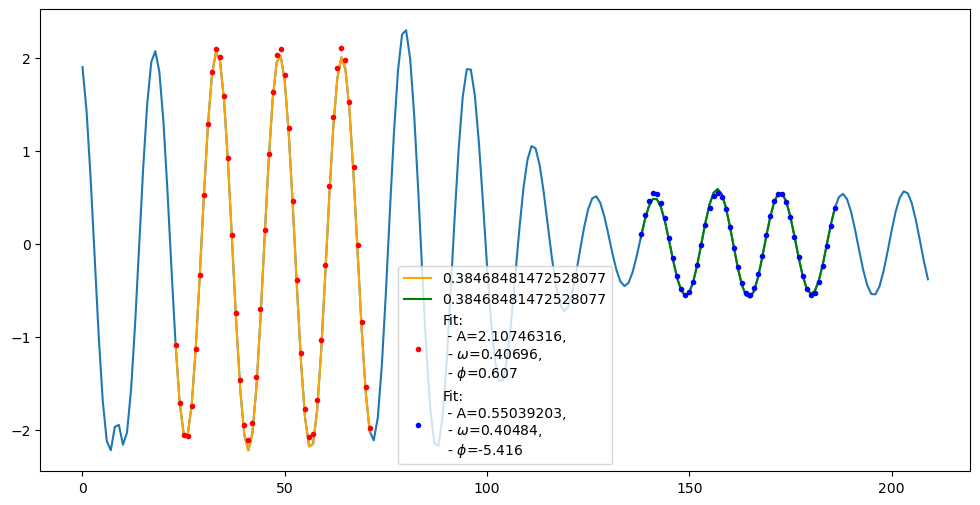

up shift in phase
Plot


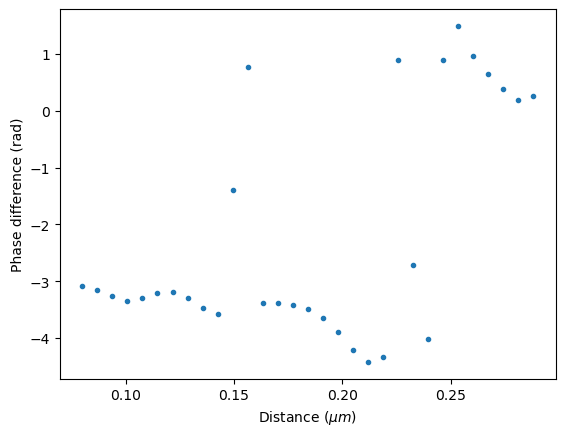

-----------
Initializing structure...
time for choose_chunkdivision = 0.000221014 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.087939 s
-----------


FloatProgress(value=0.0, description='0% done ', max=600.0)

Meep progress: 453.65625/600.0 = 75.6% done in 4.0s, 1.3s to go
on time step 14540 (time=454.375), 0.00027512 s/step
run 0 finished at t = 600.0 (19200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000211 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     cylinder, center = (0,0.295102,0)
          radius 2.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
     cylinder, center = (0,0.295102,0)
          radius 2, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.121642 s
-----------


FloatProgress(value=0.0, description='0% done ', max=600.0)

Meep progress: 324.1875/600.0 = 54.0% done in 4.0s, 3.4s to go
on time step 10383 (time=324.469), 0.00038527 s/step
Meep progress: 559.0625/600.0 = 93.2% done in 8.0s, 0.6s to go
on time step 17902 (time=559.438), 0.000532038 s/step
harminv0:, frequency, imag. freq., Q, |amp|, amplitude, error
harminv0:, 0.7030770688465475, -0.0006435559128254267, 546.2439664020823, 0.04014258297249205, -0.03370281248846527+0.02180704927473586i, 5.0956489642051325e-12+0.0i
run 0 finished at t = 600.0 (19200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00033021 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.166679 s
-----------


FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 147.1875/1000.0 = 14.7% done in 4.0s, 23.2s to go
on time step 4718 (time=147.438), 0.000847822 s/step
Meep progress: 291.0625/1000.0 = 29.1% done in 8.0s, 19.5s to go
on time step 9319 (time=291.219), 0.000869549 s/step
Meep progress: 420.90625/1000.0 = 42.1% done in 12.0s, 16.5s to go
on time step 13476 (time=421.125), 0.000962233 s/step
Meep progress: 561.46875/1000.0 = 56.1% done in 16.0s, 12.5s to go
on time step 17978 (time=561.812), 0.000888545 s/step
Meep progress: 716.0/1000.0 = 71.6% done in 20.0s, 7.9s to go
on time step 22923 (time=716.344), 0.000808972 s/step
Meep progress: 924.21875/1000.0 = 92.4% done in 24.0s, 2.0s to go
on time step 29597 (time=924.906), 0.000599396 s/step
run 0 finished at t = 1000.0 (32000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000195026 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     cylinder, center = (0,0.295102,0)
          radius 2.5, height 1e+20, a

FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 221.6875/1000.0 = 22.2% done in 4.0s, 14.0s to go
on time step 7101 (time=221.906), 0.000563314 s/step
Meep progress: 421.21875/1000.0 = 42.1% done in 8.0s, 11.0s to go
on time step 13489 (time=421.531), 0.000626331 s/step
Meep progress: 614.9375/1000.0 = 61.5% done in 12.0s, 7.5s to go
on time step 19687 (time=615.219), 0.000645428 s/step
Meep progress: 829.5625/1000.0 = 83.0% done in 16.0s, 3.3s to go
on time step 26558 (time=829.938), 0.000582225 s/step
run 0 finished at t = 1000.0 (32000 timesteps)


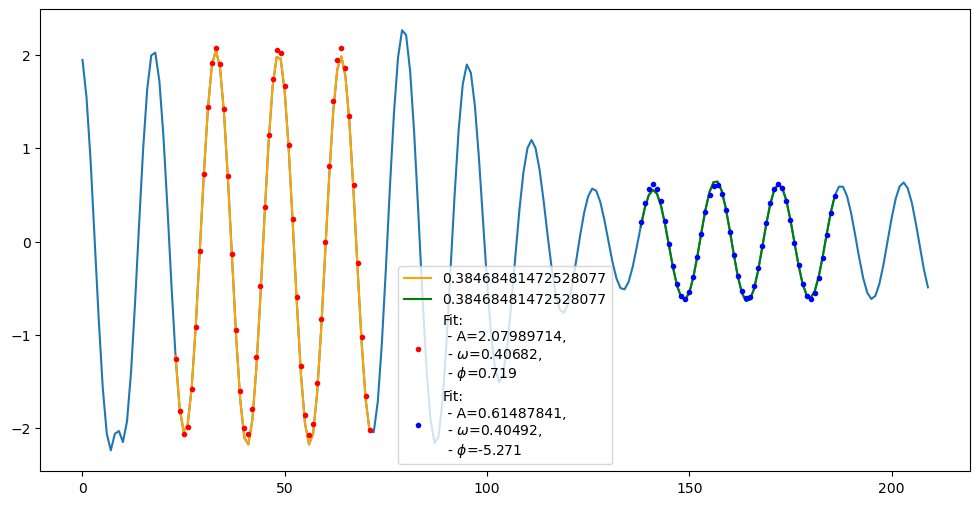

up shift in phase
Plot


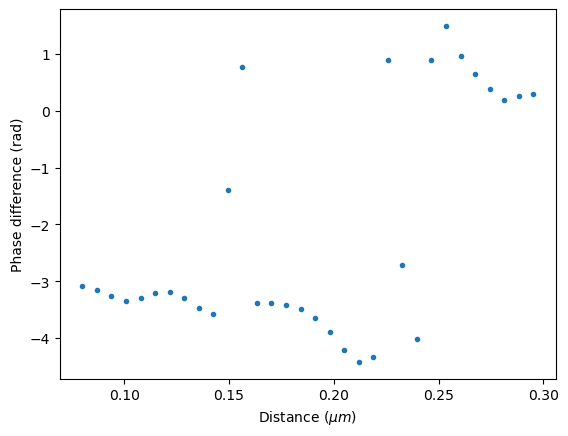

-----------
Initializing structure...
time for choose_chunkdivision = 0.000258923 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.102898 s
-----------


FloatProgress(value=0.0, description='0% done ', max=600.0)

Meep progress: 375.4375/600.0 = 62.6% done in 4.0s, 2.4s to go
on time step 12039 (time=376.219), 0.00033229 s/step
run 0 finished at t = 600.0 (19200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000387907 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     cylinder, center = (0,0.302041,0)
          radius 2.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
     cylinder, center = (0,0.302041,0)
          radius 2, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.128805 s
-----------


FloatProgress(value=0.0, description='0% done ', max=600.0)

Meep progress: 333.46875/600.0 = 55.6% done in 4.0s, 3.2s to go
on time step 10683 (time=333.844), 0.00037443 s/step
harminv0:, frequency, imag. freq., Q, |amp|, amplitude, error
harminv0:, 0.703066092887386, -0.0006281521178615615, 559.6304405379198, 0.039349970580474826, -0.03320821075893018+0.021110066860971995i, 3.0604253395754017e-12+0.0i
run 0 finished at t = 600.0 (19200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000248909 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.12786 s
-----------


FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 211.9375/1000.0 = 21.2% done in 4.0s, 14.9s to go
on time step 6790 (time=212.188), 0.000589194 s/step
Meep progress: 435.5/1000.0 = 43.5% done in 8.0s, 10.4s to go
on time step 13949 (time=435.906), 0.000558752 s/step
Meep progress: 682.21875/1000.0 = 68.2% done in 12.0s, 5.6s to go
on time step 21845 (time=682.656), 0.000506625 s/step
Meep progress: 924.0625/1000.0 = 92.4% done in 16.0s, 1.3s to go
on time step 29588 (time=924.625), 0.00051661 s/step
run 0 finished at t = 1000.0 (32000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000234842 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     cylinder, center = (0,0.302041,0)
          radius 2.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
     cylinder, center = (0,0.302041,0)
          radius 2, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, cente

FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 248.46875/1000.0 = 24.8% done in 4.0s, 12.1s to go
on time step 7963 (time=248.844), 0.000502328 s/step
Meep progress: 480.1875/1000.0 = 48.0% done in 8.0s, 8.7s to go
on time step 15378 (time=480.562), 0.00053946 s/step
Meep progress: 736.40625/1000.0 = 73.6% done in 12.0s, 4.3s to go
on time step 23577 (time=736.781), 0.000487927 s/step
Meep progress: 983.09375/1000.0 = 98.3% done in 16.0s, 0.3s to go
on time step 31477 (time=983.656), 0.000506378 s/step
run 0 finished at t = 1000.0 (32000 timesteps)


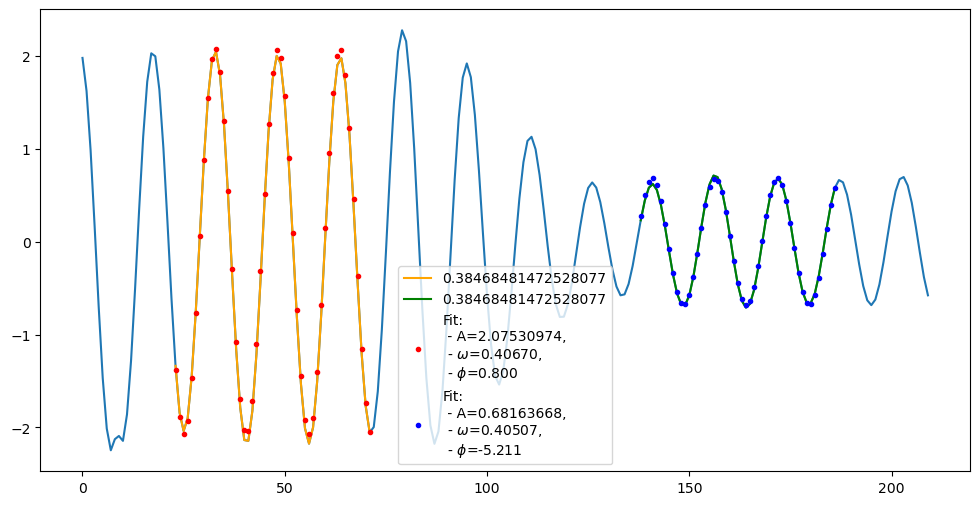

up shift in phase
Plot


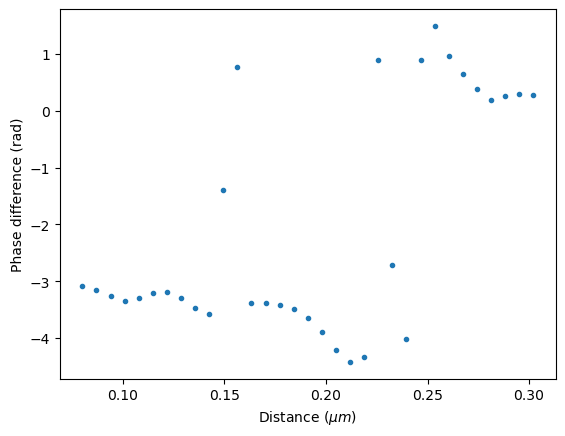

-----------
Initializing structure...
time for choose_chunkdivision = 0.000197172 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.073874 s
-----------


FloatProgress(value=0.0, description='0% done ', max=600.0)

Meep progress: 480.96875/600.0 = 80.2% done in 4.0s, 1.0s to go
on time step 15415 (time=481.719), 0.000259531 s/step
run 0 finished at t = 600.0 (19200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000173092 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     cylinder, center = (0,0.30898,0)
          radius 2.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
     cylinder, center = (0,0.30898,0)
          radius 2, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.124268 s
-----------


FloatProgress(value=0.0, description='0% done ', max=600.0)

Meep progress: 482.71875/600.0 = 80.5% done in 4.0s, 1.0s to go
on time step 15468 (time=483.375), 0.000258607 s/step
harminv0:, frequency, imag. freq., Q, |amp|, amplitude, error
harminv0:, 0.7030523243501987, -0.0006137640537421211, 572.7382697501481, 0.03863181316940964, -0.0327824565285436+0.020438383808665535i, 2.49027288195168e-12+0.0i
run 0 finished at t = 600.0 (19200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000237942 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.128197 s
-----------


FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 160.1875/1000.0 = 16.0% done in 4.0s, 21.0s to go
on time step 5134 (time=160.438), 0.000779269 s/step
Meep progress: 316.78125/1000.0 = 31.7% done in 8.0s, 17.3s to go
on time step 10146 (time=317.062), 0.000798104 s/step
Meep progress: 470.53125/1000.0 = 47.1% done in 12.0s, 13.5s to go
on time step 15067 (time=470.844), 0.000812881 s/step
Meep progress: 619.75/1000.0 = 62.0% done in 16.0s, 9.8s to go
on time step 19845 (time=620.156), 0.000837316 s/step
Meep progress: 775.375/1000.0 = 77.5% done in 20.0s, 5.8s to go
on time step 24827 (time=775.844), 0.000803107 s/step
Meep progress: 935.3125/1000.0 = 93.5% done in 24.0s, 1.7s to go
on time step 29946 (time=935.812), 0.000781437 s/step
run 0 finished at t = 1000.0 (32000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00030899 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     cylinder, center = (0,0.30898,0)
          radius 2.5, height 1e+20, axis

FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 191.1875/1000.0 = 19.1% done in 4.0s, 16.9s to go
on time step 6127 (time=191.469), 0.000652898 s/step
Meep progress: 436.09375/1000.0 = 43.6% done in 8.0s, 10.3s to go
on time step 13964 (time=436.375), 0.00051051 s/step
Meep progress: 691.25/1000.0 = 69.1% done in 12.0s, 5.4s to go
on time step 22131 (time=691.594), 0.000489803 s/step
Meep progress: 939.75/1000.0 = 94.0% done in 16.0s, 1.0s to go
on time step 30088 (time=940.25), 0.00050271 s/step
run 0 finished at t = 1000.0 (32000 timesteps)


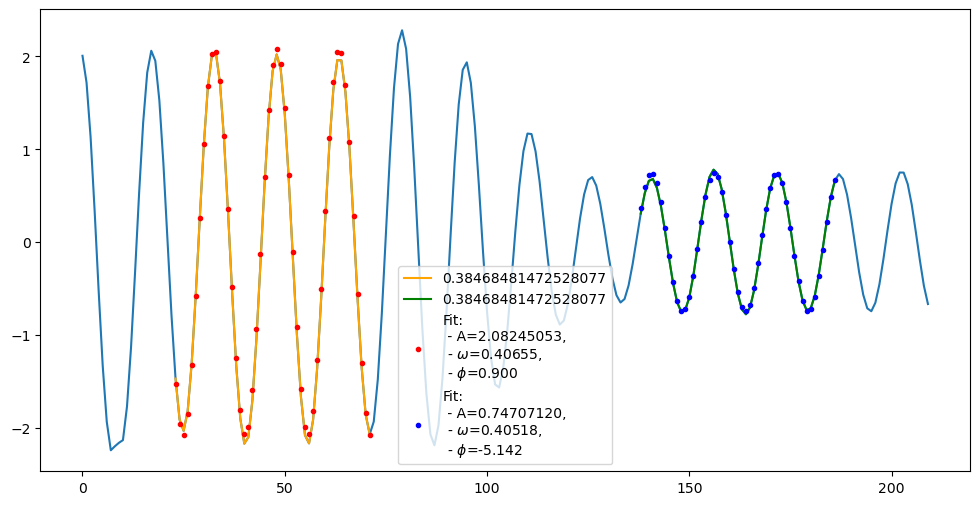

up shift in phase
Plot


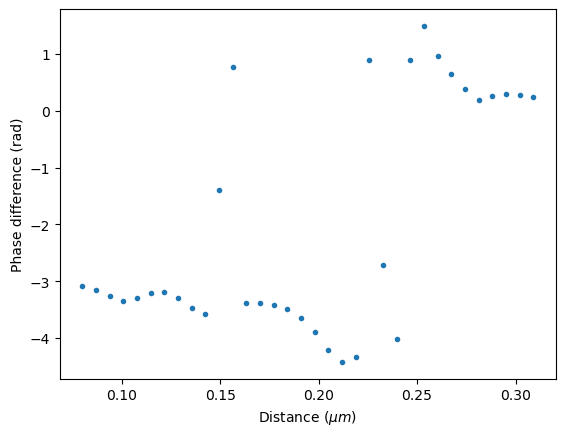

-----------
Initializing structure...
time for choose_chunkdivision = 0.000166893 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.0645671 s
-----------


FloatProgress(value=0.0, description='0% done ', max=600.0)

Meep progress: 471.3125/600.0 = 78.6% done in 4.0s, 1.1s to go
on time step 15106 (time=472.062), 0.000264801 s/step
run 0 finished at t = 600.0 (19200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000369787 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     cylinder, center = (0,0.315918,0)
          radius 2.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
     cylinder, center = (0,0.315918,0)
          radius 2, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.17776 s
-----------


FloatProgress(value=0.0, description='0% done ', max=600.0)

Meep progress: 437.40625/600.0 = 72.9% done in 4.0s, 1.5s to go
on time step 14018 (time=438.062), 0.00028538 s/step
harminv0:, frequency, imag. freq., Q, |amp|, amplitude, error
harminv0:, 0.7030317938767887, -0.0006003201021550925, 585.5474365700657, 0.03760865911261898, -0.03214879640840943+0.01951579180407035i, 2.1872915632532874e-12+0.0i
run 0 finished at t = 600.0 (19200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000241995 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.128747 s
-----------


FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 174.375/1000.0 = 17.4% done in 4.0s, 18.9s to go
on time step 5586 (time=174.562), 0.000716122 s/step
Meep progress: 328.125/1000.0 = 32.8% done in 8.0s, 16.4s to go
on time step 10508 (time=328.375), 0.000812968 s/step
Meep progress: 484.28125/1000.0 = 48.4% done in 12.0s, 12.8s to go
on time step 15506 (time=484.562), 0.000800367 s/step
Meep progress: 644.5/1000.0 = 64.5% done in 16.0s, 8.8s to go
on time step 20635 (time=644.844), 0.000779979 s/step
Meep progress: 800.6875/1000.0 = 80.1% done in 20.0s, 5.0s to go
on time step 25635 (time=801.094), 0.000800196 s/step
Meep progress: 957.71875/1000.0 = 95.8% done in 24.0s, 1.1s to go
on time step 30663 (time=958.219), 0.000795644 s/step
run 0 finished at t = 1000.0 (32000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000311852 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     cylinder, center = (0,0.315918,0)
          radius 2.5, height 1e+20, axis

FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 164.3125/1000.0 = 16.4% done in 4.0s, 20.3s to go
on time step 5264 (time=164.5), 0.000759954 s/step
Meep progress: 404.59375/1000.0 = 40.5% done in 8.0s, 11.8s to go
on time step 12960 (time=405), 0.000519856 s/step
Meep progress: 650.59375/1000.0 = 65.1% done in 12.0s, 6.4s to go
on time step 20831 (time=650.969), 0.000508274 s/step
Meep progress: 900.75/1000.0 = 90.1% done in 16.0s, 1.8s to go
on time step 28838 (time=901.188), 0.000499592 s/step
run 0 finished at t = 1000.0 (32000 timesteps)


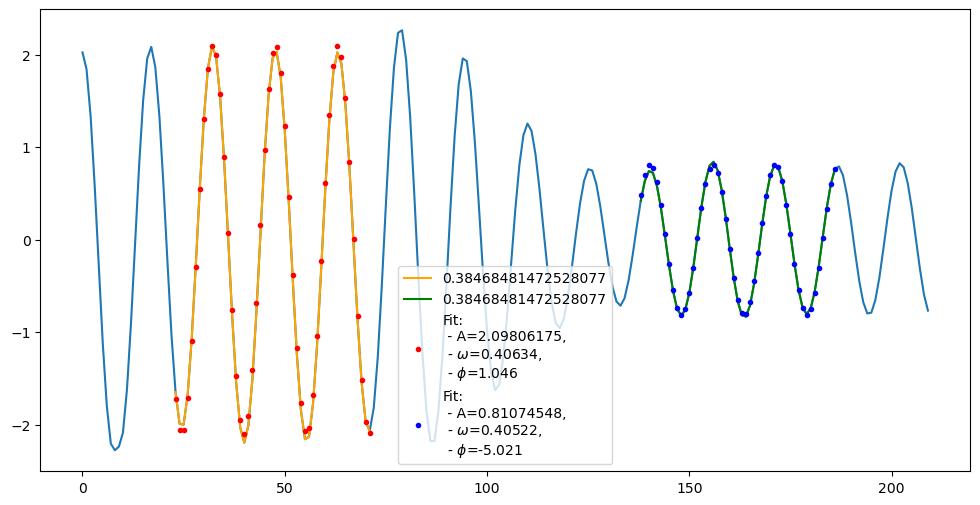

up shift in phase
Plot


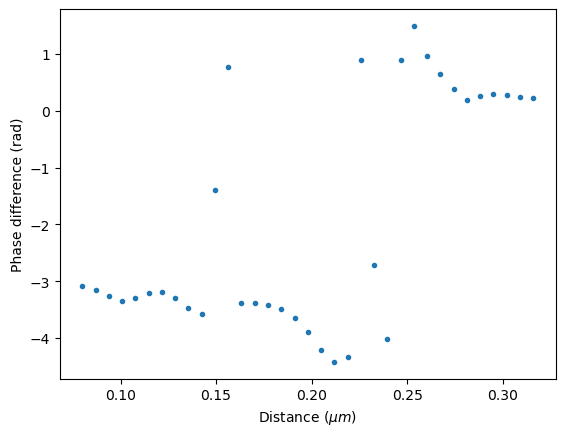

-----------
Initializing structure...
time for choose_chunkdivision = 0.000205994 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.083746 s
-----------


FloatProgress(value=0.0, description='0% done ', max=600.0)

Meep progress: 502.125/600.0 = 83.7% done in 4.0s, 0.8s to go
on time step 16082 (time=502.562), 0.00024873 s/step
run 0 finished at t = 600.0 (19200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000218153 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     cylinder, center = (0,0.322857,0)
          radius 2.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
     cylinder, center = (0,0.322857,0)
          radius 2, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.136198 s
-----------


FloatProgress(value=0.0, description='0% done ', max=600.0)

Meep progress: 475.46875/600.0 = 79.2% done in 4.0s, 1.0s to go
on time step 15228 (time=475.875), 0.000262681 s/step
harminv0:, frequency, imag. freq., Q, |amp|, amplitude, error
harminv0:, 0.7030048594235161, -0.0005876679601350895, 598.1310085902196, 0.03630938026200389, -0.03134009637136217+0.018334924446109117i, 2.1337190204049997e-12+0.0i
run 0 finished at t = 600.0 (19200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.16791 s
-----------


FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 186.65625/1000.0 = 18.7% done in 4.0s, 17.4s to go
on time step 5977 (time=186.781), 0.000669314 s/step
Meep progress: 340.09375/1000.0 = 34.0% done in 8.0s, 15.5s to go
on time step 10889 (time=340.281), 0.00081435 s/step
Meep progress: 502.625/1000.0 = 50.3% done in 12.0s, 11.9s to go
on time step 16092 (time=502.875), 0.000769025 s/step
Meep progress: 661.0/1000.0 = 66.1% done in 16.0s, 8.2s to go
on time step 21160 (time=661.25), 0.000789414 s/step
Meep progress: 823.3125/1000.0 = 82.3% done in 20.0s, 4.3s to go
on time step 26356 (time=823.625), 0.000769894 s/step
Meep progress: 982.78125/1000.0 = 98.3% done in 24.0s, 0.4s to go
on time step 31462 (time=983.188), 0.000783404 s/step
run 0 finished at t = 1000.0 (32000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000308037 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     cylinder, center = (0,0.322857,0)
          radius 2.5, height 1e+20, axis

FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 158.375/1000.0 = 15.8% done in 4.0s, 21.3s to go
on time step 5074 (time=158.562), 0.000788413 s/step
Meep progress: 390.25/1000.0 = 39.0% done in 8.0s, 12.5s to go
on time step 12502 (time=390.688), 0.00053856 s/step
Meep progress: 645.4375/1000.0 = 64.5% done in 12.0s, 6.6s to go
on time step 20672 (time=646), 0.000489636 s/step
Meep progress: 904.0/1000.0 = 90.4% done in 16.0s, 1.7s to go
on time step 28947 (time=904.594), 0.000483441 s/step
run 0 finished at t = 1000.0 (32000 timesteps)


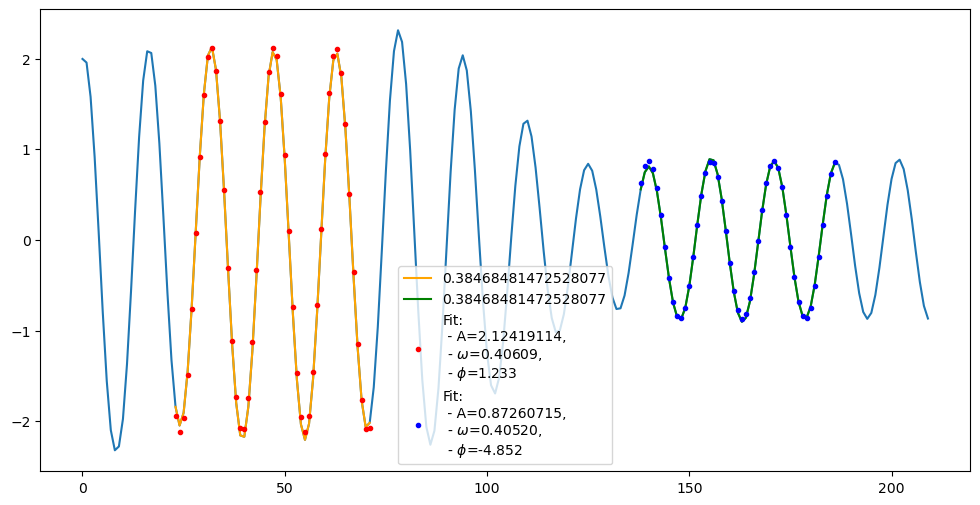

up shift in phase
Plot


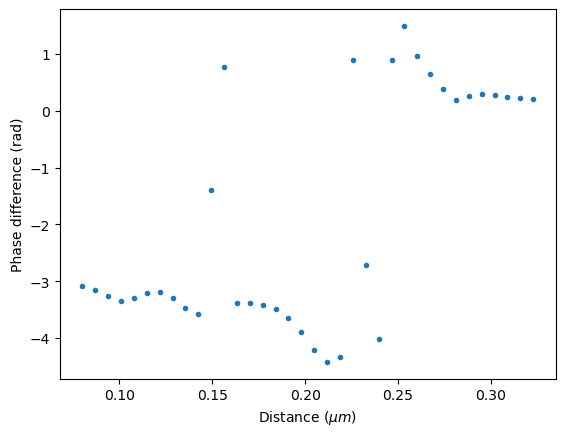

-----------
Initializing structure...
time for choose_chunkdivision = 0.000200033 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.0737391 s
-----------


FloatProgress(value=0.0, description='0% done ', max=600.0)

Meep progress: 497.625/600.0 = 82.9% done in 4.0s, 0.8s to go
on time step 15945 (time=498.281), 0.000250866 s/step
run 0 finished at t = 600.0 (19200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000188828 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     cylinder, center = (0,0.329796,0)
          radius 2.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
     cylinder, center = (0,0.329796,0)
          radius 2, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.124254 s
-----------


FloatProgress(value=0.0, description='0% done ', max=600.0)

Meep progress: 483.65625/600.0 = 80.6% done in 4.0s, 1.0s to go
on time step 15489 (time=484.031), 0.000258248 s/step
harminv0:, frequency, imag. freq., Q, |amp|, amplitude, error
harminv0:, 0.7029757504816304, -0.0005754857079925832, 610.767340281794, 0.03512457028438238, -0.030639076699791712+0.017175052158488444i, 4.9244767792497795e-12+0.0i
run 0 finished at t = 600.0 (19200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.166323 s
-----------


FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 233.15625/1000.0 = 23.3% done in 4.0s, 13.2s to go
on time step 7464 (time=233.25), 0.000535934 s/step
Meep progress: 392.8125/1000.0 = 39.3% done in 8.0s, 12.4s to go
on time step 12576 (time=393), 0.000782587 s/step
Meep progress: 552.53125/1000.0 = 55.3% done in 12.0s, 9.7s to go
on time step 17688 (time=552.75), 0.000782629 s/step
Meep progress: 716.46875/1000.0 = 71.6% done in 16.0s, 6.3s to go
on time step 22935 (time=716.719), 0.00076242 s/step
Meep progress: 880.6875/1000.0 = 88.1% done in 20.0s, 2.7s to go
on time step 28192 (time=881), 0.00076096 s/step
run 0 finished at t = 1000.0 (32000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000316143 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     cylinder, center = (0,0.329796,0)
          radius 2.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
     cylinder, center = (0,0.329796,0)
          

FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 150.90625/1000.0 = 15.1% done in 4.0s, 22.5s to go
on time step 4845 (time=151.406), 0.000825643 s/step
Meep progress: 309.5/1000.0 = 30.9% done in 8.0s, 17.8s to go
on time step 9921 (time=310.031), 0.000788052 s/step
Meep progress: 559.8125/1000.0 = 56.0% done in 12.0s, 9.4s to go
on time step 17943 (time=560.719), 0.000498665 s/step
Meep progress: 815.4375/1000.0 = 81.5% done in 16.0s, 3.6s to go
on time step 26123 (time=816.344), 0.00048903 s/step
run 0 finished at t = 1000.0 (32000 timesteps)


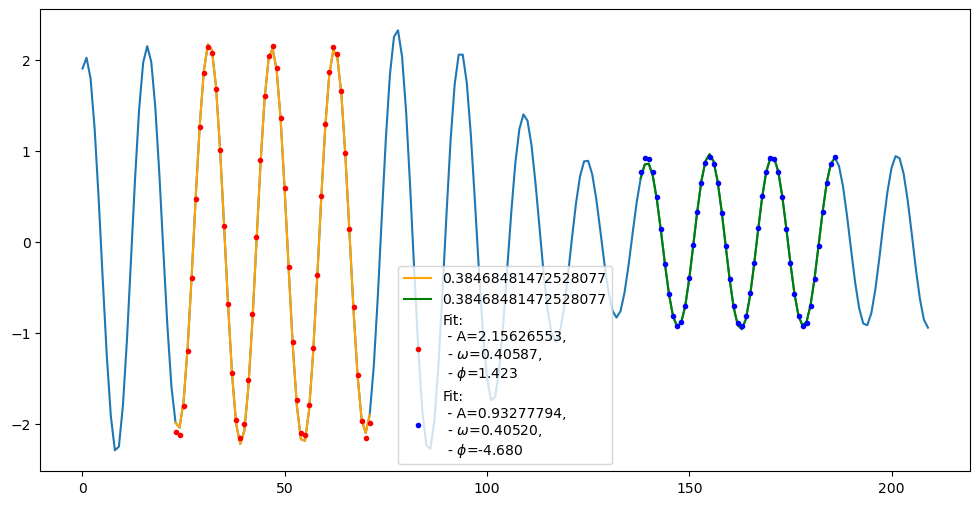

up shift in phase
Plot


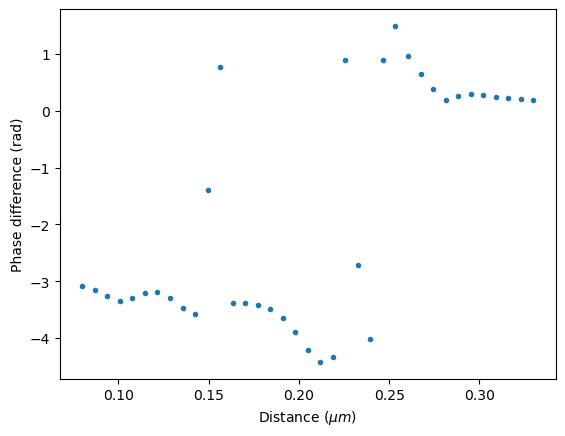

-----------
Initializing structure...
time for choose_chunkdivision = 0.000206947 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.0799298 s
-----------


FloatProgress(value=0.0, description='0% done ', max=600.0)

Meep progress: 506.78125/600.0 = 84.5% done in 4.0s, 0.7s to go
on time step 16233 (time=507.281), 0.000246413 s/step
run 0 finished at t = 600.0 (19200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000169039 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     cylinder, center = (0,0.336735,0)
          radius 2.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
     cylinder, center = (0,0.336735,0)
          radius 2, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.115982 s
-----------


FloatProgress(value=0.0, description='0% done ', max=600.0)

Meep progress: 367.46875/600.0 = 61.2% done in 4.0s, 2.5s to go
on time step 11765 (time=367.656), 0.000339994 s/step
harminv0:, frequency, imag. freq., Q, |amp|, amplitude, error
harminv0:, 0.7029525892447094, -0.0005634060955203487, 623.841838803216, 0.03404120997270652, -0.029959805988909613+0.016162116244873053i, 1.313010417921349e-11+0.0i
run 0 finished at t = 600.0 (19200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000370026 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.172438 s
-----------


FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 158.4375/1000.0 = 15.8% done in 4.0s, 21.2s to go
on time step 5076 (time=158.625), 0.000788045 s/step
Meep progress: 316.78125/1000.0 = 31.7% done in 8.0s, 17.3s to go
on time step 10145 (time=317.031), 0.000789269 s/step
Meep progress: 466.125/1000.0 = 46.6% done in 12.0s, 13.7s to go
on time step 14925 (time=466.406), 0.000836896 s/step
Meep progress: 625.90625/1000.0 = 62.6% done in 16.0s, 9.6s to go
on time step 20038 (time=626.188), 0.00078235 s/step
Meep progress: 767.9375/1000.0 = 76.8% done in 20.0s, 6.0s to go
on time step 24585 (time=768.281), 0.000879906 s/step
Meep progress: 923.5/1000.0 = 92.3% done in 24.0s, 2.0s to go
on time step 29565 (time=923.906), 0.000803419 s/step
run 0 finished at t = 1000.0 (32000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000334024 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     cylinder, center = (0,0.336735,0)
          radius 2.5, height 1e+20, axis

FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 149.9375/1000.0 = 15.0% done in 4.0s, 22.7s to go
on time step 4805 (time=150.156), 0.000832537 s/step
Meep progress: 395.78125/1000.0 = 39.6% done in 8.0s, 12.2s to go
on time step 12678 (time=396.188), 0.00050808 s/step
Meep progress: 648.96875/1000.0 = 64.9% done in 12.0s, 6.5s to go
on time step 20778 (time=649.312), 0.000493829 s/step
Meep progress: 885.125/1000.0 = 88.5% done in 16.0s, 2.1s to go
on time step 28338 (time=885.562), 0.000529135 s/step
run 0 finished at t = 1000.0 (32000 timesteps)


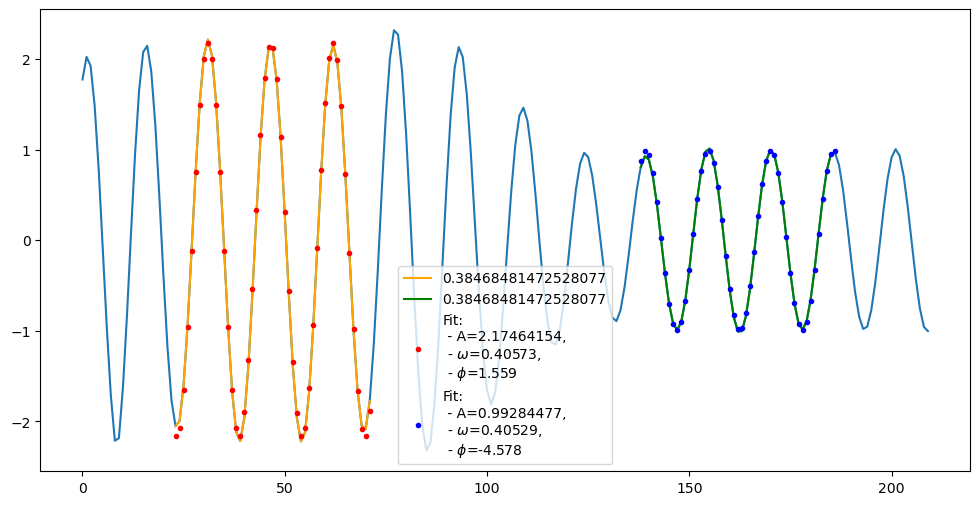

up shift in phase
Plot


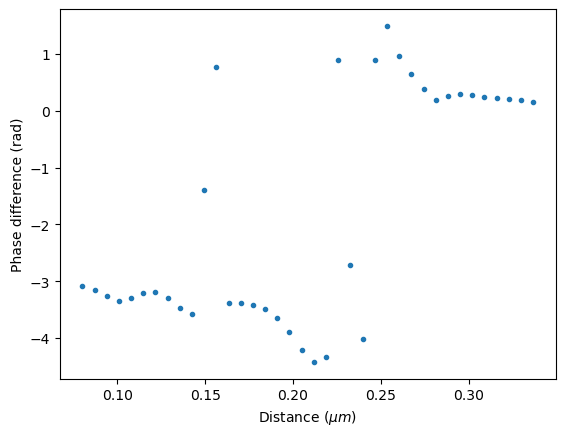

-----------
Initializing structure...
time for choose_chunkdivision = 0.000501156 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.075953 s
-----------


FloatProgress(value=0.0, description='0% done ', max=600.0)

Meep progress: 485.65625/600.0 = 80.9% done in 4.0s, 0.9s to go
on time step 15561 (time=486.281), 0.00025706 s/step
run 0 finished at t = 600.0 (19200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000212193 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     cylinder, center = (0,0.343673,0)
          radius 2.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
     cylinder, center = (0,0.343673,0)
          radius 2, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.141629 s
-----------


FloatProgress(value=0.0, description='0% done ', max=600.0)

Meep progress: 405.5625/600.0 = 67.6% done in 4.0s, 1.9s to go
on time step 13002 (time=406.312), 0.000307696 s/step
harminv0:, frequency, imag. freq., Q, |amp|, amplitude, error
harminv0:, 0.7029375985019587, -0.0005515484963169323, 637.2400642880501, 0.033032573547735845, -0.029257149978699156+0.015335256447496457i, 1.502004080031046e-11+0.0i
run 0 finished at t = 600.0 (19200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000243902 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.128021 s
-----------


FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 192.375/1000.0 = 19.2% done in 4.0s, 16.8s to go
on time step 6160 (time=192.5), 0.000649403 s/step
Meep progress: 350.40625/1000.0 = 35.0% done in 8.0s, 14.8s to go
on time step 11220 (time=350.625), 0.000790572 s/step
Meep progress: 514.4375/1000.0 = 51.4% done in 12.0s, 11.3s to go
on time step 16469 (time=514.656), 0.000762131 s/step
Meep progress: 674.34375/1000.0 = 67.4% done in 16.0s, 7.7s to go
on time step 21588 (time=674.625), 0.000781535 s/step
Meep progress: 836.53125/1000.0 = 83.7% done in 20.0s, 3.9s to go
on time step 26782 (time=836.938), 0.000770159 s/step
Meep progress: 995.3125/1000.0 = 99.5% done in 24.0s, 0.1s to go
on time step 31862 (time=995.688), 0.000787462 s/step
run 0 finished at t = 1000.0 (32000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00030899 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     cylinder, center = (0,0.343673,0)
          radius 2.5, height 1e+20, ax

FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 153.71875/1000.0 = 15.4% done in 4.0s, 22.0s to go
on time step 4928 (time=154), 0.000811829 s/step
Meep progress: 374.0625/1000.0 = 37.4% done in 8.0s, 13.4s to go
on time step 11985 (time=374.531), 0.000566848 s/step
Meep progress: 618.125/1000.0 = 61.8% done in 12.0s, 7.4s to go
on time step 19793 (time=618.531), 0.000512368 s/step
Meep progress: 869.875/1000.0 = 87.0% done in 16.0s, 2.4s to go
on time step 27857 (time=870.531), 0.000496038 s/step
run 0 finished at t = 1000.0 (32000 timesteps)


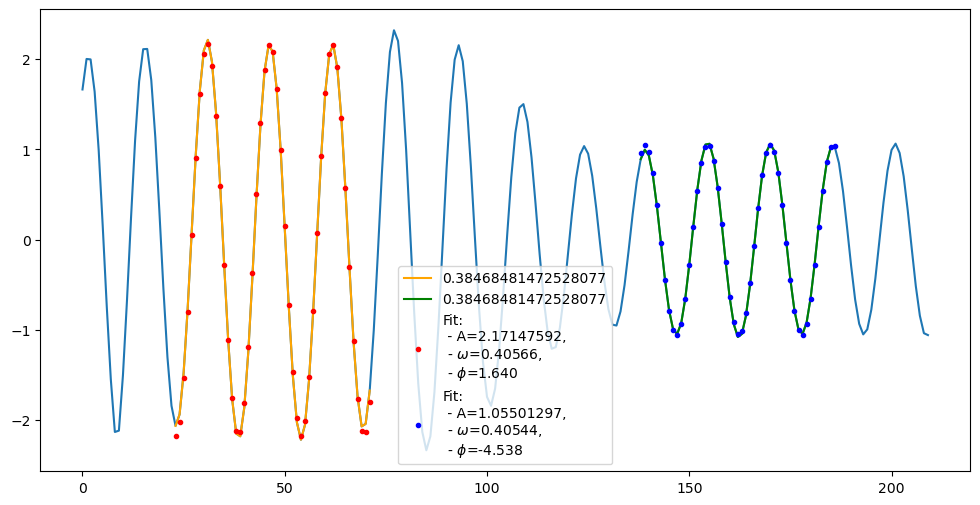

up shift in phase
Plot


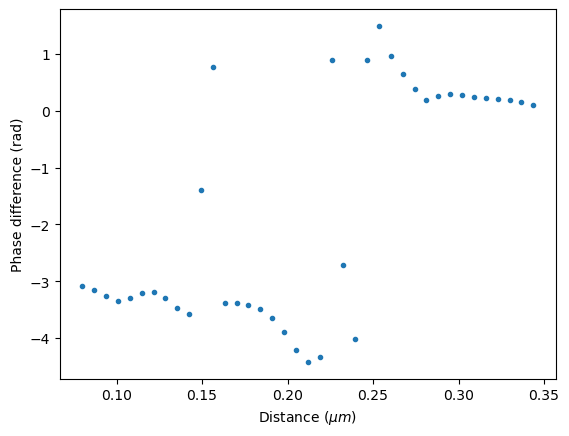

-----------
Initializing structure...
time for choose_chunkdivision = 0.000176191 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.0861909 s
-----------


FloatProgress(value=0.0, description='0% done ', max=600.0)

Meep progress: 432.125/600.0 = 72.0% done in 4.0s, 1.6s to go
on time step 13847 (time=432.719), 0.000288892 s/step
run 0 finished at t = 600.0 (19200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000368834 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     cylinder, center = (0,0.350612,0)
          radius 2.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
     cylinder, center = (0,0.350612,0)
          radius 2, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.117641 s
-----------


FloatProgress(value=0.0, description='0% done ', max=600.0)

Meep progress: 403.75/600.0 = 67.3% done in 4.0s, 1.9s to go
on time step 12939 (time=404.344), 0.000309186 s/step
harminv0:, frequency, imag. freq., Q, |amp|, amplitude, error
harminv0:, 0.7029218954356958, -0.000541420116991312, 649.1464515041057, 0.03209079313347309, -0.02860461241045341+0.014546310624453843i, 1.06318818720795e-11+0.0i
run 0 finished at t = 600.0 (19200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000206947 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.118796 s
-----------


FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 204.4375/1000.0 = 20.4% done in 4.0s, 15.6s to go
on time step 6548 (time=204.625), 0.000610942 s/step
Meep progress: 415.71875/1000.0 = 41.6% done in 8.0s, 11.2s to go
on time step 13309 (time=415.906), 0.000591694 s/step
Meep progress: 621.53125/1000.0 = 62.2% done in 12.0s, 7.3s to go
on time step 19900 (time=621.875), 0.000607112 s/step
Meep progress: 832.0/1000.0 = 83.2% done in 16.0s, 3.2s to go
on time step 26638 (time=832.438), 0.000593692 s/step
run 0 finished at t = 1000.0 (32000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000179052 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     cylinder, center = (0,0.350612,0)
          radius 2.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
     cylinder, center = (0,0.350612,0)
          radius 2, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, cen

FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 208.0625/1000.0 = 20.8% done in 4.0s, 15.2s to go
on time step 6668 (time=208.375), 0.000600005 s/step
Meep progress: 415.8125/1000.0 = 41.6% done in 8.0s, 11.2s to go
on time step 13320 (time=416.25), 0.000601347 s/step
Meep progress: 624.21875/1000.0 = 62.4% done in 12.0s, 7.2s to go
on time step 19987 (time=624.594), 0.000599997 s/step
Meep progress: 839.28125/1000.0 = 83.9% done in 16.0s, 3.1s to go
on time step 26871 (time=839.719), 0.000581165 s/step
run 0 finished at t = 1000.0 (32000 timesteps)


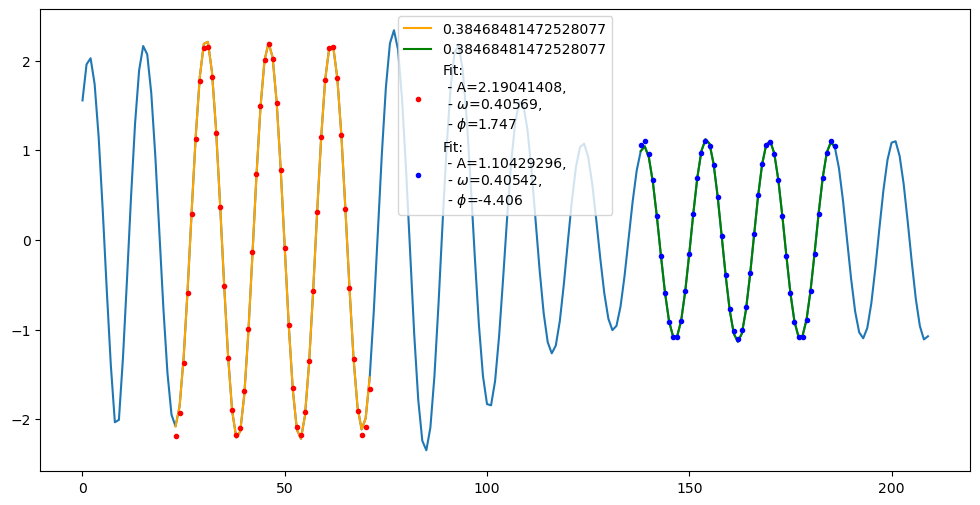

up shift in phase
Plot


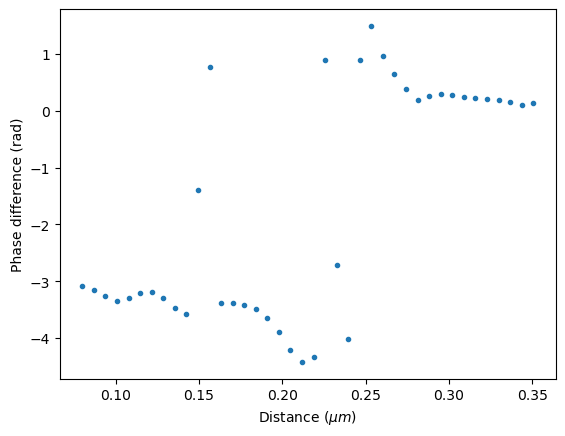

-----------
Initializing structure...
time for choose_chunkdivision = 0.000277996 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.094079 s
-----------


FloatProgress(value=0.0, description='0% done ', max=600.0)

Meep progress: 487.59375/600.0 = 81.3% done in 4.0s, 0.9s to go
on time step 15628 (time=488.375), 0.000255975 s/step
run 0 finished at t = 600.0 (19200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000187159 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     cylinder, center = (0,0.357551,0)
          radius 2.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
     cylinder, center = (0,0.357551,0)
          radius 2, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.129192 s
-----------


FloatProgress(value=0.0, description='0% done ', max=600.0)

Meep progress: 450.84375/600.0 = 75.1% done in 4.0s, 1.3s to go
on time step 14445 (time=451.406), 0.000276946 s/step
harminv0:, frequency, imag. freq., Q, |amp|, amplitude, error
harminv0:, 0.7029131051692387, -0.0005320148391065896, 660.614191090645, 0.031234532174145152, -0.027956762393107883+0.013928942408992059i, 3.9076241169122515e-12+0.0i
run 0 finished at t = 600.0 (19200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000344038 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.177975 s
-----------


FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 154.09375/1000.0 = 15.4% done in 4.0s, 22.0s to go
on time step 4940 (time=154.375), 0.000809719 s/step
Meep progress: 311.6875/1000.0 = 31.2% done in 8.0s, 17.7s to go
on time step 9986 (time=312.062), 0.000792804 s/step
Meep progress: 471.9375/1000.0 = 47.2% done in 12.0s, 13.4s to go
on time step 15116 (time=472.375), 0.000779818 s/step
Meep progress: 627.84375/1000.0 = 62.8% done in 16.0s, 9.5s to go
on time step 20107 (time=628.344), 0.00080157 s/step
Meep progress: 783.40625/1000.0 = 78.3% done in 20.0s, 5.5s to go
on time step 25087 (time=783.969), 0.000803364 s/step
Meep progress: 934.15625/1000.0 = 93.4% done in 24.0s, 1.7s to go
on time step 29912 (time=934.75), 0.000829034 s/step
run 0 finished at t = 1000.0 (32000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000319004 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     cylinder, center = (0,0.357551,0)
          radius 2.5, height 1e+20, 

FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 152.09375/1000.0 = 15.2% done in 4.0s, 22.3s to go
on time step 4873 (time=152.281), 0.000820935 s/step
Meep progress: 304.4375/1000.0 = 30.4% done in 8.0s, 18.3s to go
on time step 9749 (time=304.656), 0.000820379 s/step
Meep progress: 524.71875/1000.0 = 52.5% done in 12.0s, 10.9s to go
on time step 16805 (time=525.156), 0.00056695 s/step
Meep progress: 762.1875/1000.0 = 76.2% done in 16.0s, 5.0s to go
on time step 24405 (time=762.656), 0.00052632 s/step
Meep progress: 997.8125/1000.0 = 99.8% done in 20.0s, 0.0s to go
on time step 31950 (time=998.438), 0.000530176 s/step
run 0 finished at t = 1000.0 (32000 timesteps)


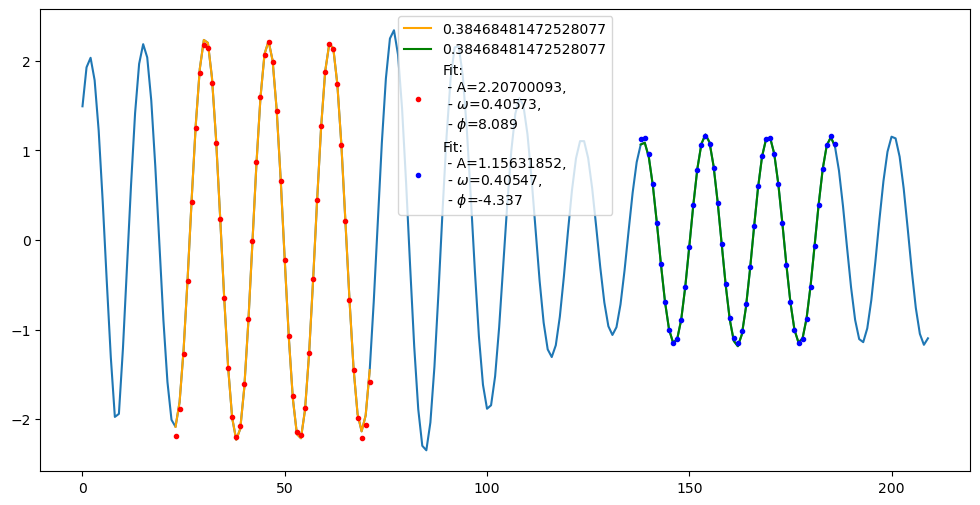

up shift in phase
up shift in phase
Plot


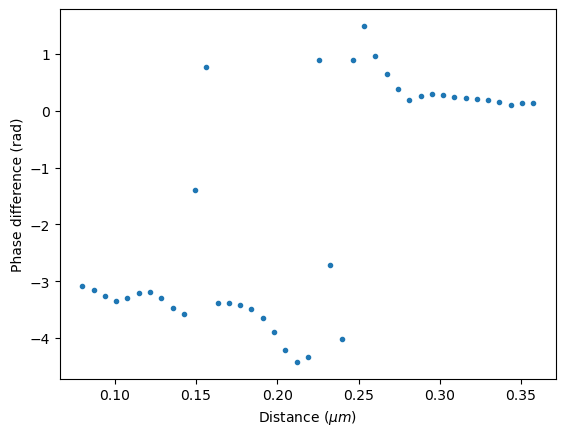

-----------
Initializing structure...
time for choose_chunkdivision = 0.000169039 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.0689759 s
-----------


FloatProgress(value=0.0, description='0% done ', max=600.0)

Meep progress: 458.09375/600.0 = 76.3% done in 4.0s, 1.2s to go
on time step 14688 (time=459), 0.000272334 s/step
run 0 finished at t = 600.0 (19200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000304937 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     cylinder, center = (0,0.36449,0)
          radius 2.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
     cylinder, center = (0,0.36449,0)
          radius 2, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.143276 s
-----------


FloatProgress(value=0.0, description='0% done ', max=600.0)

Meep progress: 432.65625/600.0 = 72.1% done in 4.0s, 1.5s to go
on time step 13857 (time=433.031), 0.000288665 s/step
harminv0:, frequency, imag. freq., Q, |amp|, amplitude, error
harminv0:, 0.7029090332832949, -0.0005231897672913477, 671.7534222070012, 0.030452442275946314, -0.027319510417093816+0.013453460192089794i, 2.5475862206553505e-12+0.0i
run 0 finished at t = 600.0 (19200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000201941 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.121364 s
-----------


FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 227.6875/1000.0 = 22.8% done in 4.0s, 13.6s to go
on time step 7290 (time=227.812), 0.000548741 s/step
Meep progress: 449.46875/1000.0 = 44.9% done in 8.0s, 9.8s to go
on time step 14393 (time=449.781), 0.000563217 s/step
Meep progress: 682.28125/1000.0 = 68.2% done in 12.0s, 5.6s to go
on time step 21844 (time=682.625), 0.000536868 s/step
Meep progress: 924.625/1000.0 = 92.5% done in 16.0s, 1.3s to go
on time step 29601 (time=925.031), 0.00051574 s/step
run 0 finished at t = 1000.0 (32000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000175953 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     cylinder, center = (0,0.36449,0)
          radius 2.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
     cylinder, center = (0,0.36449,0)
          radius 2, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, cente

FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 230.25/1000.0 = 23.0% done in 4.0s, 13.4s to go
on time step 7379 (time=230.594), 0.0005421 s/step
Meep progress: 450.28125/1000.0 = 45.0% done in 8.0s, 9.8s to go
on time step 14418 (time=450.562), 0.000568327 s/step
Meep progress: 673.78125/1000.0 = 67.4% done in 12.0s, 5.8s to go
on time step 21573 (time=674.156), 0.00055911 s/step
Meep progress: 907.75/1000.0 = 90.8% done in 16.0s, 1.6s to go
on time step 29060 (time=908.125), 0.00053438 s/step
run 0 finished at t = 1000.0 (32000 timesteps)


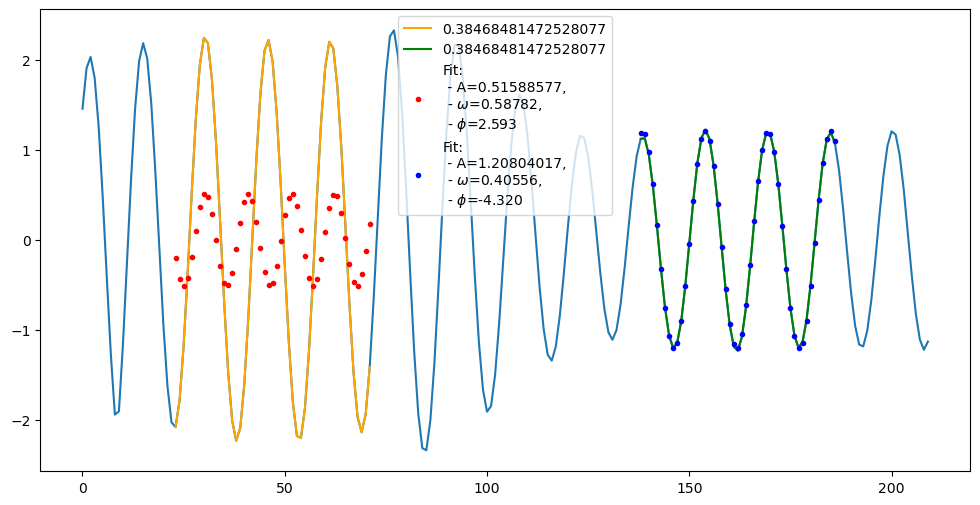

up shift in phase
Plot


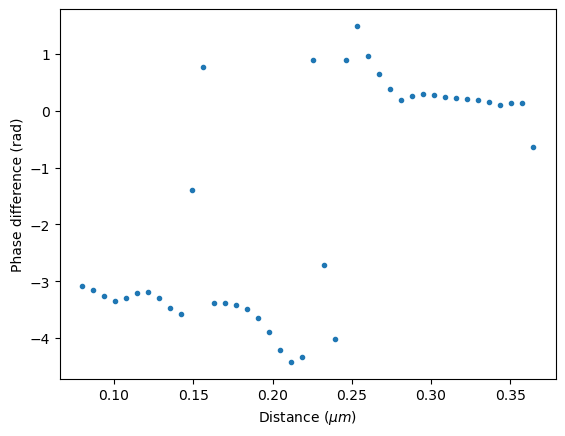

-----------
Initializing structure...
time for choose_chunkdivision = 0.000350952 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.120858 s
-----------


FloatProgress(value=0.0, description='0% done ', max=600.0)

Meep progress: 472.5625/600.0 = 78.8% done in 4.0s, 1.1s to go
on time step 15147 (time=473.344), 0.000264117 s/step
run 0 finished at t = 600.0 (19200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000222921 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     cylinder, center = (0,0.371429,0)
          radius 2.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
     cylinder, center = (0,0.371429,0)
          radius 2, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.212952 s
-----------


FloatProgress(value=0.0, description='0% done ', max=600.0)

Meep progress: 431.71875/600.0 = 72.0% done in 4.0s, 1.6s to go
on time step 13841 (time=432.531), 0.000288997 s/step
harminv0:, frequency, imag. freq., Q, |amp|, amplitude, error
harminv0:, 0.7029019399397172, -0.0005149566125788638, 682.4865656347603, 0.029738528964067052, -0.026749724015864482+0.01299355109359016i, 2.477633491135742e-12+0.0i
run 0 finished at t = 600.0 (19200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000239849 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.120076 s
-----------


FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 217.0625/1000.0 = 21.7% done in 4.0s, 14.4s to go
on time step 6950 (time=217.188), 0.000575577 s/step
Meep progress: 361.1875/1000.0 = 36.1% done in 8.0s, 14.1s to go
on time step 11564 (time=361.375), 0.000867078 s/step
Meep progress: 515.6875/1000.0 = 51.6% done in 12.0s, 11.3s to go
on time step 16510 (time=515.938), 0.000808817 s/step
Meep progress: 670.3125/1000.0 = 67.0% done in 16.0s, 7.9s to go
on time step 21460 (time=670.625), 0.000808154 s/step
Meep progress: 826.125/1000.0 = 82.6% done in 20.0s, 4.2s to go
on time step 26448 (time=826.5), 0.000802008 s/step
Meep progress: 979.5/1000.0 = 98.0% done in 24.0s, 0.5s to go
on time step 31356 (time=979.875), 0.00081522 s/step
run 0 finished at t = 1000.0 (32000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000314951 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     cylinder, center = (0,0.371429,0)
          radius 2.5, height 1e+20, axis (0,

FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 151.15625/1000.0 = 15.1% done in 4.0s, 22.5s to go
on time step 4853 (time=151.656), 0.000824393 s/step
Meep progress: 305.96875/1000.0 = 30.6% done in 8.0s, 18.1s to go
on time step 9807 (time=306.469), 0.000807621 s/step
Meep progress: 460.0/1000.0 = 46.0% done in 12.0s, 14.1s to go
on time step 14739 (time=460.594), 0.000811069 s/step
Meep progress: 630.78125/1000.0 = 63.1% done in 16.0s, 9.4s to go
on time step 20213 (time=631.656), 0.000730756 s/step
Meep progress: 865.4375/1000.0 = 86.5% done in 20.0s, 3.1s to go
on time step 27722 (time=866.312), 0.000532804 s/step
run 0 finished at t = 1000.0 (32000 timesteps)


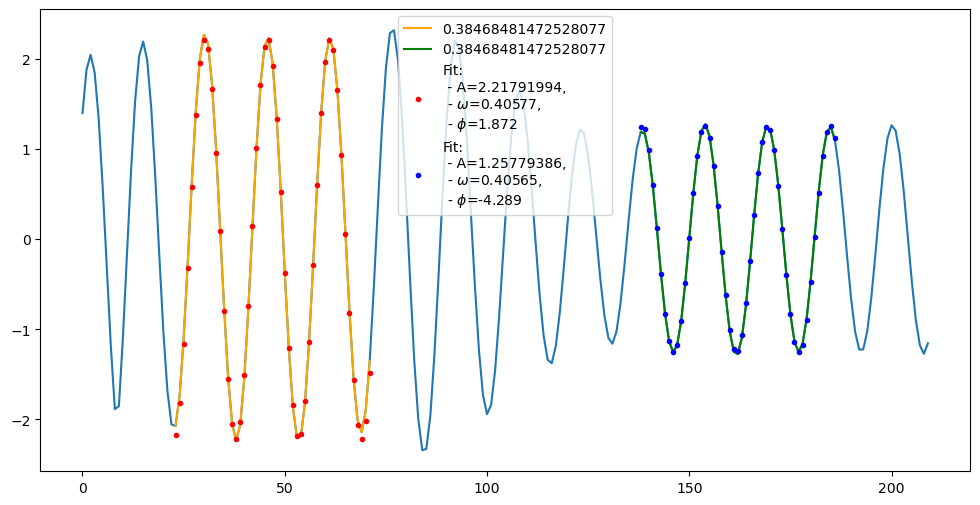

up shift in phase
Plot


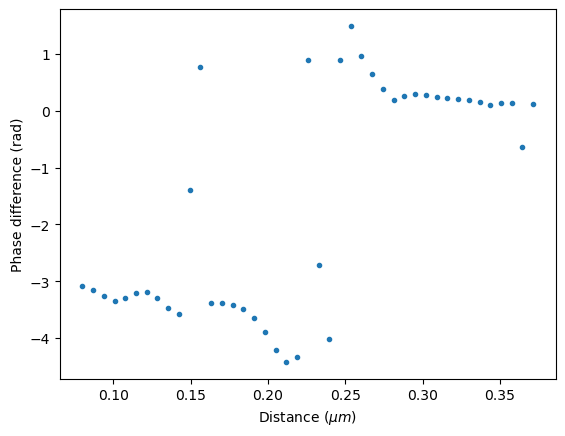

-----------
Initializing structure...
time for choose_chunkdivision = 0.000193119 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.0916529 s
-----------


FloatProgress(value=0.0, description='0% done ', max=600.0)

Meep progress: 479.75/600.0 = 80.0% done in 4.0s, 1.0s to go
on time step 15376 (time=480.5), 0.000260159 s/step
run 0 finished at t = 600.0 (19200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000201941 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     cylinder, center = (0,0.378367,0)
          radius 2.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
     cylinder, center = (0,0.378367,0)
          radius 2, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.121032 s
-----------


FloatProgress(value=0.0, description='0% done ', max=600.0)

Meep progress: 451.5/600.0 = 75.2% done in 4.0s, 1.3s to go
on time step 14455 (time=451.719), 0.000276723 s/step
harminv0:, frequency, imag. freq., Q, |amp|, amplitude, error
harminv0:, 0.7028877335488082, -0.0005072417387535199, 692.8528153815404, 0.028805376074919523, -0.026018328649632882+0.01236107863809784i, 2.490783858918039e-12+0.0i
run 0 finished at t = 600.0 (19200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000193119 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.124812 s
-----------


FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 236.53125/1000.0 = 23.7% done in 4.0s, 12.9s to go
on time step 7580 (time=236.875), 0.000527757 s/step
Meep progress: 471.46875/1000.0 = 47.1% done in 8.0s, 9.0s to go
on time step 15100 (time=471.875), 0.000531964 s/step
Meep progress: 703.96875/1000.0 = 70.4% done in 12.0s, 5.0s to go
on time step 22536 (time=704.25), 0.000538013 s/step
Meep progress: 941.125/1000.0 = 94.1% done in 16.0s, 1.0s to go
on time step 30129 (time=941.531), 0.000526807 s/step
run 0 finished at t = 1000.0 (32000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000177145 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     cylinder, center = (0,0.378367,0)
          radius 2.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
     cylinder, center = (0,0.378367,0)
          radius 2, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, ce

FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 226.59375/1000.0 = 22.7% done in 4.0s, 13.7s to go
on time step 7260 (time=226.875), 0.000551096 s/step
Meep progress: 459.25/1000.0 = 45.9% done in 8.0s, 9.4s to go
on time step 14708 (time=459.625), 0.000537154 s/step
Meep progress: 694.625/1000.0 = 69.5% done in 12.0s, 5.3s to go
on time step 22243 (time=695.094), 0.000530859 s/step
Meep progress: 936.9375/1000.0 = 93.7% done in 16.0s, 1.1s to go
on time step 29997 (time=937.406), 0.000515962 s/step
run 0 finished at t = 1000.0 (32000 timesteps)


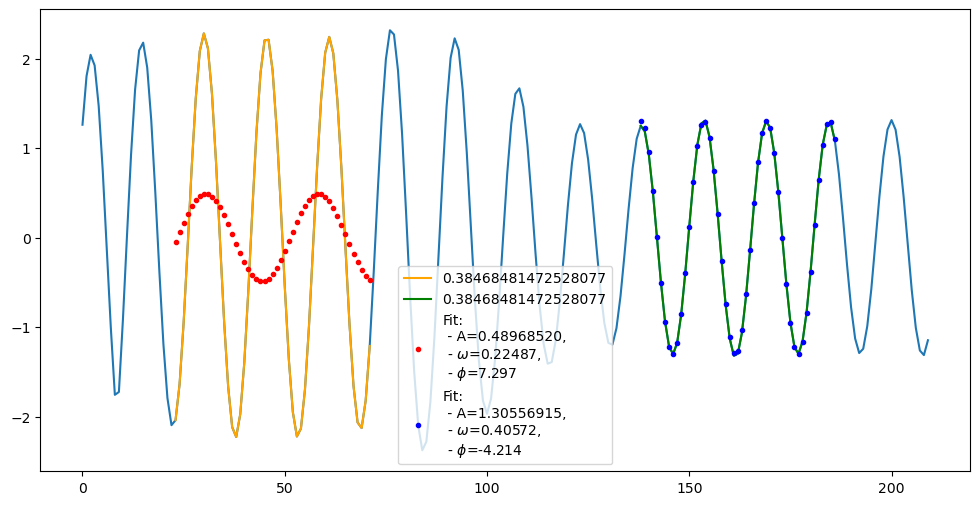

up shift in phase
up shift in phase
Plot


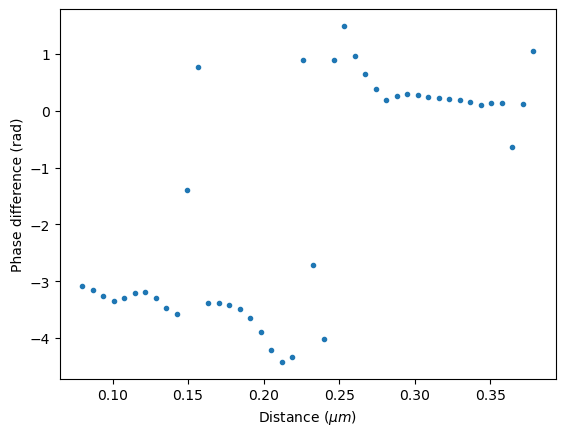

-----------
Initializing structure...
time for choose_chunkdivision = 0.000178814 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.119104 s
-----------


FloatProgress(value=0.0, description='0% done ', max=600.0)

Meep progress: 490.625/600.0 = 81.8% done in 4.0s, 0.9s to go
on time step 15718 (time=491.188), 0.000254495 s/step
run 0 finished at t = 600.0 (19200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000358105 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     cylinder, center = (0,0.385306,0)
          radius 2.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
     cylinder, center = (0,0.385306,0)
          radius 2, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.123416 s
-----------


FloatProgress(value=0.0, description='0% done ', max=600.0)

Meep progress: 469.71875/600.0 = 78.3% done in 4.0s, 1.1s to go
on time step 15048 (time=470.25), 0.000265825 s/step
harminv0:, frequency, imag. freq., Q, |amp|, amplitude, error
harminv0:, 0.7028667140307098, -0.0004999241051854209, 702.973418105152, 0.02767187342927559, -0.02514900529928074+0.011543834351834646i, 2.576064366521706e-12+0.0i
run 0 finished at t = 600.0 (19200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000379086 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.241254 s
-----------


FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 146.96875/1000.0 = 14.7% done in 4.0s, 23.2s to go
on time step 4710 (time=147.188), 0.000849329 s/step
Meep progress: 282.90625/1000.0 = 28.3% done in 8.0s, 20.3s to go
on time step 9061 (time=283.156), 0.000919446 s/step
Meep progress: 417.15625/1000.0 = 41.7% done in 12.0s, 16.8s to go
on time step 13357 (time=417.406), 0.000931216 s/step
Meep progress: 557.8125/1000.0 = 55.8% done in 16.0s, 12.7s to go
on time step 17862 (time=558.188), 0.000888014 s/step
Meep progress: 693.09375/1000.0 = 69.3% done in 20.0s, 8.9s to go
on time step 22191 (time=693.469), 0.000924059 s/step
Meep progress: 833.6875/1000.0 = 83.4% done in 24.0s, 4.8s to go
on time step 26693 (time=834.156), 0.000888612 s/step
Meep progress: 975.28125/1000.0 = 97.5% done in 28.0s, 0.7s to go
on time step 31226 (time=975.812), 0.000882458 s/step
run 0 finished at t = 1000.0 (32000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000309944 s
Working in 2D dimensions.
Compu

FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 139.1875/1000.0 = 13.9% done in 4.0s, 24.7s to go
on time step 4461 (time=139.406), 0.000896753 s/step
Meep progress: 279.8125/1000.0 = 28.0% done in 8.0s, 20.6s to go
on time step 8963 (time=280.094), 0.000888699 s/step
Meep progress: 424.78125/1000.0 = 42.5% done in 12.0s, 16.3s to go
on time step 13603 (time=425.094), 0.000862109 s/step
Meep progress: 576.21875/1000.0 = 57.6% done in 16.0s, 11.8s to go
on time step 18451 (time=576.594), 0.000825101 s/step
Meep progress: 816.75/1000.0 = 81.7% done in 20.0s, 4.5s to go
on time step 26157 (time=817.406), 0.00051916 s/step
run 0 finished at t = 1000.0 (32000 timesteps)


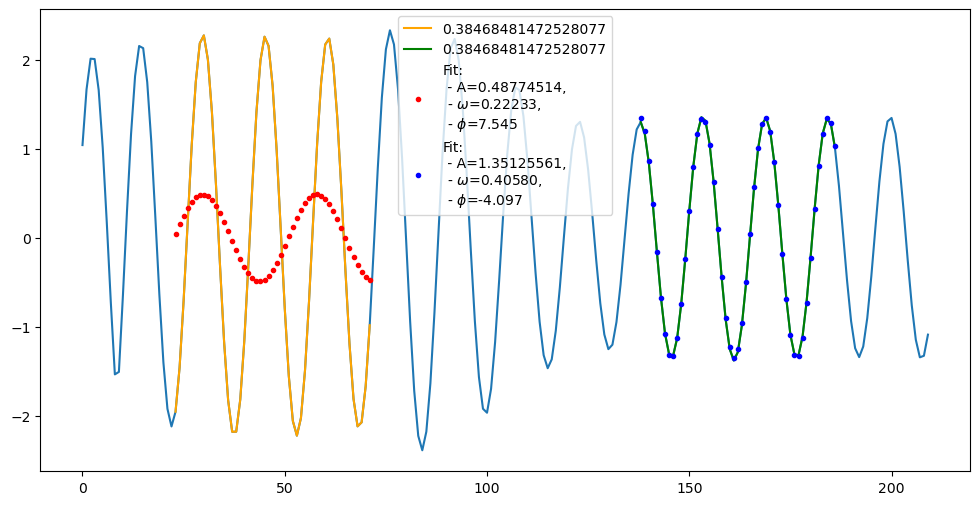

up shift in phase
up shift in phase
Plot


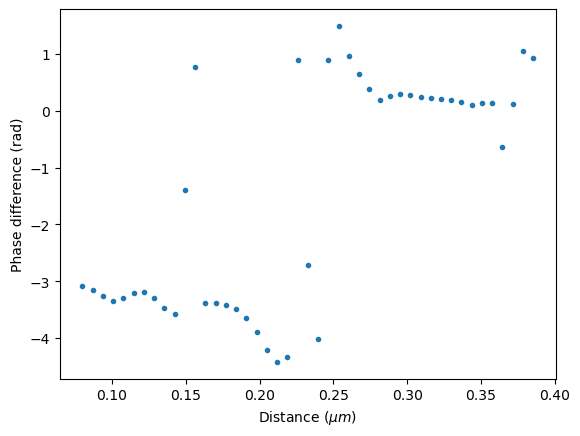

-----------
Initializing structure...
time for choose_chunkdivision = 0.000240088 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.113668 s
-----------


FloatProgress(value=0.0, description='0% done ', max=600.0)

Meep progress: 493.25/600.0 = 82.2% done in 4.0s, 0.9s to go
on time step 15798 (time=493.688), 0.000253221 s/step
run 0 finished at t = 600.0 (19200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000163794 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     cylinder, center = (0,0.392245,0)
          radius 2.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
     cylinder, center = (0,0.392245,0)
          radius 2, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.118575 s
-----------


FloatProgress(value=0.0, description='0% done ', max=600.0)

Meep progress: 442.65625/600.0 = 73.8% done in 4.0s, 1.4s to go
on time step 14176 (time=443), 0.000282171 s/step
harminv0:, frequency, imag. freq., Q, |amp|, amplitude, error
harminv0:, 0.7028430662485685, -0.0004927634269204959, 713.1648047024881, 0.026641112710026643, -0.024382803638143404+0.010734420020293782i, 4.7223158255099585e-12+0.0i
run 0 finished at t = 600.0 (19200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00019908 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.112559 s
-----------


FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 213.625/1000.0 = 21.4% done in 4.0s, 14.7s to go
on time step 6843 (time=213.844), 0.000584583 s/step
Meep progress: 454.5625/1000.0 = 45.5% done in 8.0s, 9.6s to go
on time step 14556 (time=454.875), 0.000518659 s/step
Meep progress: 705.71875/1000.0 = 70.6% done in 12.0s, 5.0s to go
on time step 22592 (time=706), 0.000497828 s/step
Meep progress: 956.15625/1000.0 = 95.6% done in 16.0s, 0.7s to go
on time step 30612 (time=956.625), 0.000498829 s/step
run 0 finished at t = 1000.0 (32000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000164986 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     cylinder, center = (0,0.392245,0)
          radius 2.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
     cylinder, center = (0,0.392245,0)
          radius 2, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center

FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 234.40625/1000.0 = 23.4% done in 4.0s, 13.1s to go
on time step 7509 (time=234.656), 0.000532703 s/step
Meep progress: 467.03125/1000.0 = 46.7% done in 8.0s, 9.1s to go
on time step 14958 (time=467.438), 0.000537108 s/step
Meep progress: 707.0/1000.0 = 70.7% done in 12.0s, 5.0s to go
on time step 22636 (time=707.375), 0.000521041 s/step
Meep progress: 946.9375/1000.0 = 94.7% done in 16.0s, 0.9s to go
on time step 30318 (time=947.438), 0.00052071 s/step
run 0 finished at t = 1000.0 (32000 timesteps)


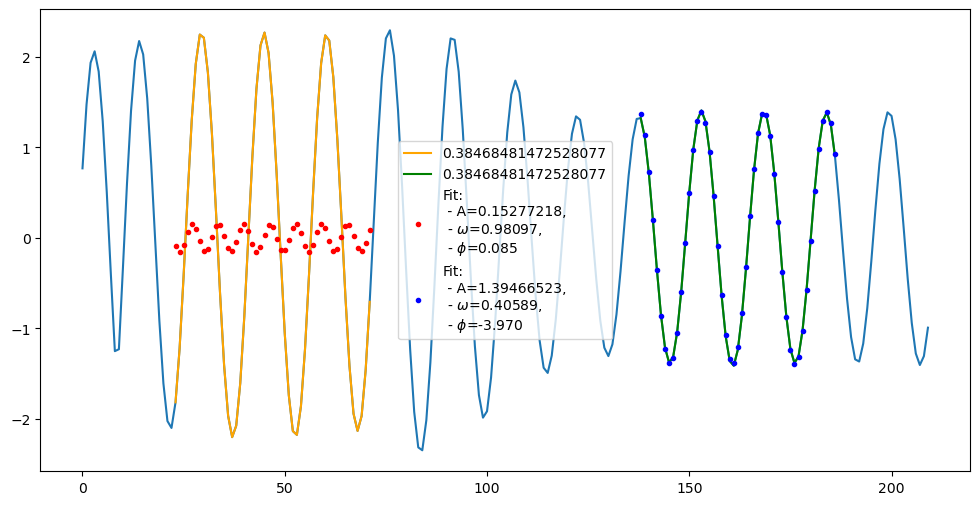

Plot


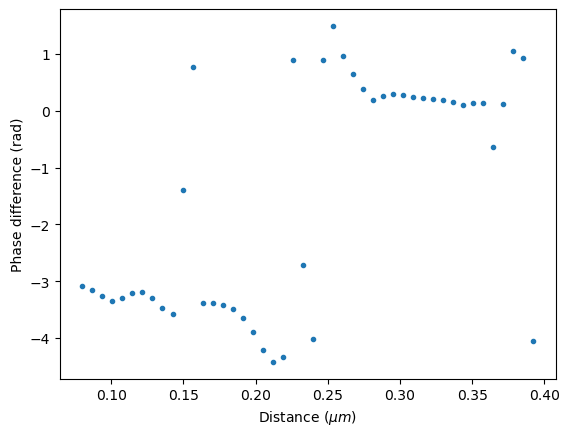

-----------
Initializing structure...
time for choose_chunkdivision = 0.000200987 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.10686 s
-----------


FloatProgress(value=0.0, description='0% done ', max=600.0)

Meep progress: 469.875/600.0 = 78.3% done in 4.0s, 1.1s to go
on time step 15055 (time=470.469), 0.000265697 s/step
run 0 finished at t = 600.0 (19200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000171185 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     cylinder, center = (0,0.399184,0)
          radius 2.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
     cylinder, center = (0,0.399184,0)
          radius 2, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.174105 s
-----------


FloatProgress(value=0.0, description='0% done ', max=600.0)

Meep progress: 456.375/600.0 = 76.1% done in 4.0s, 1.3s to go
on time step 14643 (time=457.594), 0.000273175 s/step
harminv0:, frequency, imag. freq., Q, |amp|, amplitude, error
harminv0:, 0.7028248188673798, -0.0004854883312661694, 723.8328643598804, 0.025701541475650964, -0.023662491846967986+0.010032732121250934i, 1.6715024669690317e-11+0.0i
run 0 finished at t = 600.0 (19200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000256062 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.138277 s
-----------


FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 165.53125/1000.0 = 16.6% done in 4.0s, 20.2s to go
on time step 5302 (time=165.688), 0.000754615 s/step
Meep progress: 322.6875/1000.0 = 32.3% done in 8.0s, 16.8s to go
on time step 10332 (time=322.875), 0.000795293 s/step
Meep progress: 476.84375/1000.0 = 47.7% done in 12.0s, 13.2s to go
on time step 15270 (time=477.188), 0.00081021 s/step
Meep progress: 633.71875/1000.0 = 63.4% done in 16.0s, 9.2s to go
on time step 20290 (time=634.062), 0.000796832 s/step
Meep progress: 795.4375/1000.0 = 79.5% done in 20.0s, 5.1s to go
on time step 25467 (time=795.844), 0.000772649 s/step
Meep progress: 957.40625/1000.0 = 95.7% done in 24.0s, 1.1s to go
on time step 30650 (time=957.812), 0.000771968 s/step
run 0 finished at t = 1000.0 (32000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000306845 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     cylinder, center = (0,0.399184,0)
          radius 2.5, height 1e+20

FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 132.25/1000.0 = 13.2% done in 4.0s, 26.2s to go
on time step 4241 (time=132.531), 0.000943199 s/step
Meep progress: 279.53125/1000.0 = 28.0% done in 8.0s, 20.6s to go
on time step 8955 (time=279.844), 0.000848552 s/step
Meep progress: 424.1875/1000.0 = 42.4% done in 12.0s, 16.3s to go
on time step 13584 (time=424.5), 0.000864256 s/step
Meep progress: 562.28125/1000.0 = 56.2% done in 16.0s, 12.5s to go
on time step 18005 (time=562.656), 0.000904779 s/step
Meep progress: 704.28125/1000.0 = 70.4% done in 20.0s, 8.4s to go
on time step 22550 (time=704.688), 0.000880257 s/step
Meep progress: 857.25/1000.0 = 85.7% done in 24.0s, 4.0s to go
on time step 27450 (time=857.812), 0.000816369 s/step
run 0 finished at t = 1000.0 (32000 timesteps)


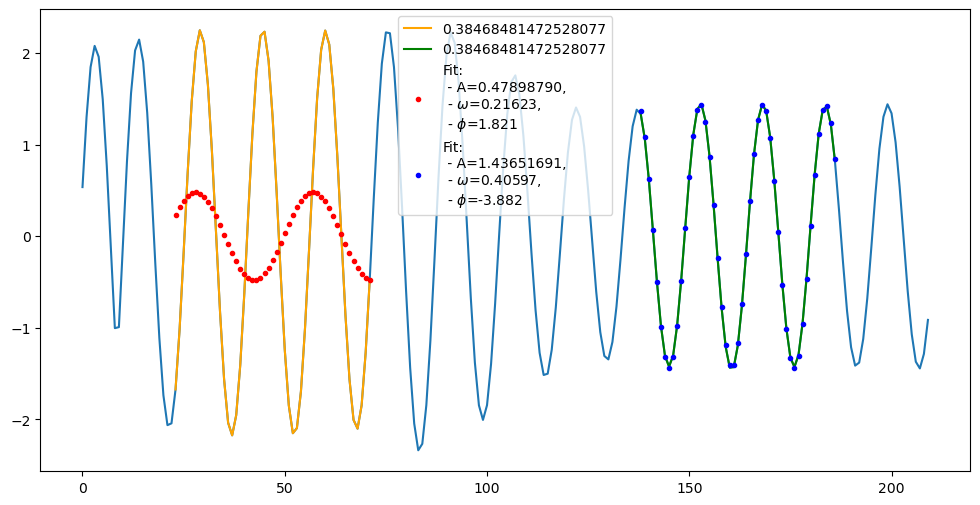

up shift in phase
Plot


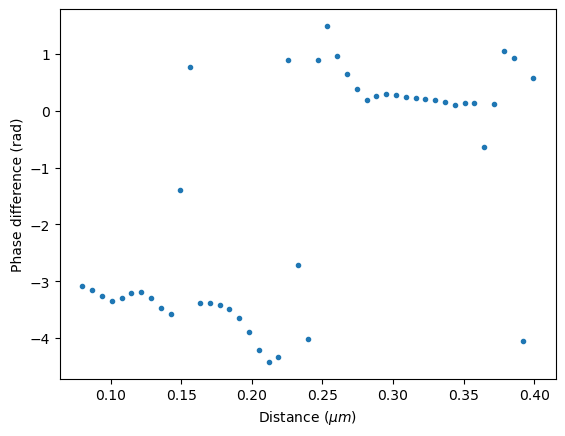

-----------
Initializing structure...
time for choose_chunkdivision = 0.000243902 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.103047 s
-----------


FloatProgress(value=0.0, description='0% done ', max=600.0)

Meep progress: 392.625/600.0 = 65.4% done in 4.0s, 2.1s to go
on time step 12574 (time=392.938), 0.000318164 s/step
run 0 finished at t = 600.0 (19200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000163794 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     cylinder, center = (0,0.406122,0)
          radius 2.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
     cylinder, center = (0,0.406122,0)
          radius 2, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.116395 s
-----------


FloatProgress(value=0.0, description='0% done ', max=600.0)

Meep progress: 428.5625/600.0 = 71.4% done in 4.0s, 1.6s to go
on time step 13737 (time=429.281), 0.000291202 s/step
harminv0:, frequency, imag. freq., Q, |amp|, amplitude, error
harminv0:, 0.7028142504748223, -0.00047825451364785104, 734.7701176034476, 0.024830052859377057, -0.022952960131864656+0.009470646555779092i, 4.326534521992031e-11+0.0i
run 0 finished at t = 600.0 (19200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000204086 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.107688 s
-----------


FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 148.8125/1000.0 = 14.9% done in 4.0s, 22.9s to go
on time step 4766 (time=148.938), 0.000839391 s/step
Meep progress: 288.34375/1000.0 = 28.8% done in 8.0s, 19.7s to go
on time step 9232 (time=288.5), 0.000895716 s/step
Meep progress: 433.96875/1000.0 = 43.4% done in 12.0s, 15.7s to go
on time step 13895 (time=434.219), 0.000857931 s/step
Meep progress: 583.90625/1000.0 = 58.4% done in 16.0s, 11.4s to go
on time step 18692 (time=584.125), 0.000833967 s/step
Meep progress: 742.25/1000.0 = 74.2% done in 20.0s, 6.9s to go
on time step 23762 (time=742.562), 0.000788962 s/step
Meep progress: 903.03125/1000.0 = 90.3% done in 24.0s, 2.6s to go
on time step 28908 (time=903.375), 0.000777319 s/step
run 0 finished at t = 1000.0 (32000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000353813 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     cylinder, center = (0,0.406122,0)
          radius 2.5, height 1e+20, a

FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 153.1875/1000.0 = 15.3% done in 4.0s, 22.1s to go
on time step 4916 (time=153.625), 0.000813908 s/step
Meep progress: 293.375/1000.0 = 29.3% done in 8.0s, 19.3s to go
on time step 9403 (time=293.844), 0.000891563 s/step
Meep progress: 468.1875/1000.0 = 46.8% done in 12.0s, 13.6s to go
on time step 15008 (time=469), 0.000713832 s/step
Meep progress: 669.21875/1000.0 = 66.9% done in 16.0s, 7.9s to go
on time step 21443 (time=670.094), 0.00062171 s/step
Meep progress: 876.6875/1000.0 = 87.7% done in 20.0s, 2.8s to go
on time step 28079 (time=877.469), 0.000602839 s/step
run 0 finished at t = 1000.0 (32000 timesteps)


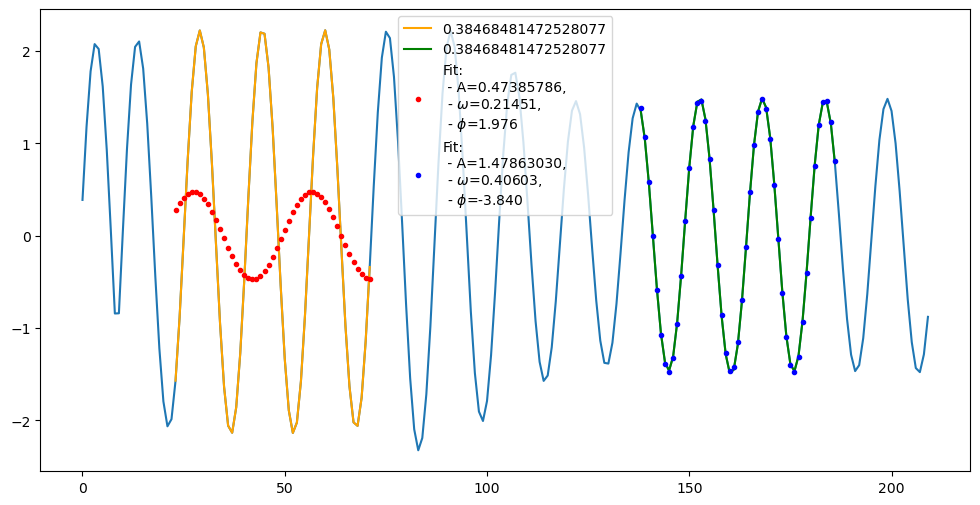

up shift in phase
Plot


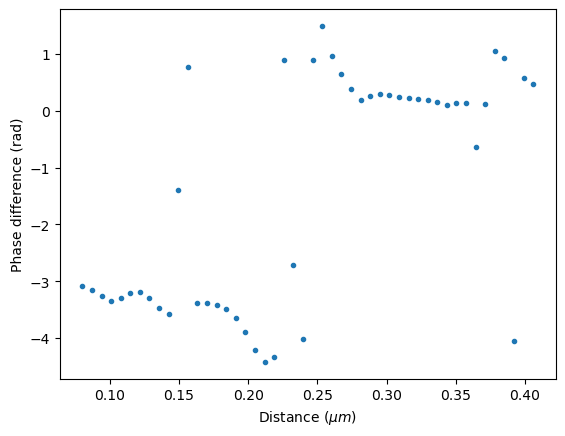

-----------
Initializing structure...
time for choose_chunkdivision = 0.000225067 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.106321 s
-----------


FloatProgress(value=0.0, description='0% done ', max=600.0)

Meep progress: 425.625/600.0 = 70.9% done in 4.0s, 1.6s to go
on time step 13637 (time=426.156), 0.000293326 s/step
run 0 finished at t = 600.0 (19200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000361919 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     cylinder, center = (0,0.413061,0)
          radius 2.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
     cylinder, center = (0,0.413061,0)
          radius 2, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.117009 s
-----------


FloatProgress(value=0.0, description='0% done ', max=600.0)

Meep progress: 254.5/600.0 = 42.4% done in 4.0s, 5.4s to go
on time step 8152 (time=254.75), 0.000490692 s/step
Meep progress: 459.625/600.0 = 76.6% done in 8.0s, 2.4s to go
on time step 14721 (time=460.031), 0.000608971 s/step
harminv0:, frequency, imag. freq., Q, |amp|, amplitude, error
harminv0:, 0.7028031036007627, -0.0004723930189119404, 743.8754124897149, 0.02401815366579614, -0.022292737034088635+0.00893899217153531i, 1.6872049213614707e-11+0.0i
run 0 finished at t = 600.0 (19200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000353813 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.179154 s
-----------


FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 141.53125/1000.0 = 14.2% done in 4.0s, 24.3s to go
on time step 4538 (time=141.812), 0.000881601 s/step
Meep progress: 286.0625/1000.0 = 28.6% done in 8.0s, 20.0s to go
on time step 9166 (time=286.438), 0.000864469 s/step
Meep progress: 423.5625/1000.0 = 42.4% done in 12.0s, 16.3s to go
on time step 13567 (time=423.969), 0.000909016 s/step
Meep progress: 570.0/1000.0 = 57.0% done in 16.0s, 12.1s to go
on time step 18255 (time=570.469), 0.000853246 s/step
Meep progress: 712.3125/1000.0 = 71.2% done in 20.0s, 8.1s to go
on time step 22808 (time=712.75), 0.000878626 s/step
Meep progress: 859.15625/1000.0 = 85.9% done in 24.0s, 3.9s to go
on time step 27509 (time=859.656), 0.000850926 s/step
run 0 finished at t = 1000.0 (32000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000172853 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     cylinder, center = (0,0.413061,0)
          radius 2.5, height 1e+20, axi

FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 206.78125/1000.0 = 20.7% done in 4.0s, 15.3s to go
on time step 6623 (time=206.969), 0.000603989 s/step
Meep progress: 417.34375/1000.0 = 41.7% done in 8.0s, 11.2s to go
on time step 13366 (time=417.688), 0.000593239 s/step
Meep progress: 623.8125/1000.0 = 62.4% done in 12.0s, 7.2s to go
on time step 19971 (time=624.094), 0.000605678 s/step
Meep progress: 822.59375/1000.0 = 82.3% done in 16.0s, 3.5s to go
on time step 26336 (time=823), 0.000628465 s/step
run 0 finished at t = 1000.0 (32000 timesteps)


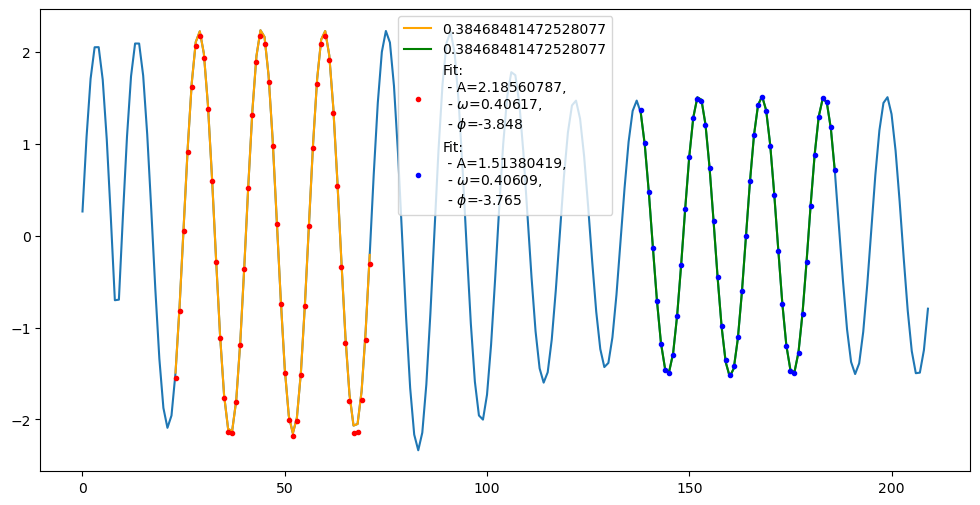

Plot


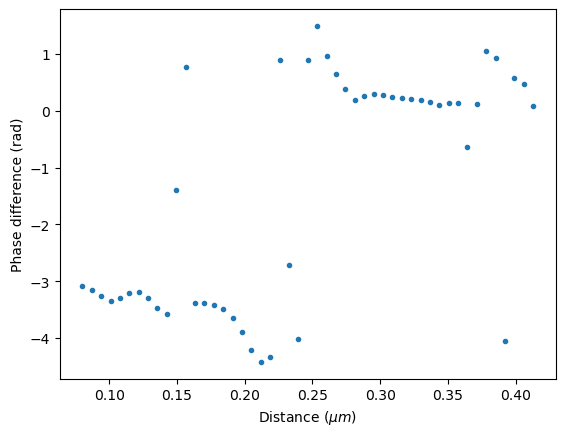

-----------
Initializing structure...
time for choose_chunkdivision = 0.000205994 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.124921 s
-----------


FloatProgress(value=0.0, description='0% done ', max=600.0)

Meep progress: 488.78125/600.0 = 81.5% done in 4.0s, 0.9s to go
on time step 15667 (time=489.594), 0.000255339 s/step
run 0 finished at t = 600.0 (19200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000396967 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     cylinder, center = (0,0.42,0)
          radius 2.5, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
     cylinder, center = (0,0.42,0)
          radius 2, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.122501 s
-----------


FloatProgress(value=0.0, description='0% done ', max=600.0)

Meep progress: 479.25/600.0 = 79.9% done in 4.0s, 1.0s to go
on time step 15358 (time=479.938), 0.000260455 s/step
harminv0:, frequency, imag. freq., Q, |amp|, amplitude, error
harminv0:, 0.702798773822152, -0.00046704007591635057, 752.3966465225, 0.02327737033248283, -0.021655710809062204+0.008536167696912842i, 4.2399999808023405e-12+0.0i
run 0 finished at t = 600.0 (19200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000267029 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     block, center = (0,-2.75,0)
          size (15,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.89,2.89,2.89)
time for set_epsilon = 0.111477 s
-----------


FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 212.6875/1000.0 = 21.3% done in 4.0s, 14.8s to go
on time step 6809 (time=212.781), 0.000587522 s/step
Meep progress: 367.65625/1000.0 = 36.8% done in 8.0s, 13.8s to go
on time step 11771 (time=367.844), 0.000806138 s/step
Meep progress: 525.09375/1000.0 = 52.5% done in 12.0s, 10.9s to go
on time step 16810 (time=525.312), 0.0007939 s/step
Meep progress: 682.78125/1000.0 = 68.3% done in 16.0s, 7.4s to go
on time step 21858 (time=683.062), 0.00079245 s/step
Meep progress: 839.25/1000.0 = 83.9% done in 20.0s, 3.8s to go
on time step 26866 (time=839.562), 0.000798728 s/step
Meep progress: 997.09375/1000.0 = 99.7% done in 24.0s, 0.1s to go
on time step 31918 (time=997.438), 0.000791887 s/step
run 0 finished at t = 1000.0 (32000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000308037 s
Working in 2D dimensions.
Computational cell is 15 x 15 x 0 with resolution 16
     cylinder, center = (0,0.42,0)
          radius 2.5, height 1e+20, axis (

FloatProgress(value=0.0, description='0% done ', max=1000.0)

Meep progress: 152.28125/1000.0 = 15.2% done in 4.0s, 22.3s to go
on time step 4882 (time=152.562), 0.000819467 s/step
Meep progress: 307.9375/1000.0 = 30.8% done in 8.0s, 18.0s to go
on time step 9865 (time=308.281), 0.000802751 s/step
Meep progress: 455.0/1000.0 = 45.5% done in 12.0s, 14.4s to go
on time step 14571 (time=455.344), 0.000850013 s/step
Meep progress: 614.90625/1000.0 = 61.5% done in 16.0s, 10.0s to go
on time step 19692 (time=615.375), 0.00078112 s/step
Meep progress: 775.875/1000.0 = 77.6% done in 20.0s, 5.8s to go
on time step 24842 (time=776.312), 0.000776774 s/step
Meep progress: 934.03125/1000.0 = 93.4% done in 24.0s, 1.7s to go
on time step 29908 (time=934.625), 0.000789762 s/step
run 0 finished at t = 1000.0 (32000 timesteps)


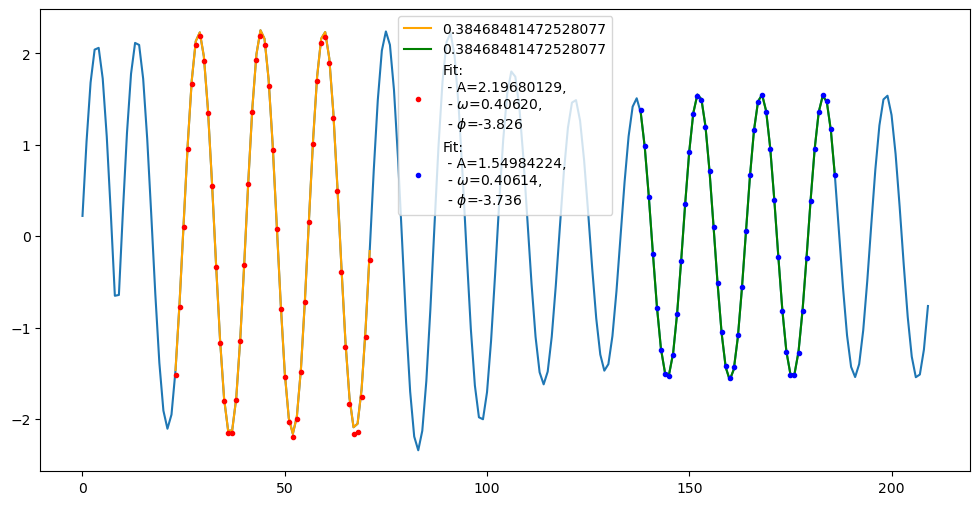

Plot


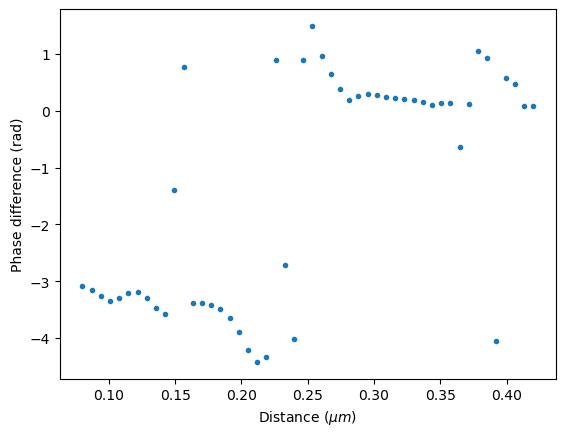

In [22]:
plot= True
ndist_scan = 50

outer_border=int(resolution*0.5 + 15)
inner_border=int(resolution*0.5 + 25)

before_start = outer_border
before_end = int(len(ez_profile)/2 - inner_border)
after_start = len(ez_profile) - before_end
after_end = len(ez_profile) - before_start
    
distance = []
phase_difference = []

for dist in np.linspace(0.08, 0.42, ndist_scan):
    c1 = mp.Cylinder(radius = r + w, material = mp.Medium(index=n), center=mp.Vector3(0,dist,0))
    c2 = mp.Cylinder(radius = r, material = mp.Medium(index=1.), center=mp.Vector3(0,dist,0))

# Gaussian source to estimate the resonance frequency
    src = mp.Source(
        mp.GaussianSource(fcen, fwidth=df),
        mp.Ez,
        center=mp.Vector3(-sxy/2 + dpml + 0.5, y_wg, 0),
        size=mp.Vector3(0,0.8*w,0)
        )

    for norma in ['Waveguide', 'Ring']:
        if (norma == 'Ring'):
            sim.reset_meep()
            geometry = [c1,c2,guide]
        elif (norma == 'Waveguide'):
            geometry = [guide]
        
        sim = mp.Simulation(
            cell_size=mp.Vector3(sxy,sxy),
            geometry=geometry,
            sources=[src],
            resolution=resolution,
            boundary_layers=[mp.PML(dpml)]
            )

        # tran = sim.add_flux(fcen, df, nfreq, trans_fr)
        refl = sim.add_flux(fcen, df, nfreq, refl_fr)

        if (norma == 'Ring'):
            h=mp.Harminv(mp.Ez, mp.Vector3(r + 0.3*w, dist, 0), fcen, df)
            sim.load_minus_flux_data(refl, scatt_refl_data)
            sim.run(mp.after_sources(h), until_after_sources=gaussian_runtime)
        elif (norma == 'Waveguide'):
            sim.run(until_after_sources=gaussian_runtime)
            scatt_refl_data = sim.get_flux_data(refl)

        sim.reset_meep()

    mode_amp = np.abs([data[3] for data in h.modes])
    mode_freqs = [data[0] for data in h.modes]

    res_freq = mode_freqs[np.where(mode_amp == max(mode_amp))[0][0]]

# Continuous source to estimate the phase difference
    src = mp.Source(
            mp.ContinuousSource(res_freq),
            mp.Ez,
            center=mp.Vector3(-sxy/2 + dpml + 0.5, y_wg, 0),
            size=mp.Vector3(0,0.8*w,0)
            )

    for norma in ['Waveguide', 'Ring']:
        if (norma == 'Ring'):
            sim.reset_meep()
            geometry = [c1,c2,guide]
        elif (norma == 'Waveguide'):
            sim.reset_meep()
            geometry = [guide]

        sim = mp.Simulation(
                cell_size=mp.Vector3(sxy,sxy),
                geometry=geometry,
                sources=[src],
                resolution=resolution,
                boundary_layers=[mp.PML(dpml)]
                )

        refl = sim.add_flux(res_freq, df, nfreq, refl_fr)

        if (norma == 'Ring'):
            h=mp.Harminv(mp.Ez, mp.Vector3(r + 0.3*w, dist, 0), fcen, df)
            sim.load_minus_flux_data(refl, scatt_refl_data)
            sim.run(until=runtime)
        elif (norma == 'Waveguide'):
            sim.run(until=runtime)
            scatt_refl_data = sim.get_flux_data(refl)
                        
    ez_data = sim.get_array(center= mp.Vector3(0, y_wg, 0),
                            size=mp.Vector3(sxy-2*dpml, w),
                            component=mp.Ez)
    ez_profile = np.sum(ez_data, axis=1)

    before_field = ez_profile[before_start:before_end]
    after_field = ez_profile[after_start:after_end]

    ft_before = np.fft.rfft(before_field)
    ft_after = np.fft.rfft(after_field)
    freq = np.fft.rfftfreq(len(before_field), d=1)

    before_peak = np.argmax(np.abs(ft_before[1:])) + 1
    after_peak = np.argmax(np.abs(ft_after[1:])) + 1

    popt_before, _ = curve_fit(fit_sin, np.arange(before_start, before_end), before_field, p0=[max(before_field), 2*np.pi*freq[before_peak] , 0],
                            bounds=[[0,0,-np.inf], np.inf], maxfev=10000)
    popt_after, _ = curve_fit(fit_sin, np.arange(after_start, after_end), after_field, p0=[max(after_field)*1.5, 2*np.pi*freq[after_peak], 0],
                            bounds=[[0,0,-np.inf], np.inf], maxfev=10000)

    if (plot):
        fig, ax = plt.subplots(1, 1, figsize=(12,6))

        ax.plot(np.arange(len(ez_profile)), ez_profile)
        ax.plot(np.arange(before_start, before_end),before_field, c='orange', label=f'{2*np.pi*freq[before_peak]}')
        ax.plot(np.arange(after_start, after_end),after_field, c='green', label=f'{2*np.pi*freq[after_peak]}')
        ax.plot(np.arange(before_start, before_end),fit_sin(np.arange(before_start, before_end), *popt_before), 'r.', 
                label='Fit:\n - A=%5.8f,\n - $\omega$=%5.5f,\n - $\phi$=%5.3f' % tuple(popt_before))
        ax.plot(np.arange(after_start, after_end),fit_sin(np.arange(after_start, after_end), *popt_after), 'b.',
                label='Fit:\n - A=%5.8f,\n - $\omega$=%5.5f,\n - $\phi$=%5.3f' % tuple(popt_after))

        plt.legend()
        plt.show()
    else:
        clear_output()

    distance += [dist]
    phase = popt_after[2]-popt_before[2]
    while (phase < -np.pi*3/2):
        print('up shift in phase')
        phase += 2*np.pi
    while (phase > np.pi/2):
        print('down shift in phase')
        phase += -2*np.pi
    phase_difference += [phase]

    print('Plot')
    fig, ax = plt.subplots(1,1)

    ax.plot(distance, phase_difference, '.')

    ax.set_xlabel('Distance ($\mu m$)')
    ax.set_ylabel('Phase difference (rad)')
    plt.show()